In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import pymysql.cursors
import yfinance as yf
import math
from math import sqrt
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, BatchNormalization, TimeDistributed, Flatten, Bidirectional,Dropout, MultiHeadAttention
from pyhht.visualization import plot_imfs
from sklearn.metrics import r2_score
from datetime import datetime,timedelta
from pyhht.emd import EMD
from matplotlib import pyplot
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import time
from keras_self_attention import SeqSelfAttention
from attention import Attention
from pyhht.emd import EMD
from matplotlib import pyplot
from pyhht.visualization import plot_imfs
from PyEMD import CEEMDAN

In [244]:
train_begin_date = '2016-01-01'
train_end_date = '2021-01-01'
predict_begin_date = '2022-01-01'
predict_end_date = '2023-01-01'

In [245]:
train_dataframe_Close = yf.download('^TWII',start=train_begin_date,end=train_end_date)
train_dataframe_Close = train_dataframe_Close['Close']
train_dataframe_Close = pd.DataFrame(train_dataframe_Close)
train_dataframe_Close

[*********************100%***********************]  1 of 1 completed


Close
Date                    
2016-01-04   8114.259766
2016-01-05   8075.109863
2016-01-06   7990.390137
2016-01-07   7852.060059
2016-01-08   7893.970215
...                  ...
2020-12-25  14331.419922
2020-12-28  14483.070312
2020-12-29  14472.049805
2020-12-30  14687.700195
2020-12-31  14732.530273

[1216 rows x 1 columns]

In [246]:
test_dataframe_Close = yf.download('^TWII',start=predict_begin_date,end=predict_end_date)
test_dataframe_Close = test_dataframe_Close['Close']
test_dataframe_Close = pd.DataFrame(test_dataframe_Close)
test_dataframe_Close

[*********************100%***********************]  1 of 1 completed


Close
Date                    
2022-01-03  18270.509766
2022-01-04  18526.349609
2022-01-05  18499.960938
2022-01-06  18367.919922
2022-01-07  18169.759766
...                  ...
2022-12-26  14285.129883
2022-12-27  14328.429688
2022-12-28  14173.099609
2022-12-29  14085.019531
2022-12-30  14137.690430

[246 rows x 1 columns]

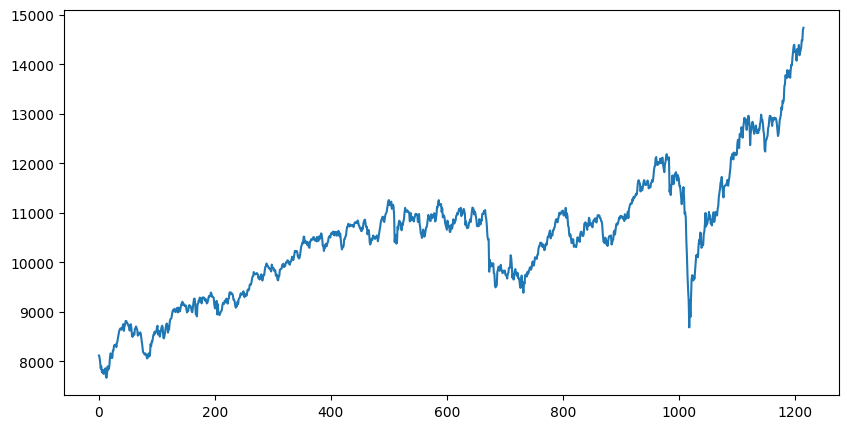

In [247]:
train=np.array(train_dataframe_Close.astype('float'))
plt.figure(figsize=(10 ,5))
plt.plot(train)

In [248]:
len(train)

1216

In [249]:
test=np.array(test_dataframe_Close.astype('float'))

In [2]:
look_back = 30
batch_size = 60
epochs = 100

# 預訓練模型

In [3]:
def createSlidingWindow(dataset,windowSize):
    x_train = []
    y_train = []
    for i in range(len(dataset)-windowSize):
        x_train.append(dataset[i:i+windowSize])
        y_train.append(dataset[i+windowSize])
    print(np.array(x_train))
    print(np.array(y_train))
    return np.array(x_train), np.array(y_train)

In [4]:
def LSTM_model(x_train, y_train,timestep):
    scaler = MinMaxScaler(feature_range=(0,1))
    train_scaled_data = scaler.fit_transform(x_train.reshape(-1,1))
    test_scaled_data = scaler.fit_transform(y_train.reshape(-1,1))
    
    x_train,y_train = createSlidingWindow(train_scaled_data,timestep)
    x_test,y_test = createSlidingWindow(test_scaled_data,timestep)
    
#     #Build LSTM model
    model=Sequential()
    #Add first layer to model
    model.add(LSTM(32, return_sequences=False, input_shape=(timestep,x_train.shape[2])))
    #Add second layer to model
    # model.add(LSTM(4, return_sequences=False))
    # #Add Dense Layer to model with 25 neurons
    # model.add(Dense(4))
    #Add Dense Layer to model with 1 neuron
    # model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error',metrics = ['accuracy'])
    model.summary()
    #訓練[B]
    history = model.fit(x_train,y_train,batch_size=60,epochs=100)
    #訓練[E]

#     model = load_model('./model/simple-LSTM-model-result-2.h5')

    #預測[B]
    test_predict = model.predict(x_test)
    #預測[E]
    predict_Close = scaler.inverse_transform(test_predict)
    y_test_true = scaler.inverse_transform(y_test)
    LSTM_R2 = r2_score(y_test_true,predict_Close)
    LSTM_MSE = mean_squared_error(y_test_true,predict_Close)
    LSTM_MAE = mean_absolute_error(y_test_true,predict_Close)
    print("LSTM_R2=",LSTM_R2)
    print("LSTM_MSE=",LSTM_MSE)
    print("LSTM_MAE=",LSTM_MAE)
    print("LSTM_RMSE=",sqrt(LSTM_MSE))
    plt.figure(figsize=(10 ,5))
    plt.title("sliding_window_size:{}".format(timestep))
    plt.plot(y_test_true)
    plt.plot(predict_Close,c='g')
    plt.legend(['data', 'LSTM_prediction'], loc='upper right')
    plt.show()
    # 儲存模型 [B]
    simple_LSTM_modal_save_path = './model/univariate-LSTM-model-result.h5'
    model.save(simple_LSTM_modal_save_path)  # creates a HDF5 file 'my_model.h5'
#     filters = model.layers[0].get_weights()
#     print(filters)
    # 儲存模型 [E]
    return predict_Close

In [253]:
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled_data = scaler.fit_transform(train.reshape(-1,1))
test_scaled_data = scaler.fit_transform(test.reshape(-1,1))
    
x_train,y_train = createSlidingWindow(train_scaled_data,30)
x_test,y_test = createSlidingWindow(test_scaled_data,30)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 32)                4352      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
20/20 [==============================] - 1s 4ms/step - loss: 0.1206 - accuracy: 0.0000e+00
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0101 - accuracy: 8.4317e-04
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0058 - accuracy: 8.4317e-04
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0034 - accuracy: 8.4317e-04
Epoch 5/100
20/20 [=================

20/20 [==============================] - 0s 4ms/step - loss: 4.5077e-04 - accuracy: 8.4317e-04
Epoch 72/100
20/20 [==============================] - 0s 4ms/step - loss: 4.7837e-04 - accuracy: 8.4317e-04
Epoch 73/100
20/20 [==============================] - 0s 4ms/step - loss: 4.5797e-04 - accuracy: 8.4317e-04
Epoch 74/100
20/20 [==============================] - 0s 4ms/step - loss: 4.4216e-04 - accuracy: 8.4317e-04
Epoch 75/100
20/20 [==============================] - 0s 4ms/step - loss: 4.2417e-04 - accuracy: 8.4317e-04
Epoch 76/100
20/20 [==============================] - 0s 4ms/step - loss: 4.2511e-04 - accuracy: 8.4317e-04
Epoch 77/100
20/20 [==============================] - 0s 4ms/step - loss: 4.2162e-04 - accuracy: 8.4317e-04
Epoch 78/100
20/20 [==============================] - 0s 4ms/step - loss: 4.2342e-04 - accuracy: 8.4317e-04
Epoch 79/100
20/20 [==============================] - 0s 4ms/step - loss: 4.2262e-04 - accuracy: 8.4317e-04
Epoch 80/100
20/20 [=====================

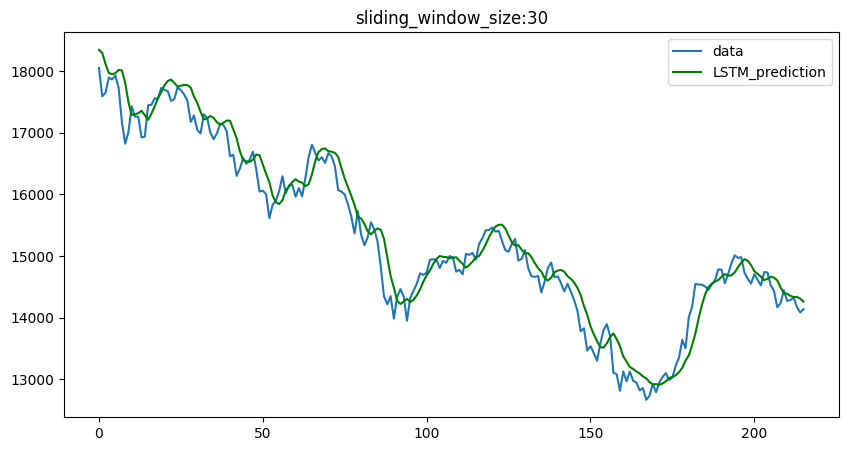

In [254]:
result_1 = LSTM_model(train,test,look_back)

# 利用訓練好的模型對新資料進行預測

In [6]:
def predict_financial(coeff,model_path,old_data_list,date_range_list):

    window_size = 30
    feature_len = 1
    

    
    scaler = MinMaxScaler(feature_range=(0,1))
    test = np.array(coeff[-(window_size+1):])
    test = test[::-1]
    test_scaled_data = scaler.fit_transform(test.reshape(-1,1))
    x_test,y_test = createSlidingWindow(test_scaled_data,window_size)

    vanilla_model = load_model(model_path)
    
    test_predict = vanilla_model.predict(test_scaled_data)
    predict_Close = scaler.inverse_transform(test_predict)
    

    vanilla_model.compile(loss='mse', optimizer='Adam') 
    vanilla_model_history = vanilla_model.fit(x_test,y_test,batch_size=60,epochs=100)

    vanilla_model.save(model_path) 
    
    
    del vanilla_model
  
    print(predict_Close[0][0])
    return predict_Close[0][0]

In [7]:
# 取日期範圍
def datelist(start_date,end_date):
    date_list = []
    start_date = datetime.strptime(start_date, '%Y-%m-%d')  # 起始日期
    end_date = datetime.strptime(end_date, '%Y-%m-%d')    # 结束日期
    current_date = start_date
    while current_date <= end_date:
        date_list.append(current_date.strftime('%Y-%m-%d'))
        current_date += timedelta(days=1)
    return date_list

In [8]:
# 取有資料的日期
def date_with_value(start_day, end_day):
    true_day_value = get_true_value(start_day,end_day)
    predict_datelist = datelist(start_day,end_day)
    predict_df = pd.DataFrame({'Date': predict_datelist})
    execute_time_df = pd.DataFrame({'Date': predict_datelist})
    predict_df = predict_df.set_index('Date')
    execute_time_df = execute_time_df.set_index('Date')
    merged_df = pd.concat([true_day_value, predict_df], axis=1)
    merged_df = pd.concat([merged_df, execute_time_df], axis=1)
    merged_df = merged_df.dropna()
    merged_df = merged_df.reset_index()
    date_range_list = merged_df['Date'].tolist()
    return date_range_list

In [9]:
# 取真實金融資料的dataframe
def get_true_value(start_day,end_day):


    dataframe_Close = yf.download('^TWII',start=start_day,end=end_day)
    dataframe_Close = dataframe_Close['Close']
    dataframe_Close = pd.DataFrame(dataframe_Close)
#     print(dataframe_Close)
    dataframe_Close['Close'] = dataframe_Close['Close'].replace('', np.nan)
    dataframe_Close['Close'] = dataframe_Close['Close'].astype(float)  
    
    dataframe_Close = dataframe_Close.reset_index()
    dataframe_Close['Date'] = dataframe_Close['Date'].astype("string")
    dataframe_Close['Date'] = dataframe_Close['Date'].to_list()
    return dataframe_Close
    # datelist = true_day_value.index

In [27]:
a = get_true_value(start_day_1,end_day_1)

[*********************100%***********************]  1 of 1 completed


In [28]:
a

Date         Close
0    2020-12-28  14483.070312
1    2020-12-29  14472.049805
2    2020-12-30  14687.700195
3    2020-12-31  14732.530273
4    2021-01-04  14902.030273
..          ...           ...
115  2021-06-25  17502.990234
116  2021-06-28  17590.970703
117  2021-06-29  17598.189453
118  2021-06-30  17755.460938
119  2021-07-01  17713.939453

[120 rows x 2 columns]

In [12]:
# 第一個月
start_day_1 = '2020-12-26'
end_day_1 = '2022-06-30'
date_range_list_1 = datelist(start_day_1,end_day_1)

In [13]:
start_day_1 = '2020-12-26'
end_day_1 = '2021-07-02'
date_range_list_1 = datelist(start_day_1,end_day_1)
len(date_range_list_1)

189

In [15]:
start_day_2 = '2021-07-06'
end_day_2 = '2021-12-24'
date_range_list_2 = datelist(start_day_2,end_day_2)
len(date_range_list_2)

172

In [16]:
# 第三個半年
start_day_3 = '2021-12-28'
end_day_3 = '2022-06-30'
date_range_list_3 = datelist(start_day_3,end_day_3)
len(date_range_list_3)

185

In [23]:
c = get_true_value(start_day_3,end_day_3)

[*********************100%***********************]  1 of 1 completed


In [17]:
date_range_list_1 = date_with_value(start_day_1,end_day_1)
len(date_range_list_1)

[*********************100%***********************]  1 of 1 completed


120

In [18]:
date_range_list_2 = date_with_value(start_day_2,end_day_2)
len(date_range_list_2)

[*********************100%***********************]  1 of 1 completed


120

In [19]:
date_range_list_3 = date_with_value(start_day_3,end_day_3)
len(date_range_list_3)

[*********************100%***********************]  1 of 1 completed


119

In [16]:
date_range_list_1

['2020-12-28',
 '2020-12-29',
 '2020-12-30',
 '2020-12-31',
 '2021-01-04',
 '2021-01-05',
 '2021-01-06',
 '2021-01-07',
 '2021-01-08',
 '2021-01-11',
 '2021-01-12',
 '2021-01-13',
 '2021-01-14',
 '2021-01-15',
 '2021-01-18',
 '2021-01-19',
 '2021-01-20',
 '2021-01-21',
 '2021-01-22',
 '2021-01-25',
 '2021-01-26',
 '2021-01-27',
 '2021-01-28',
 '2021-01-29',
 '2021-02-01',
 '2021-02-02',
 '2021-02-03',
 '2021-02-04',
 '2021-02-05',
 '2021-02-17',
 '2021-02-18',
 '2021-02-19',
 '2021-02-22',
 '2021-02-23',
 '2021-02-24',
 '2021-02-25',
 '2021-02-26',
 '2021-03-02',
 '2021-03-03',
 '2021-03-04',
 '2021-03-05',
 '2021-03-08',
 '2021-03-09',
 '2021-03-10',
 '2021-03-11',
 '2021-03-12',
 '2021-03-15',
 '2021-03-16',
 '2021-03-17',
 '2021-03-18',
 '2021-03-19',
 '2021-03-22',
 '2021-03-23',
 '2021-03-24',
 '2021-03-25',
 '2021-03-26',
 '2021-03-29',
 '2021-03-30',
 '2021-03-31',
 '2021-04-01',
 '2021-04-07',
 '2021-04-08',
 '2021-04-09',
 '2021-04-12',
 '2021-04-13',
 '2021-04-14',
 '2021-04-

# 執行預測

In [21]:
def predict_date_range(old_data_list,date_range_list):
    predict_list = []
    execute_time_list = []
    all_time_start = time.time()
    start = time.time()
    predict_result = predict_financial(old_data_list,'./model/univariate-LSTM-model-result-Copy1.h5',old_data_list,date_range_list)

    predict_list.append(predict_result)

    
    end = time.time()
    execute_time_list.append(end - start)
    all_time_end = time.time()
    print("執行時間：%f 秒" % (all_time_end - all_time_start))
    return predict_list

In [30]:
predict_list = []
coeff_predict_list = []
all_time_start = time.time()
# train_coefficient_append = train
for i in range(int(len(date_range_list_1))):
#     print(date_range_list_1[i])
    end_date = datetime.strptime(date_range_list_1[i],'%Y-%m-%d').date()
    start_date = end_date-timedelta(days=60)
    true_dataframe_Close = yf.download('^TWII',start=start_date,end=date_range_list_1[i])
    true_dataframe_Close = true_dataframe_Close['Close']
    true_dataframe_Close = pd.DataFrame(true_dataframe_Close)
    
    true=np.array(true_dataframe_Close.astype('float'))
#     print(true_dataframe_Close)
    predict_value = predict_date_range(true,date_range_list_1[i])
    predict_list.append(predict_value)

all_time_end = time.time()
print("全部執行時間：%f 秒" % (all_time_end - all_time_start))

[*********************100%***********************]  1 of 1 completed
[[[0.9474219 ]
  [0.90163106]
  [0.8504223 ]
  [0.80956495]
  [0.99536207]
  [0.87448201]
  [0.88251358]
  [0.92328174]
  [0.71201884]
  [0.83964156]
  [0.88498557]
  [0.87406142]
  [1.        ]
  [0.97337124]
  [0.88042721]
  [0.76925411]
  [0.63015198]
  [0.64094147]
  [0.54829387]
  [0.40253915]
  [0.53165713]
  [0.51246882]
  [0.41681233]
  [0.47796851]
  [0.54143491]
  [0.39676446]
  [0.40212729]
  [0.44766805]
  [0.28624369]
  [0.24937107]]]
[[0.]]
1/1 [==============================] - 0s 199ms/step
Epoch 1/100
1/1 [==============================] - 1s 920ms/step - loss: 0.0862
Epoch 2/100
1/1 [==============================] - 0s 9ms/step - loss: 0.0799
Epoch 3/100
1/1 [==============================] - 0s 9ms/step - loss: 0.0739
Epoch 4/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0682
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0627
Epoch 6/100
1/1 [==========

1/1 [==============================] - 0s 6ms/step - loss: 1.8463e-07
Epoch 87/100
1/1 [==============================] - 0s 6ms/step - loss: 4.0527e-07
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 6.5154e-07
Epoch 89/100
1/1 [==============================] - 0s 5ms/step - loss: 8.8426e-07
Epoch 90/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0732e-06
Epoch 91/100
1/1 [==============================] - 0s 6ms/step - loss: 1.1989e-06
Epoch 92/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2525e-06
Epoch 93/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2343e-06
Epoch 94/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1526e-06
Epoch 95/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0211e-06
Epoch 96/100
1/1 [==============================] - 0s 5ms/step - loss: 8.5723e-07
Epoch 97/100
1/1 [==============================] - 0s 5ms/step - loss: 6.7871e-07
Epoch 98/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 1.1107e-07
Epoch 70/100
1/1 [==============================] - 0s 6ms/step - loss: 3.8198e-08
Epoch 71/100
1/1 [==============================] - 0s 6ms/step - loss: 1.3956e-09
Epoch 72/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2625e-08
Epoch 73/100
1/1 [==============================] - 0s 6ms/step - loss: 5.2264e-08
Epoch 74/100
1/1 [==============================] - 0s 5ms/step - loss: 8.6831e-08
Epoch 75/100
1/1 [==============================] - 0s 6ms/step - loss: 9.2035e-08
Epoch 76/100
1/1 [==============================] - 0s 6ms/step - loss: 6.6633e-08
Epoch 77/100
1/1 [==============================] - 0s 6ms/step - loss: 2.9496e-08
Epoch 78/100
1/1 [==============================] - 0s 6ms/step - loss: 3.9749e-09
Epoch 79/100
1/1 [==============================] - 0s 6ms/step - loss: 2.1816e-09
Epoch 80/100
1/1 [==============================] - 0s 6ms/step - loss: 1.9005e-08
Epoch 81/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 8.7156e-08
Epoch 52/100
1/1 [==============================] - 0s 5ms/step - loss: 1.9650e-07
Epoch 53/100
1/1 [==============================] - 0s 5ms/step - loss: 1.9605e-07
Epoch 54/100
1/1 [==============================] - 0s 6ms/step - loss: 9.4035e-08
Epoch 55/100
1/1 [==============================] - 0s 6ms/step - loss: 7.7622e-09
Epoch 56/100
1/1 [==============================] - 0s 6ms/step - loss: 1.9030e-08
Epoch 57/100
1/1 [==============================] - 0s 5ms/step - loss: 8.9802e-08
Epoch 58/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2336e-07
Epoch 59/100
1/1 [==============================] - 0s 6ms/step - loss: 8.1544e-08
Epoch 60/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7886e-08
Epoch 61/100
1/1 [==============================] - 0s 6ms/step - loss: 2.2603e-09
Epoch 62/100
1/1 [==============================] - 0s 6ms/step - loss: 3.8660e-08
Epoch 63/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 3.4078e-05
Epoch 35/100
1/1 [==============================] - 0s 5ms/step - loss: 2.5179e-05
Epoch 36/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6534e-05
Epoch 37/100
1/1 [==============================] - 0s 5ms/step - loss: 9.1915e-06
Epoch 38/100
1/1 [==============================] - 0s 6ms/step - loss: 3.8530e-06
Epoch 39/100
1/1 [==============================] - 0s 6ms/step - loss: 8.2189e-07
Epoch 40/100
1/1 [==============================] - 0s 5ms/step - loss: 8.8466e-09
Epoch 41/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0014e-06
Epoch 42/100
1/1 [==============================] - 0s 6ms/step - loss: 3.1739e-06
Epoch 43/100
1/1 [==============================] - 0s 6ms/step - loss: 5.8204e-06
Epoch 44/100
1/1 [==============================] - 0s 6ms/step - loss: 8.2811e-06
Epoch 45/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0046e-05
Epoch 46/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 1.8494e-04
Epoch 17/100
1/1 [==============================] - 0s 6ms/step - loss: 2.2003e-04
Epoch 18/100
1/1 [==============================] - 0s 5ms/step - loss: 2.4097e-04
Epoch 19/100
1/1 [==============================] - 0s 7ms/step - loss: 2.4672e-04
Epoch 20/100
1/1 [==============================] - 0s 6ms/step - loss: 2.3829e-04
Epoch 21/100
1/1 [==============================] - 0s 5ms/step - loss: 2.1807e-04
Epoch 22/100
1/1 [==============================] - 0s 6ms/step - loss: 1.8929e-04
Epoch 23/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5553e-04
Epoch 24/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2027e-04
Epoch 25/100
1/1 [==============================] - 0s 5ms/step - loss: 8.6583e-05
Epoch 26/100
1/1 [==============================] - 0s 6ms/step - loss: 5.6905e-05
Epoch 27/100
1/1 [==============================] - 0s 6ms/step - loss: 3.2916e-05
Epoch 28/100
1/1 

1/1 [==============================] - 0s 180ms/step
Epoch 1/100
1/1 [==============================] - 1s 892ms/step - loss: 0.0041
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0029
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 7/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 7.5639e-04
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 5.1125e-04
Epoch 10/100
1/1 [==============================] - 0s 6ms/step - loss: 3.1967e-04
Epoch 11/100
1/1 [==============================] - 0s 6ms/step - loss: 1.7795e-04
Epoch 12/100
1/1 [==============================] - 0s 5ms/step - los

1/1 [==============================] - 0s 7ms/step - loss: 3.2165e-09
Epoch 91/100
1/1 [==============================] - 0s 6ms/step - loss: 9.1502e-12
Epoch 92/100
1/1 [==============================] - 0s 6ms/step - loss: 2.1201e-09
Epoch 93/100
1/1 [==============================] - 0s 6ms/step - loss: 6.8272e-09
Epoch 94/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0326e-08
Epoch 95/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0252e-08
Epoch 96/100
1/1 [==============================] - 0s 6ms/step - loss: 6.9496e-09
Epoch 97/100
1/1 [==============================] - 0s 5ms/step - loss: 2.7692e-09
Epoch 98/100
1/1 [==============================] - 0s 6ms/step - loss: 2.4225e-10
Epoch 99/100
1/1 [==============================] - 0s 6ms/step - loss: 4.2655e-10
Epoch 100/100
1/1 [==============================] - 0s 5ms/step - loss: 2.4830e-09
15324.258
執行時間：1.865299 秒
[*********************100%***********************]  1 of 1 completed
[[[0

1/1 [==============================] - 0s 6ms/step - loss: 3.4445e-08
Epoch 73/100
1/1 [==============================] - 0s 6ms/step - loss: 2.4169e-08
Epoch 74/100
1/1 [==============================] - 0s 5ms/step - loss: 7.3069e-09
Epoch 75/100
1/1 [==============================] - 0s 5ms/step - loss: 2.6624e-12
Epoch 76/100
1/1 [==============================] - 0s 6ms/step - loss: 6.4222e-09
Epoch 77/100
1/1 [==============================] - 0s 6ms/step - loss: 1.6581e-08
Epoch 78/100
1/1 [==============================] - 0s 7ms/step - loss: 1.8627e-08
Epoch 79/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0960e-08
Epoch 80/100
1/1 [==============================] - 0s 6ms/step - loss: 2.1153e-09
Epoch 81/100
1/1 [==============================] - 0s 6ms/step - loss: 4.1767e-10
Epoch 82/100
1/1 [==============================] - 0s 5ms/step - loss: 5.5789e-09
Epoch 83/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0420e-08
Epoch 84/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 5.0815e-06
Epoch 55/100
1/1 [==============================] - 0s 5ms/step - loss: 6.0374e-06
Epoch 56/100
1/1 [==============================] - 0s 6ms/step - loss: 6.5234e-06
Epoch 57/100
1/1 [==============================] - 0s 6ms/step - loss: 6.5058e-06
Epoch 58/100
1/1 [==============================] - 0s 6ms/step - loss: 6.0293e-06
Epoch 59/100
1/1 [==============================] - 0s 5ms/step - loss: 5.1966e-06
Epoch 60/100
1/1 [==============================] - 0s 6ms/step - loss: 4.1469e-06
Epoch 61/100
1/1 [==============================] - 0s 6ms/step - loss: 3.0287e-06
Epoch 62/100
1/1 [==============================] - 0s 6ms/step - loss: 1.9796e-06
Epoch 63/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1059e-06
Epoch 64/100
1/1 [==============================] - 0s 5ms/step - loss: 4.7562e-07
Epoch 65/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1223e-07
Epoch 66/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 8.7017e-07
Epoch 37/100
1/1 [==============================] - 0s 6ms/step - loss: 6.1488e-07
Epoch 38/100
1/1 [==============================] - 0s 6ms/step - loss: 2.0210e-07
Epoch 39/100
1/1 [==============================] - 0s 5ms/step - loss: 8.7050e-10
Epoch 40/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2997e-07
Epoch 41/100
1/1 [==============================] - 0s 5ms/step - loss: 3.8509e-07
Epoch 42/100
1/1 [==============================] - 0s 6ms/step - loss: 4.7919e-07
Epoch 43/100
1/1 [==============================] - 0s 6ms/step - loss: 3.2713e-07
Epoch 44/100
1/1 [==============================] - 0s 6ms/step - loss: 9.4731e-08
Epoch 45/100
1/1 [==============================] - 0s 6ms/step - loss: 2.8003e-10
Epoch 46/100
1/1 [==============================] - 0s 6ms/step - loss: 9.4437e-08
Epoch 47/100
1/1 [==============================] - 0s 6ms/step - loss: 2.3572e-07
Epoch 48/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 2.7100e-06
Epoch 19/100
1/1 [==============================] - 0s 5ms/step - loss: 5.4273e-06
Epoch 20/100
1/1 [==============================] - 0s 6ms/step - loss: 6.5516e-06
Epoch 21/100
1/1 [==============================] - 0s 5ms/step - loss: 5.4931e-06
Epoch 22/100
1/1 [==============================] - 0s 5ms/step - loss: 3.1044e-06
Epoch 23/100
1/1 [==============================] - 0s 5ms/step - loss: 8.8920e-07
Epoch 24/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6634e-09
Epoch 25/100
1/1 [==============================] - 0s 5ms/step - loss: 6.1982e-07
Epoch 26/100
1/1 [==============================] - 0s 5ms/step - loss: 1.9757e-06
Epoch 27/100
1/1 [==============================] - 0s 6ms/step - loss: 2.9733e-06
Epoch 28/100
1/1 [==============================] - 0s 6ms/step - loss: 2.9364e-06
Epoch 29/100
1/1 [==============================] - 0s 5ms/step - loss: 1.9713e-06
Epoch 30/100
1/1 

1/1 [==============================] - 0s 185ms/step
Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.0042
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0029
Epoch 4/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 7/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 8/100
1/1 [==============================] - 0s 6ms/step - loss: 7.9808e-04
Epoch 9/100
1/1 [==============================] - 0s 6ms/step - loss: 5.4810e-04
Epoch 10/100
1/1 [==============================] - 0s 6ms/step - loss: 3.5090e-04
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 2.0283e-04
Epoch 12/100
1/1 [==============================] - 0s 6ms/step - loss: 

1/1 [==============================] - 0s 5ms/step - loss: 9.5604e-10
Epoch 91/100
1/1 [==============================] - 0s 6ms/step - loss: 4.1113e-09
Epoch 92/100
1/1 [==============================] - 0s 6ms/step - loss: 2.1870e-08
Epoch 93/100
1/1 [==============================] - 0s 5ms/step - loss: 4.7633e-08
Epoch 94/100
1/1 [==============================] - 0s 6ms/step - loss: 7.4910e-08
Epoch 95/100
1/1 [==============================] - 0s 5ms/step - loss: 9.8295e-08
Epoch 96/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1410e-07
Epoch 97/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2034e-07
Epoch 98/100
1/1 [==============================] - 0s 6ms/step - loss: 1.1678e-07
Epoch 99/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0495e-07
Epoch 100/100
1/1 [==============================] - 0s 6ms/step - loss: 8.7240e-08
15294.311
執行時間：1.905653 秒
[*********************100%***********************]  1 of 1 completed
[[[0

1/1 [==============================] - 0s 5ms/step - loss: 4.1405e-08
Epoch 73/100
1/1 [==============================] - 0s 6ms/step - loss: 2.7580e-08
Epoch 74/100
1/1 [==============================] - 0s 5ms/step - loss: 8.8339e-09
Epoch 75/100
1/1 [==============================] - 0s 6ms/step - loss: 4.4565e-11
Epoch 76/100
1/1 [==============================] - 0s 6ms/step - loss: 5.4604e-09
Epoch 77/100
1/1 [==============================] - 0s 6ms/step - loss: 1.6795e-08
Epoch 78/100
1/1 [==============================] - 0s 6ms/step - loss: 2.2293e-08
Epoch 79/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7301e-08
Epoch 80/100
1/1 [==============================] - 0s 6ms/step - loss: 7.0219e-09
Epoch 81/100
1/1 [==============================] - 0s 6ms/step - loss: 4.1100e-10
Epoch 82/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7764e-09
Epoch 83/100
1/1 [==============================] - 0s 6ms/step - loss: 7.8213e-09
Epoch 84/100
1/1 

Epoch 64/100
1/1 [==============================] - 0s 6ms/step - loss: 2.7666e-06
Epoch 65/100
1/1 [==============================] - 0s 6ms/step - loss: 1.6746e-06
Epoch 66/100
1/1 [==============================] - 0s 6ms/step - loss: 8.6900e-07
Epoch 67/100
1/1 [==============================] - 0s 5ms/step - loss: 3.4142e-07
Epoch 68/100
1/1 [==============================] - 0s 5ms/step - loss: 6.5751e-08
Epoch 69/100
1/1 [==============================] - 0s 5ms/step - loss: 2.1518e-09
Epoch 70/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0243e-07
Epoch 71/100
1/1 [==============================] - 0s 6ms/step - loss: 3.1508e-07
Epoch 72/100
1/1 [==============================] - 0s 5ms/step - loss: 5.8962e-07
Epoch 73/100
1/1 [==============================] - 0s 5ms/step - loss: 8.8062e-07
Epoch 74/100
1/1 [==============================] - 0s 6ms/step - loss: 1.1497e-06
Epoch 75/100
1/1 [==============================] - 0s 5ms/step - loss: 1.3684e-06
Epoc

1/1 [==============================] - 0s 6ms/step - loss: 1.0626e-05
Epoch 57/100
1/1 [==============================] - 0s 6ms/step - loss: 1.1801e-05
Epoch 58/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2510e-05
Epoch 59/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2744e-05
Epoch 60/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2526e-05
Epoch 61/100
1/1 [==============================] - 0s 6ms/step - loss: 1.1909e-05
Epoch 62/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0967e-05
Epoch 63/100
1/1 [==============================] - 0s 5ms/step - loss: 9.7818e-06
Epoch 64/100
1/1 [==============================] - 0s 6ms/step - loss: 8.4450e-06
Epoch 65/100
1/1 [==============================] - 0s 5ms/step - loss: 7.0409e-06
Epoch 66/100
1/1 [==============================] - 0s 5ms/step - loss: 5.6512e-06
Epoch 67/100
1/1 [==============================] - 0s 6ms/step - loss: 4.3425e-06
Epoch 68/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 7.5913e-08
Epoch 39/100
1/1 [==============================] - 0s 5ms/step - loss: 4.9654e-08
Epoch 40/100
1/1 [==============================] - 0s 5ms/step - loss: 4.1768e-07
Epoch 41/100
1/1 [==============================] - 0s 6ms/step - loss: 8.9072e-07
Epoch 42/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1780e-06
Epoch 43/100
1/1 [==============================] - 0s 6ms/step - loss: 1.1329e-06
Epoch 44/100
1/1 [==============================] - 0s 5ms/step - loss: 8.0467e-07
Epoch 45/100
1/1 [==============================] - 0s 5ms/step - loss: 3.8295e-07
Epoch 46/100
1/1 [==============================] - 0s 5ms/step - loss: 7.7116e-08
Epoch 47/100
1/1 [==============================] - 0s 5ms/step - loss: 5.2511e-09
Epoch 48/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4477e-07
Epoch 49/100
1/1 [==============================] - 0s 5ms/step - loss: 3.6558e-07
Epoch 50/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 6.6300e-05
Epoch 21/100
1/1 [==============================] - 0s 5ms/step - loss: 4.5402e-05
Epoch 22/100
1/1 [==============================] - 0s 6ms/step - loss: 2.7399e-05
Epoch 23/100
1/1 [==============================] - 0s 5ms/step - loss: 1.3602e-05
Epoch 24/100
1/1 [==============================] - 0s 5ms/step - loss: 4.6348e-06
Epoch 25/100
1/1 [==============================] - 0s 6ms/step - loss: 4.6135e-07
Epoch 26/100
1/1 [==============================] - 0s 5ms/step - loss: 4.7213e-07
Epoch 27/100
1/1 [==============================] - 0s 5ms/step - loss: 3.6334e-06
Epoch 28/100
1/1 [==============================] - 0s 6ms/step - loss: 8.6751e-06
Epoch 29/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4293e-05
Epoch 30/100
1/1 [==============================] - 0s 6ms/step - loss: 1.9331e-05
Epoch 31/100
1/1 [==============================] - 0s 5ms/step - loss: 2.2928e-05
Epoch 32/100
1/1 

1/1 [==============================] - 0s 8ms/step - loss: 7.6003e-04
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 5.0938e-04
Epoch 4/100
1/1 [==============================] - 0s 6ms/step - loss: 3.1281e-04
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 1.6822e-04
Epoch 6/100
1/1 [==============================] - 0s 6ms/step - loss: 7.1887e-05
Epoch 7/100
1/1 [==============================] - 0s 7ms/step - loss: 1.8333e-05
Epoch 8/100
1/1 [==============================] - 0s 6ms/step - loss: 2.0797e-07
Epoch 9/100
1/1 [==============================] - 0s 6ms/step - loss: 8.5250e-06
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 3.3352e-05
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 6.4937e-05
Epoch 12/100
1/1 [==============================] - 0s 6ms/step - loss: 9.4978e-05
Epoch 13/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1759e-04
Epoch 14/100
1/1 [======

1/1 [==============================] - 0s 6ms/step - loss: 2.9853e-08
Epoch 92/100
1/1 [==============================] - 0s 6ms/step - loss: 1.4749e-08
Epoch 93/100
1/1 [==============================] - 0s 5ms/step - loss: 4.1804e-09
Epoch 94/100
1/1 [==============================] - 0s 6ms/step - loss: 6.2137e-11
Epoch 95/100
1/1 [==============================] - 0s 5ms/step - loss: 1.9573e-09
Epoch 96/100
1/1 [==============================] - 0s 5ms/step - loss: 7.6627e-09
Epoch 97/100
1/1 [==============================] - 0s 6ms/step - loss: 1.4234e-08
Epoch 98/100
1/1 [==============================] - 0s 5ms/step - loss: 1.8933e-08
Epoch 99/100
1/1 [==============================] - 0s 6ms/step - loss: 2.0207e-08
Epoch 100/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7944e-08
16007.515
執行時間：2.150853 秒
[*********************100%***********************]  1 of 1 completed
[[[0.8502176 ]
  [1.        ]
  [0.97843462]
  [0.9338118 ]
  [0.98774426]
  [0.9473777

1/1 [==============================] - 0s 6ms/step - loss: 4.6935e-07
Epoch 75/100
1/1 [==============================] - 0s 6ms/step - loss: 2.1678e-07
Epoch 76/100
1/1 [==============================] - 0s 5ms/step - loss: 6.6868e-08
Epoch 77/100
1/1 [==============================] - 0s 5ms/step - loss: 4.3942e-09
Epoch 78/100
1/1 [==============================] - 0s 6ms/step - loss: 1.1906e-08
Epoch 79/100
1/1 [==============================] - 0s 6ms/step - loss: 7.0768e-08
Epoch 80/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6271e-07
Epoch 81/100
1/1 [==============================] - 0s 6ms/step - loss: 2.7083e-07
Epoch 82/100
1/1 [==============================] - 0s 7ms/step - loss: 3.8064e-07
Epoch 83/100
1/1 [==============================] - 0s 6ms/step - loss: 4.8020e-07
Epoch 84/100
1/1 [==============================] - 0s 5ms/step - loss: 5.6084e-07
Epoch 85/100
1/1 [==============================] - 0s 5ms/step - loss: 6.1711e-07
Epoch 86/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 4.4404e-07
Epoch 57/100
1/1 [==============================] - 0s 6ms/step - loss: 8.4855e-07
Epoch 58/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2185e-06
Epoch 59/100
1/1 [==============================] - 0s 6ms/step - loss: 1.4665e-06
Epoch 60/100
1/1 [==============================] - 0s 6ms/step - loss: 1.5457e-06
Epoch 61/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4531e-06
Epoch 62/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2220e-06
Epoch 63/100
1/1 [==============================] - 0s 5ms/step - loss: 9.1006e-07
Epoch 64/100
1/1 [==============================] - 0s 5ms/step - loss: 5.8324e-07
Epoch 65/100
1/1 [==============================] - 0s 6ms/step - loss: 3.0087e-07
Epoch 66/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0393e-07
Epoch 67/100
1/1 [==============================] - 0s 6ms/step - loss: 9.7958e-09
Epoch 68/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 6.2957e-04
Epoch 41/100
1/1 [==============================] - 0s 5ms/step - loss: 6.2541e-04
Epoch 42/100
1/1 [==============================] - 0s 5ms/step - loss: 6.0343e-04
Epoch 43/100
1/1 [==============================] - 0s 6ms/step - loss: 5.6648e-04
Epoch 44/100
1/1 [==============================] - 0s 6ms/step - loss: 5.1790e-04
Epoch 45/100
1/1 [==============================] - 0s 5ms/step - loss: 4.6127e-04
Epoch 46/100
1/1 [==============================] - 0s 5ms/step - loss: 4.0007e-04
Epoch 47/100
1/1 [==============================] - 0s 6ms/step - loss: 3.3755e-04
Epoch 48/100
1/1 [==============================] - 0s 5ms/step - loss: 2.7651e-04
Epoch 49/100
1/1 [==============================] - 0s 5ms/step - loss: 2.1926e-04
Epoch 50/100
1/1 [==============================] - 0s 6ms/step - loss: 1.6754e-04
Epoch 51/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2252e-04
Epoch 52/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 0.0055
Epoch 34/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0048
Epoch 35/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 36/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0036
Epoch 37/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0031
Epoch 38/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 39/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 40/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 41/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 42/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 43/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 44/100
1/1 [==============================] - 0s 5ms/step - loss: 8.3952e-04
Epoch 45/100
1/1 [==============================] - 0s 5ms/st

1/1 [==============================] - 0s 6ms/step - loss: 3.6893e-05
Epoch 18/100
1/1 [==============================] - 0s 5ms/step - loss: 2.0589e-05
Epoch 19/100
1/1 [==============================] - 0s 5ms/step - loss: 6.8627e-06
Epoch 20/100
1/1 [==============================] - 0s 5ms/step - loss: 3.2415e-07
Epoch 21/100
1/1 [==============================] - 0s 6ms/step - loss: 1.8627e-06
Epoch 22/100
1/1 [==============================] - 0s 5ms/step - loss: 8.7563e-06
Epoch 23/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6356e-05
Epoch 24/100
1/1 [==============================] - 0s 5ms/step - loss: 2.0508e-05
Epoch 25/100
1/1 [==============================] - 0s 6ms/step - loss: 1.9410e-05
Epoch 26/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4037e-05
Epoch 27/100
1/1 [==============================] - 0s 6ms/step - loss: 7.1845e-06
Epoch 28/100
1/1 [==============================] - 0s 6ms/step - loss: 1.8870e-06
Epoch 29/100
1/1 

1/1 [==============================] - 0s 187ms/step
Epoch 1/100
1/1 [==============================] - 1s 901ms/step - loss: 0.0309
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0280
Epoch 3/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0252
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0226
Epoch 5/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0202
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0179
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0158
Epoch 8/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0138
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0119
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0103
Epoch 11/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0087
Epoch 12/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0073
Epoch 

1/1 [==============================] - 0s 6ms/step - loss: 9.5589e-07
16095.933
執行時間：1.886035 秒
[*********************100%***********************]  1 of 1 completed
[[[0.85006128]
  [0.79250604]
  [0.58861248]
  [0.54402659]
  [0.51892556]
  [0.54565584]
  [0.58460922]
  [0.81699164]
  [0.61541114]
  [0.62067797]
  [1.        ]
  [0.81760038]
  [0.99331799]
  [0.9680185 ]
  [0.91566913]
  [0.97894014]
  [0.93158407]
  [0.50544632]
  [0.43224224]
  [0.48179096]
  [0.47321286]
  [0.20685475]
  [0.        ]
  [0.21126161]
  [0.4286121 ]
  [0.39618835]
  [0.61515249]
  [0.67032555]
  [0.77287697]
  [0.50832279]]]
[[0.56250655]]
1/1 [==============================] - 0s 187ms/step
Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.1076
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 0.1019
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0963
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0909
Epoc

1/1 [==============================] - 0s 6ms/step - loss: 2.4563e-07
Epoch 87/100
1/1 [==============================] - 0s 6ms/step - loss: 2.3998e-08
Epoch 88/100
1/1 [==============================] - 0s 6ms/step - loss: 2.3943e-08
Epoch 89/100
1/1 [==============================] - 0s 6ms/step - loss: 1.8782e-07
Epoch 90/100
1/1 [==============================] - 0s 6ms/step - loss: 4.6455e-07
Epoch 91/100
1/1 [==============================] - 0s 5ms/step - loss: 8.1005e-07
Epoch 92/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1861e-06
Epoch 93/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5629e-06
Epoch 94/100
1/1 [==============================] - 0s 6ms/step - loss: 1.9157e-06
Epoch 95/100
1/1 [==============================] - 0s 6ms/step - loss: 2.2272e-06
Epoch 96/100
1/1 [==============================] - 0s 5ms/step - loss: 2.4844e-06
Epoch 97/100
1/1 [==============================] - 0s 6ms/step - loss: 2.6795e-06
Epoch 98/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 4.2168e-05
Epoch 81/100
1/1 [==============================] - 0s 5ms/step - loss: 4.3778e-05
Epoch 82/100
1/1 [==============================] - 0s 5ms/step - loss: 4.4717e-05
Epoch 83/100
1/1 [==============================] - 0s 5ms/step - loss: 4.5022e-05
Epoch 84/100
1/1 [==============================] - 0s 5ms/step - loss: 4.4738e-05
Epoch 85/100
1/1 [==============================] - 0s 6ms/step - loss: 4.3931e-05
Epoch 86/100
1/1 [==============================] - 0s 5ms/step - loss: 4.2658e-05
Epoch 87/100
1/1 [==============================] - 0s 5ms/step - loss: 4.0996e-05
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 3.9009e-05
Epoch 89/100
1/1 [==============================] - 0s 6ms/step - loss: 3.6771e-05
Epoch 90/100
1/1 [==============================] - 0s 5ms/step - loss: 3.4343e-05
Epoch 91/100
1/1 [==============================] - 0s 5ms/step - loss: 3.1793e-05
Epoch 92/100
1/1 

1/1 [==============================] - 0s 7ms/step - loss: 3.9647e-05
Epoch 64/100
1/1 [==============================] - 0s 8ms/step - loss: 3.3291e-05
Epoch 65/100
1/1 [==============================] - 0s 7ms/step - loss: 2.6886e-05
Epoch 66/100
1/1 [==============================] - 0s 7ms/step - loss: 2.0775e-05
Epoch 67/100
1/1 [==============================] - 0s 6ms/step - loss: 1.5234e-05
Epoch 68/100
1/1 [==============================] - 0s 7ms/step - loss: 1.0460e-05
Epoch 69/100
1/1 [==============================] - 0s 7ms/step - loss: 6.5818e-06
Epoch 70/100
1/1 [==============================] - 0s 7ms/step - loss: 3.6446e-06
Epoch 71/100
1/1 [==============================] - 0s 7ms/step - loss: 1.6288e-06
Epoch 72/100
1/1 [==============================] - 0s 6ms/step - loss: 4.5831e-07
Epoch 73/100
1/1 [==============================] - 0s 6ms/step - loss: 1.4425e-08
Epoch 74/100
1/1 [==============================] - 0s 6ms/step - loss: 1.5015e-07
Epoch 75/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 1.1658e-07
Epoch 49/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2360e-06
Epoch 50/100
1/1 [==============================] - 0s 6ms/step - loss: 5.8091e-06
Epoch 51/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2572e-05
Epoch 52/100
1/1 [==============================] - 0s 6ms/step - loss: 2.0375e-05
Epoch 53/100
1/1 [==============================] - 0s 6ms/step - loss: 2.8225e-05
Epoch 54/100
1/1 [==============================] - 0s 5ms/step - loss: 3.5327e-05
Epoch 55/100
1/1 [==============================] - 0s 6ms/step - loss: 4.1094e-05
Epoch 56/100
1/1 [==============================] - 0s 6ms/step - loss: 4.5152e-05
Epoch 57/100
1/1 [==============================] - 0s 6ms/step - loss: 4.7316e-05
Epoch 58/100
1/1 [==============================] - 0s 6ms/step - loss: 4.7586e-05
Epoch 59/100
1/1 [==============================] - 0s 6ms/step - loss: 4.6099e-05
Epoch 60/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 0.0182
Epoch 33/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0165
Epoch 34/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0149
Epoch 35/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0134
Epoch 36/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0121
Epoch 37/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0108
Epoch 38/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 39/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0086
Epoch 40/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0076
Epoch 41/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0067
Epoch 42/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0059
Epoch 43/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 44/100
1/1 [==============================] - 0s 6ms/step -

1/1 [==============================] - 0s 6ms/step - loss: 2.2609e-04
Epoch 17/100
1/1 [==============================] - 0s 6ms/step - loss: 3.0228e-04
Epoch 18/100
1/1 [==============================] - 0s 6ms/step - loss: 3.6275e-04
Epoch 19/100
1/1 [==============================] - 0s 5ms/step - loss: 4.0162e-04
Epoch 20/100
1/1 [==============================] - 0s 6ms/step - loss: 4.1664e-04
Epoch 21/100
1/1 [==============================] - 0s 6ms/step - loss: 4.0867e-04
Epoch 22/100
1/1 [==============================] - 0s 6ms/step - loss: 3.8091e-04
Epoch 23/100
1/1 [==============================] - 0s 6ms/step - loss: 3.3800e-04
Epoch 24/100
1/1 [==============================] - 0s 5ms/step - loss: 2.8535e-04
Epoch 25/100
1/1 [==============================] - 0s 5ms/step - loss: 2.2837e-04
Epoch 26/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7200e-04
Epoch 27/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2036e-04
Epoch 28/100
1/1 

1/1 [==============================] - 0s 196ms/step
Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.0123
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0103
Epoch 3/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0085
Epoch 4/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0068
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0054
Epoch 6/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0041
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0030
Epoch 8/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 9/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 10/100
1/1 [==============================] - 0s 6ms/step - loss: 8.5435e-04
Epoch 11/100
1/1 [==============================] - 0s 6ms/step - loss: 4.5004e-04
Epoch 12/100
1/1 [==============================] - 0s 6ms/step - loss: 1.8540e-

1/1 [==============================] - 0s 6ms/step - loss: 1.8981e-05
Epoch 95/100
1/1 [==============================] - 0s 6ms/step - loss: 5.5059e-06
Epoch 96/100
1/1 [==============================] - 0s 6ms/step - loss: 2.5286e-07
Epoch 97/100
1/1 [==============================] - 0s 6ms/step - loss: 1.3826e-06
Epoch 98/100
1/1 [==============================] - 0s 5ms/step - loss: 7.2447e-06
Epoch 99/100
1/1 [==============================] - 0s 6ms/step - loss: 1.6386e-05
Epoch 100/100
1/1 [==============================] - 0s 5ms/step - loss: 2.7542e-05
16339.087
執行時間：1.890696 秒
[*********************100%***********************]  1 of 1 completed
[[[1.        ]
  [0.81342621]
  [0.97819544]
  [0.87311963]
  [0.64668479]
  [0.31954103]
  [0.28223979]
  [0.47589759]
  [0.49137997]
  [0.33298752]
  [0.62266884]
  [0.52679223]
  [0.65637671]
  [0.57140238]
  [0.57918973]
  [0.47851981]
  [0.12188945]
  [0.04390423]
  [0.        ]
  [0.04675395]
  [0.11488734]
  [0.52134759]
  [0.1

1/1 [==============================] - 0s 5ms/step - loss: 1.2305e-05
Epoch 83/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0841e-05
Epoch 84/100
1/1 [==============================] - 0s 6ms/step - loss: 9.3332e-06
Epoch 85/100
1/1 [==============================] - 0s 6ms/step - loss: 7.8416e-06
Epoch 86/100
1/1 [==============================] - 0s 5ms/step - loss: 6.4150e-06
Epoch 87/100
1/1 [==============================] - 0s 6ms/step - loss: 5.0953e-06
Epoch 88/100
1/1 [==============================] - 0s 6ms/step - loss: 3.9117e-06
Epoch 89/100
1/1 [==============================] - 0s 6ms/step - loss: 2.8843e-06
Epoch 90/100
1/1 [==============================] - 0s 6ms/step - loss: 2.0241e-06
Epoch 91/100
1/1 [==============================] - 0s 6ms/step - loss: 1.3313e-06
Epoch 92/100
1/1 [==============================] - 0s 6ms/step - loss: 8.0032e-07
Epoch 93/100
1/1 [==============================] - 0s 7ms/step - loss: 4.1970e-07
Epoch 94/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 7.1661e-06
Epoch 65/100
1/1 [==============================] - 0s 6ms/step - loss: 6.2837e-06
Epoch 66/100
1/1 [==============================] - 0s 6ms/step - loss: 5.1685e-06
Epoch 67/100
1/1 [==============================] - 0s 6ms/step - loss: 3.9588e-06
Epoch 68/100
1/1 [==============================] - 0s 7ms/step - loss: 2.7845e-06
Epoch 69/100
1/1 [==============================] - 0s 6ms/step - loss: 1.7523e-06
Epoch 70/100
1/1 [==============================] - 0s 7ms/step - loss: 9.3721e-07
Epoch 71/100
1/1 [==============================] - 0s 6ms/step - loss: 3.7713e-07
Epoch 72/100
1/1 [==============================] - 0s 6ms/step - loss: 7.4556e-08
Epoch 73/100
1/1 [==============================] - 0s 6ms/step - loss: 2.0359e-09
Epoch 74/100
1/1 [==============================] - 0s 6ms/step - loss: 1.1022e-07
Epoch 75/100
1/1 [==============================] - 0s 6ms/step - loss: 3.3738e-07
Epoch 76/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 8.8058e-04
Epoch 51/100
1/1 [==============================] - 0s 5ms/step - loss: 7.3308e-04
Epoch 52/100
1/1 [==============================] - 0s 6ms/step - loss: 6.0507e-04
Epoch 53/100
1/1 [==============================] - 0s 6ms/step - loss: 4.9466e-04
Epoch 54/100
1/1 [==============================] - 0s 6ms/step - loss: 4.0010e-04
Epoch 55/100
1/1 [==============================] - 0s 6ms/step - loss: 3.1971e-04
Epoch 56/100
1/1 [==============================] - 0s 5ms/step - loss: 2.5195e-04
Epoch 57/100
1/1 [==============================] - 0s 6ms/step - loss: 1.9538e-04
Epoch 58/100
1/1 [==============================] - 0s 6ms/step - loss: 1.4867e-04
Epoch 59/100
1/1 [==============================] - 0s 6ms/step - loss: 1.1059e-04
Epoch 60/100
1/1 [==============================] - 0s 6ms/step - loss: 7.9997e-05
Epoch 61/100
1/1 [==============================] - 0s 6ms/step - loss: 5.5877e-05
Epoch 62/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 0.0480
Epoch 39/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0458
Epoch 40/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0437
Epoch 41/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0417
Epoch 42/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0398
Epoch 43/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0379
Epoch 44/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0362
Epoch 45/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0344
Epoch 46/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0328
Epoch 47/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0312
Epoch 48/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0297
Epoch 49/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0282
Epoch 50/100
1/1 [==============================] - 0s 6ms/step -

1/1 [==============================] - 0s 7ms/step - loss: 0.0021
Epoch 25/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 26/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 27/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 28/100
1/1 [==============================] - 0s 5ms/step - loss: 7.4972e-04
Epoch 29/100
1/1 [==============================] - 0s 6ms/step - loss: 5.3519e-04
Epoch 30/100
1/1 [==============================] - 0s 6ms/step - loss: 3.6410e-04
Epoch 31/100
1/1 [==============================] - 0s 6ms/step - loss: 2.3199e-04
Epoch 32/100
1/1 [==============================] - 0s 6ms/step - loss: 1.3440e-04
Epoch 33/100
1/1 [==============================] - 0s 6ms/step - loss: 6.6818e-05
Epoch 34/100
1/1 [==============================] - 0s 7ms/step - loss: 2.4825e-05
Epoch 35/100
1/1 [==============================] - 0s 6ms/step - loss: 4.0949e-06
Epoch 36/100
1/1 [===============

1/1 [==============================] - 0s 7ms/step - loss: 6.3154e-05
Epoch 9/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0817e-05
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 9.2118e-07
Epoch 11/100
1/1 [==============================] - 0s 6ms/step - loss: 2.2295e-05
Epoch 12/100
1/1 [==============================] - 0s 6ms/step - loss: 6.2860e-05
Epoch 13/100
1/1 [==============================] - 0s 7ms/step - loss: 1.1087e-04
Epoch 14/100
1/1 [==============================] - 0s 6ms/step - loss: 1.5620e-04
Epoch 15/100
1/1 [==============================] - 0s 6ms/step - loss: 1.9141e-04
Epoch 16/100
1/1 [==============================] - 0s 6ms/step - loss: 2.1219e-04
Epoch 17/100
1/1 [==============================] - 0s 5ms/step - loss: 2.1721e-04
Epoch 18/100
1/1 [==============================] - 0s 6ms/step - loss: 2.0759e-04
Epoch 19/100
1/1 [==============================] - 0s 6ms/step - loss: 1.8615e-04
Epoch 20/100
1/1 [

1/1 [==============================] - 0s 184ms/step
Epoch 1/100
1/1 [==============================] - 1s 909ms/step - loss: 0.0011
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 8.0774e-04
Epoch 3/100
1/1 [==============================] - 0s 7ms/step - loss: 5.2773e-04
Epoch 4/100
1/1 [==============================] - 0s 6ms/step - loss: 3.0991e-04
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 1.5331e-04
Epoch 6/100
1/1 [==============================] - 0s 6ms/step - loss: 5.4585e-05
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 7.4314e-06
Epoch 8/100
1/1 [==============================] - 0s 6ms/step - loss: 2.2082e-06
Epoch 9/100
1/1 [==============================] - 0s 6ms/step - loss: 2.6277e-05
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 6.5428e-05
Epoch 11/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0621e-04
Epoch 12/100
1/1 [===========================

1/1 [==============================] - 0s 6ms/step - loss: 2.5352e-09
Epoch 91/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2641e-09
Epoch 92/100
1/1 [==============================] - 0s 6ms/step - loss: 4.3773e-11
Epoch 93/100
1/1 [==============================] - 0s 6ms/step - loss: 5.0561e-10
Epoch 94/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5068e-09
Epoch 95/100
1/1 [==============================] - 0s 6ms/step - loss: 1.3339e-09
Epoch 96/100
1/1 [==============================] - 0s 5ms/step - loss: 3.2563e-10
Epoch 97/100
1/1 [==============================] - 0s 7ms/step - loss: 4.4764e-11
Epoch 98/100
1/1 [==============================] - 0s 5ms/step - loss: 6.7691e-10
Epoch 99/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0150e-09
Epoch 100/100
1/1 [==============================] - 0s 6ms/step - loss: 5.0897e-10
17170.791
執行時間：1.902183 秒
[*********************100%***********************]  1 of 1 completed
[[[1

1/1 [==============================] - 0s 6ms/step - loss: 2.6647e-06
Epoch 74/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6883e-06
Epoch 75/100
1/1 [==============================] - 0s 9ms/step - loss: 9.5023e-07
Epoch 76/100
1/1 [==============================] - 0s 5ms/step - loss: 4.4019e-07
Epoch 77/100
1/1 [==============================] - 0s 6ms/step - loss: 1.3649e-07
Epoch 78/100
1/1 [==============================] - 0s 6ms/step - loss: 9.3036e-09
Epoch 79/100
1/1 [==============================] - 0s 8ms/step - loss: 2.3319e-08
Epoch 80/100
1/1 [==============================] - 0s 7ms/step - loss: 1.4111e-07
Epoch 81/100
1/1 [==============================] - 0s 8ms/step - loss: 3.2595e-07
Epoch 82/100
1/1 [==============================] - 0s 6ms/step - loss: 5.4375e-07
Epoch 83/100
1/1 [==============================] - 0s 5ms/step - loss: 7.6471e-07
Epoch 84/100
1/1 [==============================] - 0s 6ms/step - loss: 9.6518e-07
Epoch 85/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 6.8593e-09
Epoch 56/100
1/1 [==============================] - 0s 6ms/step - loss: 6.4541e-08
Epoch 57/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0688e-07
Epoch 58/100
1/1 [==============================] - 0s 5ms/step - loss: 8.1761e-08
Epoch 59/100
1/1 [==============================] - 0s 6ms/step - loss: 2.3781e-08
Epoch 60/100
1/1 [==============================] - 0s 5ms/step - loss: 2.7903e-10
Epoch 61/100
1/1 [==============================] - 0s 5ms/step - loss: 2.7640e-08
Epoch 62/100
1/1 [==============================] - 0s 7ms/step - loss: 6.0334e-08
Epoch 63/100
1/1 [==============================] - 0s 6ms/step - loss: 5.4606e-08
Epoch 64/100
1/1 [==============================] - 0s 6ms/step - loss: 2.0289e-08
Epoch 65/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0419e-10
Epoch 66/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2849e-08
Epoch 67/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 9.8987e-06
Epoch 38/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6780e-05
Epoch 39/100
1/1 [==============================] - 0s 6ms/step - loss: 2.3581e-05
Epoch 40/100
1/1 [==============================] - 0s 5ms/step - loss: 2.9392e-05
Epoch 41/100
1/1 [==============================] - 0s 6ms/step - loss: 3.3570e-05
Epoch 42/100
1/1 [==============================] - 0s 6ms/step - loss: 3.5761e-05
Epoch 43/100
1/1 [==============================] - 0s 5ms/step - loss: 3.5881e-05
Epoch 44/100
1/1 [==============================] - 0s 5ms/step - loss: 3.4086e-05
Epoch 45/100
1/1 [==============================] - 0s 6ms/step - loss: 3.0713e-05
Epoch 46/100
1/1 [==============================] - 0s 5ms/step - loss: 2.6224e-05
Epoch 47/100
1/1 [==============================] - 0s 6ms/step - loss: 2.1129e-05
Epoch 48/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5937e-05
Epoch 49/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 21/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 22/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 23/100
1/1 [==============================] - 0s 6ms/step - loss: 8.2309e-04
Epoch 24/100
1/1 [==============================] - 0s 6ms/step - loss: 6.1877e-04
Epoch 25/100
1/1 [==============================] - 0s 6ms/step - loss: 4.5043e-04
Epoch 26/100
1/1 [==============================] - 0s 6ms/step - loss: 3.1476e-04
Epoch 27/100
1/1 [==============================] - 0s 6ms/step - loss: 2.0840e-04
Epoch 28/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2798e-04
Epoch 29/100
1/1 [==============================] - 0s 5ms/step - loss: 7.0184e-05
Epoch 30/100
1/1 [==============================] - 0s 5ms/step - loss: 3.1749e-05
Epoch 31/100
1/1 [==============================] - 0s 7ms/step - loss: 9.5342e-06
Epoch 32/100
1/1 [===========

Epoch 12/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0464e-05
Epoch 13/100
1/1 [==============================] - 0s 6ms/step - loss: 2.7831e-07
Epoch 14/100
1/1 [==============================] - 0s 7ms/step - loss: 1.5261e-05
Epoch 15/100
1/1 [==============================] - 0s 6ms/step - loss: 4.7171e-05
Epoch 16/100
1/1 [==============================] - 0s 6ms/step - loss: 8.8095e-05
Epoch 17/100
1/1 [==============================] - 0s 5ms/step - loss: 1.3097e-04
Epoch 18/100
1/1 [==============================] - 0s 6ms/step - loss: 1.7000e-04
Epoch 19/100
1/1 [==============================] - 0s 6ms/step - loss: 2.0095e-04
Epoch 20/100
1/1 [==============================] - 0s 6ms/step - loss: 2.2123e-04
Epoch 21/100
1/1 [==============================] - 0s 6ms/step - loss: 2.2982e-04
Epoch 22/100
1/1 [==============================] - 0s 6ms/step - loss: 2.2704e-04
Epoch 23/100
1/1 [==============================] - 0s 7ms/step - loss: 2.1423e-04
Epoc

[*********************100%***********************]  1 of 1 completed
[[[0.35235816]
  [0.76960253]
  [0.80118665]
  [0.61532894]
  [0.51881927]
  [0.57658943]
  [0.76112323]
  [0.98130157]
  [0.98185737]
  [1.        ]
  [0.98490112]
  [0.81095115]
  [0.68094642]
  [0.74818008]
  [0.82604254]
  [0.78729678]
  [0.72049152]
  [0.66800328]
  [0.53322746]
  [0.50697023]
  [0.529217  ]
  [0.52563618]
  [0.57189578]
  [0.50086273]
  [0.34477937]
  [0.25515781]
  [0.33430545]
  [0.28383181]
  [0.17506281]
  [0.01791782]]]
[[0.]]
1/1 [==============================] - 0s 190ms/step
Epoch 1/100
1/1 [==============================] - 1s 909ms/step - loss: 0.0075
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0067
Epoch 3/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0059
Epoch 4/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0052
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 6/100
1/1 [==========

1/1 [==============================] - 0s 5ms/step - loss: 1.1000e-07
Epoch 85/100
1/1 [==============================] - 0s 6ms/step - loss: 1.4497e-07
Epoch 86/100
1/1 [==============================] - 0s 6ms/step - loss: 1.5415e-07
Epoch 87/100
1/1 [==============================] - 0s 8ms/step - loss: 1.3667e-07
Epoch 88/100
1/1 [==============================] - 0s 8ms/step - loss: 1.0047e-07
Epoch 89/100
1/1 [==============================] - 0s 6ms/step - loss: 5.8396e-08
Epoch 90/100
1/1 [==============================] - 0s 6ms/step - loss: 2.3229e-08
Epoch 91/100
1/1 [==============================] - 0s 6ms/step - loss: 3.3764e-09
Epoch 92/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0514e-09
Epoch 93/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2419e-08
Epoch 94/100
1/1 [==============================] - 0s 6ms/step - loss: 2.9922e-08
Epoch 95/100
1/1 [==============================] - 0s 6ms/step - loss: 4.5396e-08
Epoch 96/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 3.8971e-08
Epoch 67/100
1/1 [==============================] - 0s 6ms/step - loss: 1.6514e-08
Epoch 68/100
1/1 [==============================] - 0s 6ms/step - loss: 2.6091e-10
Epoch 69/100
1/1 [==============================] - 0s 6ms/step - loss: 1.8778e-08
Epoch 70/100
1/1 [==============================] - 0s 6ms/step - loss: 2.4817e-08
Epoch 71/100
1/1 [==============================] - 0s 7ms/step - loss: 5.3487e-09
Epoch 72/100
1/1 [==============================] - 0s 5ms/step - loss: 2.6490e-09
Epoch 73/100
1/1 [==============================] - 0s 6ms/step - loss: 1.6993e-08
Epoch 74/100
1/1 [==============================] - 0s 6ms/step - loss: 1.3165e-08
Epoch 75/100
1/1 [==============================] - 0s 5ms/step - loss: 5.4592e-10
Epoch 76/100
1/1 [==============================] - 0s 6ms/step - loss: 5.6672e-09
Epoch 77/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2839e-08
Epoch 78/100
1/1 

Epoch 49/100
1/1 [==============================] - 0s 7ms/step - loss: 7.7985e-05
Epoch 50/100
1/1 [==============================] - 0s 5ms/step - loss: 6.3686e-05
Epoch 51/100
1/1 [==============================] - 0s 6ms/step - loss: 4.9050e-05
Epoch 52/100
1/1 [==============================] - 0s 7ms/step - loss: 3.5227e-05
Epoch 53/100
1/1 [==============================] - 0s 5ms/step - loss: 2.3131e-05
Epoch 54/100
1/1 [==============================] - 0s 6ms/step - loss: 1.3395e-05
Epoch 55/100
1/1 [==============================] - 0s 6ms/step - loss: 6.3409e-06
Epoch 56/100
1/1 [==============================] - 0s 6ms/step - loss: 1.9962e-06
Epoch 57/100
1/1 [==============================] - 0s 7ms/step - loss: 1.3756e-07
Epoch 58/100
1/1 [==============================] - 0s 8ms/step - loss: 3.4329e-07
Epoch 59/100
1/1 [==============================] - 0s 8ms/step - loss: 2.0698e-06
Epoch 60/100
1/1 [==============================] - 0s 6ms/step - loss: 4.7204e-06
Epoc

1/1 [==============================] - 0s 6ms/step - loss: 1.0772e-04
Epoch 32/100
1/1 [==============================] - 0s 8ms/step - loss: 9.9975e-05
Epoch 33/100
1/1 [==============================] - 0s 7ms/step - loss: 8.4990e-05
Epoch 34/100
1/1 [==============================] - 0s 8ms/step - loss: 6.5722e-05
Epoch 35/100
1/1 [==============================] - 0s 6ms/step - loss: 4.5396e-05
Epoch 36/100
1/1 [==============================] - 0s 5ms/step - loss: 2.6954e-05
Epoch 37/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2613e-05
Epoch 38/100
1/1 [==============================] - 0s 6ms/step - loss: 3.6001e-06
Epoch 39/100
1/1 [==============================] - 0s 7ms/step - loss: 9.3023e-08
Epoch 40/100
1/1 [==============================] - 0s 6ms/step - loss: 1.3415e-06
Epoch 41/100
1/1 [==============================] - 0s 5ms/step - loss: 5.9288e-06
Epoch 42/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2113e-05
Epoch 43/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 1.8729e-04
Epoch 14/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1226e-04
Epoch 15/100
1/1 [==============================] - 0s 7ms/step - loss: 5.1006e-05
Epoch 16/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2734e-05
Epoch 17/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0905e-08
Epoch 18/100
1/1 [==============================] - 0s 6ms/step - loss: 9.2457e-06
Epoch 19/100
1/1 [==============================] - 0s 6ms/step - loss: 3.2355e-05
Epoch 20/100
1/1 [==============================] - 0s 6ms/step - loss: 5.9339e-05
Epoch 21/100
1/1 [==============================] - 0s 6ms/step - loss: 8.1121e-05
Epoch 22/100
1/1 [==============================] - 0s 5ms/step - loss: 9.1707e-05
Epoch 23/100
1/1 [==============================] - 0s 6ms/step - loss: 8.9203e-05
Epoch 24/100
1/1 [==============================] - 0s 5ms/step - loss: 7.5451e-05
Epoch 25/100
1/1 

1/1 [==============================] - 0s 196ms/step
Epoch 1/100
1/1 [==============================] - 1s 930ms/step - loss: 0.0013
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 7.0731e-04
Epoch 3/100
1/1 [==============================] - 0s 8ms/step - loss: 2.9263e-04
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 6.4328e-05
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 7.6028e-08
Epoch 6/100
1/1 [==============================] - 0s 6ms/step - loss: 5.2896e-05
Epoch 7/100
1/1 [==============================] - 0s 6ms/step - loss: 1.5581e-04
Epoch 8/100
1/1 [==============================] - 0s 7ms/step - loss: 2.4515e-04
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 2.8492e-04
Epoch 10/100
1/1 [==============================] - 0s 6ms/step - loss: 2.7045e-04
Epoch 11/100
1/1 [==============================] - 0s 6ms/step - loss: 2.1664e-04
Epoch 12/100
1/1 [===========================

1/1 [==============================] - 0s 5ms/step - loss: 9.0030e-08
Epoch 91/100
1/1 [==============================] - 0s 6ms/step - loss: 3.6107e-08
Epoch 92/100
1/1 [==============================] - 0s 8ms/step - loss: 5.4012e-09
Epoch 93/100
1/1 [==============================] - 0s 7ms/step - loss: 1.4506e-09
Epoch 94/100
1/1 [==============================] - 0s 6ms/step - loss: 1.8452e-08
Epoch 95/100
1/1 [==============================] - 0s 8ms/step - loss: 4.5102e-08
Epoch 96/100
1/1 [==============================] - 0s 6ms/step - loss: 6.8937e-08
Epoch 97/100
1/1 [==============================] - 0s 6ms/step - loss: 8.0801e-08
Epoch 98/100
1/1 [==============================] - 0s 6ms/step - loss: 7.7481e-08
Epoch 99/100
1/1 [==============================] - 0s 6ms/step - loss: 6.1334e-08
Epoch 100/100
1/1 [==============================] - 0s 6ms/step - loss: 3.8994e-08
16521.87
執行時間：1.966713 秒
[*********************100%***********************]  1 of 1 completed
[[[0.

1/1 [==============================] - 0s 6ms/step - loss: 1.2451e-09
Epoch 73/100
1/1 [==============================] - 0s 6ms/step - loss: 9.1405e-09
Epoch 74/100
1/1 [==============================] - 0s 5ms/step - loss: 3.2833e-08
Epoch 75/100
1/1 [==============================] - 0s 6ms/step - loss: 3.8105e-08
Epoch 76/100
1/1 [==============================] - 0s 6ms/step - loss: 1.9320e-08
Epoch 77/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4826e-09
Epoch 78/100
1/1 [==============================] - 0s 6ms/step - loss: 4.3773e-09
Epoch 79/100
1/1 [==============================] - 0s 5ms/step - loss: 1.8859e-08
Epoch 80/100
1/1 [==============================] - 0s 5ms/step - loss: 2.3102e-08
Epoch 81/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2002e-08
Epoch 82/100
1/1 [==============================] - 0s 6ms/step - loss: 9.6065e-10
Epoch 83/100
1/1 [==============================] - 0s 6ms/step - loss: 2.6767e-09
Epoch 84/100
1/1 

1/1 [==============================] - 0s 7ms/step - loss: 5.7333e-06
Epoch 55/100
1/1 [==============================] - 0s 6ms/step - loss: 5.1029e-06
Epoch 56/100
1/1 [==============================] - 0s 6ms/step - loss: 3.9462e-06
Epoch 57/100
1/1 [==============================] - 0s 6ms/step - loss: 2.5825e-06
Epoch 58/100
1/1 [==============================] - 0s 5ms/step - loss: 1.3321e-06
Epoch 59/100
1/1 [==============================] - 0s 7ms/step - loss: 4.4255e-07
Epoch 60/100
1/1 [==============================] - 0s 6ms/step - loss: 3.0959e-08
Epoch 61/100
1/1 [==============================] - 0s 7ms/step - loss: 7.8546e-08
Epoch 62/100
1/1 [==============================] - 0s 6ms/step - loss: 4.5509e-07
Epoch 63/100
1/1 [==============================] - 0s 6ms/step - loss: 9.7039e-07
Epoch 64/100
1/1 [==============================] - 0s 6ms/step - loss: 1.4342e-06
Epoch 65/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7028e-06
Epoch 66/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 3.3777e-06
Epoch 37/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2703e-05
Epoch 38/100
1/1 [==============================] - 0s 6ms/step - loss: 2.5451e-05
Epoch 39/100
1/1 [==============================] - 0s 7ms/step - loss: 3.9243e-05
Epoch 40/100
1/1 [==============================] - 0s 6ms/step - loss: 5.2034e-05
Epoch 41/100
1/1 [==============================] - 0s 7ms/step - loss: 6.2274e-05
Epoch 42/100
1/1 [==============================] - 0s 6ms/step - loss: 6.8928e-05
Epoch 43/100
1/1 [==============================] - 0s 6ms/step - loss: 7.1544e-05
Epoch 44/100
1/1 [==============================] - 0s 6ms/step - loss: 7.0161e-05
Epoch 45/100
1/1 [==============================] - 0s 6ms/step - loss: 6.5250e-05
Epoch 46/100
1/1 [==============================] - 0s 6ms/step - loss: 5.7585e-05
Epoch 47/100
1/1 [==============================] - 0s 6ms/step - loss: 4.8119e-05
Epoch 48/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 1.3795e-05
Epoch 20/100
1/1 [==============================] - 0s 6ms/step - loss: 5.6616e-05
Epoch 21/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1832e-04
Epoch 22/100
1/1 [==============================] - 0s 6ms/step - loss: 1.8948e-04
Epoch 23/100
1/1 [==============================] - 0s 7ms/step - loss: 2.6196e-04
Epoch 24/100
1/1 [==============================] - 0s 6ms/step - loss: 3.2914e-04
Epoch 25/100
1/1 [==============================] - 0s 6ms/step - loss: 3.8596e-04
Epoch 26/100
1/1 [==============================] - 0s 5ms/step - loss: 4.2904e-04
Epoch 27/100
1/1 [==============================] - 0s 5ms/step - loss: 4.5648e-04
Epoch 28/100
1/1 [==============================] - 0s 5ms/step - loss: 4.6779e-04
Epoch 29/100
1/1 [==============================] - 0s 6ms/step - loss: 4.6363e-04
Epoch 30/100
1/1 [==============================] - 0s 6ms/step - loss: 4.4558e-04
Epoch 31/100
1/1 

1/1 [==============================] - 1s 1s/step - loss: 3.3683e-06
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 2.6565e-05
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 3.0612e-06
Epoch 4/100
1/1 [==============================] - 0s 6ms/step - loss: 4.6417e-06
Epoch 5/100
1/1 [==============================] - 0s 7ms/step - loss: 1.3588e-05
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 7.7014e-06
Epoch 7/100
1/1 [==============================] - 0s 6ms/step - loss: 4.6666e-07
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 2.1283e-06
Epoch 9/100
1/1 [==============================] - 0s 6ms/step - loss: 7.0220e-06
Epoch 10/100
1/1 [==============================] - 0s 6ms/step - loss: 6.3767e-06
Epoch 11/100
1/1 [==============================] - 0s 6ms/step - loss: 1.9580e-06
Epoch 12/100
1/1 [==============================] - 0s 6ms/step - loss: 2.3065e-08
Epoch 13/100
1/1 [========

Epoch 100/100
1/1 [==============================] - 0s 6ms/step - loss: 7.0037e-10
17079.0
執行時間：2.296666 秒
[*********************100%***********************]  1 of 1 completed
[[[0.84040793]
  [0.81586909]
  [0.72864811]
  [0.77835514]
  [0.78183458]
  [0.81053164]
  [0.85515895]
  [0.81849853]
  [0.81729723]
  [0.77483862]
  [0.68555222]
  [0.56387218]
  [0.5828891 ]
  [0.56118801]
  [0.44487234]
  [0.42849899]
  [0.31113516]
  [0.35194364]
  [0.35796338]
  [0.        ]
  [0.21384965]
  [0.14290228]
  [0.24787047]
  [0.55552133]
  [0.85039082]
  [0.87271154]
  [0.7413646 ]
  [0.67316055]
  [0.71398712]
  [0.84439844]]]
[[1.]]
1/1 [==============================] - 0s 187ms/step
Epoch 1/100
1/1 [==============================] - 1s 991ms/step - loss: 0.0044
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0026
Epoch 4/100
1/1 [==============================] - 0s 7ms/step - loss: 0.00

1/1 [==============================] - 0s 6ms/step - loss: 3.3528e-08
Epoch 83/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0611e-07
Epoch 84/100
1/1 [==============================] - 0s 7ms/step - loss: 1.8834e-07
Epoch 85/100
1/1 [==============================] - 0s 6ms/step - loss: 2.5451e-07
Epoch 86/100
1/1 [==============================] - 0s 6ms/step - loss: 2.8719e-07
Epoch 87/100
1/1 [==============================] - 0s 6ms/step - loss: 2.8072e-07
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 2.3958e-07
Epoch 89/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7753e-07
Epoch 90/100
1/1 [==============================] - 0s 6ms/step - loss: 1.1006e-07
Epoch 91/100
1/1 [==============================] - 0s 5ms/step - loss: 5.2305e-08
Epoch 92/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4453e-08
Epoch 93/100
1/1 [==============================] - 0s 6ms/step - loss: 2.0124e-10
Epoch 94/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 4.9527e-06
Epoch 75/100
1/1 [==============================] - 0s 5ms/step - loss: 5.2098e-06
Epoch 76/100
1/1 [==============================] - 0s 5ms/step - loss: 5.1973e-06
Epoch 77/100
1/1 [==============================] - 0s 7ms/step - loss: 4.9410e-06
Epoch 78/100
1/1 [==============================] - 0s 5ms/step - loss: 4.4836e-06
Epoch 79/100
1/1 [==============================] - 0s 5ms/step - loss: 3.8837e-06
Epoch 80/100
1/1 [==============================] - 0s 6ms/step - loss: 3.2032e-06
Epoch 81/100
1/1 [==============================] - 0s 5ms/step - loss: 2.5013e-06
Epoch 82/100
1/1 [==============================] - 0s 6ms/step - loss: 1.8328e-06
Epoch 83/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2410e-06
Epoch 84/100
1/1 [==============================] - 0s 5ms/step - loss: 7.5512e-07
Epoch 85/100
1/1 [==============================] - 0s 7ms/step - loss: 3.9072e-07
Epoch 86/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 5.0894e-06
Epoch 67/100
1/1 [==============================] - 0s 6ms/step - loss: 6.2303e-06
Epoch 68/100
1/1 [==============================] - 0s 5ms/step - loss: 7.0113e-06
Epoch 69/100
1/1 [==============================] - 0s 6ms/step - loss: 7.3692e-06
Epoch 70/100
1/1 [==============================] - 0s 6ms/step - loss: 7.3021e-06
Epoch 71/100
1/1 [==============================] - 0s 6ms/step - loss: 6.8524e-06
Epoch 72/100
1/1 [==============================] - 0s 6ms/step - loss: 6.1001e-06
Epoch 73/100
1/1 [==============================] - 0s 6ms/step - loss: 5.1439e-06
Epoch 74/100
1/1 [==============================] - 0s 5ms/step - loss: 4.0896e-06
Epoch 75/100
1/1 [==============================] - 0s 5ms/step - loss: 3.0385e-06
Epoch 76/100
1/1 [==============================] - 0s 5ms/step - loss: 2.0787e-06
Epoch 77/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2723e-06
Epoch 78/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 3.1688e-05
Epoch 51/100
1/1 [==============================] - 0s 6ms/step - loss: 4.9579e-05
Epoch 52/100
1/1 [==============================] - 0s 7ms/step - loss: 6.8484e-05
Epoch 53/100
1/1 [==============================] - 0s 5ms/step - loss: 8.7214e-05
Epoch 54/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0482e-04
Epoch 55/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2059e-04
Epoch 56/100
1/1 [==============================] - 0s 6ms/step - loss: 1.3402e-04
Epoch 57/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4477e-04
Epoch 58/100
1/1 [==============================] - 0s 6ms/step - loss: 1.5267e-04
Epoch 59/100
1/1 [==============================] - 0s 6ms/step - loss: 1.5770e-04
Epoch 60/100
1/1 [==============================] - 0s 6ms/step - loss: 1.5993e-04
Epoch 61/100
1/1 [==============================] - 0s 6ms/step - loss: 1.5954e-04
Epoch 62/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 1.7461e-05
Epoch 35/100
1/1 [==============================] - 0s 6ms/step - loss: 3.9773e-06
Epoch 36/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0316e-08
Epoch 37/100
1/1 [==============================] - 0s 6ms/step - loss: 4.0307e-06
Epoch 38/100
1/1 [==============================] - 0s 6ms/step - loss: 1.3237e-05
Epoch 39/100
1/1 [==============================] - 0s 6ms/step - loss: 2.4272e-05
Epoch 40/100
1/1 [==============================] - 0s 6ms/step - loss: 3.3981e-05
Epoch 41/100
1/1 [==============================] - 0s 6ms/step - loss: 4.0028e-05
Epoch 42/100
1/1 [==============================] - 0s 5ms/step - loss: 4.1270e-05
Epoch 43/100
1/1 [==============================] - 0s 6ms/step - loss: 3.7809e-05
Epoch 44/100
1/1 [==============================] - 0s 6ms/step - loss: 3.0776e-05
Epoch 45/100
1/1 [==============================] - 0s 6ms/step - loss: 2.1924e-05
Epoch 46/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 0.0199
Epoch 19/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0180
Epoch 20/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0163
Epoch 21/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0147
Epoch 22/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0132
Epoch 23/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0118
Epoch 24/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0105
Epoch 25/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0093
Epoch 26/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0083
Epoch 27/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0073
Epoch 28/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0064
Epoch 29/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0056
Epoch 30/100
1/1 [==============================] - 0s 6ms/step -

1/1 [==============================] - 0s 6ms/step - loss: 0.0377
Epoch 12/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0354
Epoch 13/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0331
Epoch 14/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0310
Epoch 15/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0289
Epoch 16/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0268
Epoch 17/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0249
Epoch 18/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0230
Epoch 19/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0212
Epoch 20/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0195
Epoch 21/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0179
Epoch 22/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0163
Epoch 23/100
1/1 [==============================] - 0s 6ms/step -

1/1 [==============================] - 0s 6ms/step - loss: 0.3750
Epoch 5/100
1/1 [==============================] - 0s 7ms/step - loss: 0.3631
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 0.3515
Epoch 7/100
1/1 [==============================] - 0s 6ms/step - loss: 0.3401
Epoch 8/100
1/1 [==============================] - 0s 6ms/step - loss: 0.3291
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 0.3183
Epoch 10/100
1/1 [==============================] - 0s 6ms/step - loss: 0.3079
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 0.2977
Epoch 12/100
1/1 [==============================] - 0s 5ms/step - loss: 0.2878
Epoch 13/100
1/1 [==============================] - 0s 6ms/step - loss: 0.2782
Epoch 14/100
1/1 [==============================] - 0s 5ms/step - loss: 0.2688
Epoch 15/100
1/1 [==============================] - 0s 6ms/step - loss: 0.2597
Epoch 16/100
1/1 [==============================] - 0s 6ms/step - loss

1/1 [==============================] - 0s 195ms/step
Epoch 1/100
1/1 [==============================] - 1s 930ms/step - loss: 0.0451
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0427
Epoch 3/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0403
Epoch 4/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0381
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0359
Epoch 6/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0338
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0318
Epoch 8/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0299
Epoch 9/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0281
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0263
Epoch 11/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0246
Epoch 12/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0230
Epoch 

In [57]:
predict_list = []
coeff_predict_list = []
all_time_start = time.time()
# train_coefficient_append = train
for i in range(int(len(date_range_list_2))):
#     print(date_range_list_1[i])
    end_date = datetime.strptime(date_range_list_2[i],'%Y-%m-%d').date()
    start_date = end_date-timedelta(days=60)
    true_dataframe_Close = yf.download('^TWII',start=start_date,end=date_range_list_2[i])
    true_dataframe_Close = true_dataframe_Close['Close']
    true_dataframe_Close = pd.DataFrame(true_dataframe_Close)
    
    true=np.array(true_dataframe_Close.astype('float'))
    print(true_dataframe_Close)
    predict_value = predict_date_range(true,date_range_list_2[i])
    predict_list.append(predict_value)

all_time_end = time.time()
print("全部執行時間：%f 秒" % (all_time_end - all_time_start))

[*********************100%***********************]  1 of 1 completed
                   Close
Date                    
2021-05-07  17285.000000
2021-05-10  17235.609375
2021-05-11  16583.130859
2021-05-12  15902.370117
2021-05-13  15670.099609
2021-05-14  15827.089844
2021-05-17  15353.889648
2021-05-18  16145.980469
2021-05-19  16132.660156
2021-05-20  16042.360352
2021-05-21  16302.059570
2021-05-24  16338.290039
2021-05-25  16595.669922
2021-05-26  16643.689453
2021-05-27  16601.609375
2021-05-28  16870.859375
2021-05-31  17068.429688
2021-06-01  17162.380859
2021-06-02  17165.039062
2021-06-03  17246.160156
2021-06-04  17147.410156
2021-06-07  17083.910156
2021-06-08  17076.210938
2021-06-09  16966.220703
2021-06-10  17159.220703
2021-06-11  17213.519531
2021-06-15  17371.289062
2021-06-16  17307.859375
2021-06-17  17390.609375
2021-06-18  17318.539062
2021-06-21  17062.980469
2021-06-22  17075.550781
2021-06-23  17336.710938
2021-06-24  17407.960938
2021-06-25  17502.990234
2021-0

1/1 [==============================] - 0s 6ms/step - loss: 4.5739e-06
Epoch 60/100
1/1 [==============================] - 0s 5ms/step - loss: 3.4979e-06
Epoch 61/100
1/1 [==============================] - 0s 5ms/step - loss: 2.4231e-06
Epoch 62/100
1/1 [==============================] - 0s 6ms/step - loss: 1.4718e-06
Epoch 63/100
1/1 [==============================] - 0s 4ms/step - loss: 7.3179e-07
Epoch 64/100
1/1 [==============================] - 0s 4ms/step - loss: 2.4824e-07
Epoch 65/100
1/1 [==============================] - 0s 6ms/step - loss: 2.4076e-08
Epoch 66/100
1/1 [==============================] - 0s 5ms/step - loss: 2.6222e-08
Epoch 67/100
1/1 [==============================] - 0s 5ms/step - loss: 1.9625e-07
Epoch 68/100
1/1 [==============================] - 0s 5ms/step - loss: 4.6299e-07
Epoch 69/100
1/1 [==============================] - 0s 5ms/step - loss: 7.5421e-07
Epoch 70/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0084e-06
Epoch 71/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 3.1013e-04
Epoch 16/100
1/1 [==============================] - 0s 6ms/step - loss: 1.9542e-04
Epoch 17/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1106e-04
Epoch 18/100
1/1 [==============================] - 0s 5ms/step - loss: 5.3318e-05
Epoch 19/100
1/1 [==============================] - 0s 5ms/step - loss: 1.8328e-05
Epoch 20/100
1/1 [==============================] - 0s 5ms/step - loss: 2.2124e-06
Epoch 21/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1432e-06
Epoch 22/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1430e-05
Epoch 23/100
1/1 [==============================] - 0s 5ms/step - loss: 2.9608e-05
Epoch 24/100
1/1 [==============================] - 0s 5ms/step - loss: 5.2523e-05
Epoch 25/100
1/1 [==============================] - 0s 5ms/step - loss: 7.7395e-05
Epoch 26/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0189e-04
Epoch 27/100
1/1 

1/1 [==============================] - 0s 189ms/step
Epoch 1/100
1/1 [==============================] - 1s 913ms/step - loss: 0.0082
Epoch 2/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0074
Epoch 3/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0066
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0058
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 6/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0044
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0037
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0032
Epoch 9/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 12/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 

1/1 [==============================] - 0s 5ms/step - loss: 6.7805e-09
Epoch 78/100
1/1 [==============================] - 0s 5ms/step - loss: 3.1380e-08
Epoch 79/100
1/1 [==============================] - 0s 4ms/step - loss: 5.8245e-08
Epoch 80/100
1/1 [==============================] - 0s 5ms/step - loss: 7.2784e-08
Epoch 81/100
1/1 [==============================] - 0s 5ms/step - loss: 6.8710e-08
Epoch 82/100
1/1 [==============================] - 0s 5ms/step - loss: 4.9521e-08
Epoch 83/100
1/1 [==============================] - 0s 5ms/step - loss: 2.5152e-08
Epoch 84/100
1/1 [==============================] - 0s 5ms/step - loss: 6.5325e-09
Epoch 85/100
1/1 [==============================] - 0s 5ms/step - loss: 8.8818e-16
Epoch 86/100
1/1 [==============================] - 0s 4ms/step - loss: 5.3465e-09
Epoch 87/100
1/1 [==============================] - 0s 6ms/step - loss: 1.6899e-08
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 2.7112e-08
Epoch 89/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 2.0130e-05
Epoch 57/100
1/1 [==============================] - 0s 5ms/step - loss: 1.9468e-05
Epoch 58/100
1/1 [==============================] - 0s 5ms/step - loss: 1.8178e-05
Epoch 59/100
1/1 [==============================] - 0s 4ms/step - loss: 1.6398e-05
Epoch 60/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4282e-05
Epoch 61/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1990e-05
Epoch 62/100
1/1 [==============================] - 0s 4ms/step - loss: 9.6680e-06
Epoch 63/100
1/1 [==============================] - 0s 5ms/step - loss: 7.4476e-06
Epoch 64/100
1/1 [==============================] - 0s 5ms/step - loss: 5.4340e-06
Epoch 65/100
1/1 [==============================] - 0s 5ms/step - loss: 3.7036e-06
Epoch 66/100
1/1 [==============================] - 0s 5ms/step - loss: 2.3034e-06
Epoch 67/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2513e-06
Epoch 68/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 5.2249e-05
Epoch 13/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0728e-04
Epoch 14/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6473e-04
Epoch 15/100
1/1 [==============================] - 0s 5ms/step - loss: 2.1464e-04
Epoch 16/100
1/1 [==============================] - 0s 5ms/step - loss: 2.5032e-04
Epoch 17/100
1/1 [==============================] - 0s 5ms/step - loss: 2.6844e-04
Epoch 18/100
1/1 [==============================] - 0s 5ms/step - loss: 2.6866e-04
Epoch 19/100
1/1 [==============================] - 0s 6ms/step - loss: 2.5295e-04
Epoch 20/100
1/1 [==============================] - 0s 5ms/step - loss: 2.2478e-04
Epoch 21/100
1/1 [==============================] - 0s 5ms/step - loss: 1.8843e-04
Epoch 22/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4831e-04
Epoch 23/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0851e-04
Epoch 24/100
1/1 

1/1 [==============================] - 0s 188ms/step
Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.0162
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0148
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0134
Epoch 4/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0122
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0109
Epoch 6/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0098
Epoch 7/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0087
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0077
Epoch 9/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0067
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0059
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 12/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 13/

1/1 [==============================] - 0s 5ms/step - loss: 3.8168e-07
17850.326
執行時間：2.523366 秒
[*********************100%***********************]  1 of 1 completed
                   Close
Date                    
2021-05-21  16302.059570
2021-05-24  16338.290039
2021-05-25  16595.669922
2021-05-26  16643.689453
2021-05-27  16601.609375
2021-05-28  16870.859375
2021-05-31  17068.429688
2021-06-01  17162.380859
2021-06-02  17165.039062
2021-06-03  17246.160156
2021-06-04  17147.410156
2021-06-07  17083.910156
2021-06-08  17076.210938
2021-06-09  16966.220703
2021-06-10  17159.220703
2021-06-11  17213.519531
2021-06-15  17371.289062
2021-06-16  17307.859375
2021-06-17  17390.609375
2021-06-18  17318.539062
2021-06-21  17062.980469
2021-06-22  17075.550781
2021-06-23  17336.710938
2021-06-24  17407.960938
2021-06-25  17502.990234
2021-06-28  17590.970703
2021-06-29  17598.189453
2021-06-30  17755.460938
2021-07-01  17713.939453
2021-07-02  17710.150391
2021-07-05  17919.330078
2021-07-06

1/1 [==============================] - 0s 4ms/step - loss: 4.6721e-06
Epoch 57/100
1/1 [==============================] - 0s 5ms/step - loss: 4.0305e-06
Epoch 58/100
1/1 [==============================] - 0s 5ms/step - loss: 3.2065e-06
Epoch 59/100
1/1 [==============================] - 0s 5ms/step - loss: 2.3239e-06
Epoch 60/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4963e-06
Epoch 61/100
1/1 [==============================] - 0s 4ms/step - loss: 8.1309e-07
Epoch 62/100
1/1 [==============================] - 0s 5ms/step - loss: 3.2966e-07
Epoch 63/100
1/1 [==============================] - 0s 5ms/step - loss: 6.4522e-08
Epoch 64/100
1/1 [==============================] - 0s 5ms/step - loss: 2.1851e-09
Epoch 65/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0091e-07
Epoch 66/100
1/1 [==============================] - 0s 5ms/step - loss: 3.0292e-07
Epoch 67/100
1/1 [==============================] - 0s 4ms/step - loss: 5.4548e-07
Epoch 68/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 0.0104
Epoch 13/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0095
Epoch 14/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0086
Epoch 15/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0078
Epoch 16/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0070
Epoch 17/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0063
Epoch 18/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0056
Epoch 19/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0050
Epoch 20/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 21/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0039
Epoch 22/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0034
Epoch 23/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 24/100
1/1 [==============================] - 0s 5ms/step -

1/1 [==============================] - 0s 179ms/step
Epoch 1/100
1/1 [==============================] - 1s 888ms/step - loss: 0.0092
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0082
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0072
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0063
Epoch 5/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0055
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 7/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0040
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0034
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 11/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 12/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 

1/1 [==============================] - 0s 6ms/step - loss: 6.0318e-07
Epoch 78/100
1/1 [==============================] - 0s 5ms/step - loss: 3.8236e-07
Epoch 79/100
1/1 [==============================] - 0s 5ms/step - loss: 2.0160e-07
Epoch 80/100
1/1 [==============================] - 0s 6ms/step - loss: 7.6579e-08
Epoch 81/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1855e-08
Epoch 82/100
1/1 [==============================] - 0s 5ms/step - loss: 2.2880e-09
Epoch 83/100
1/1 [==============================] - 0s 6ms/step - loss: 3.5257e-08
Epoch 84/100
1/1 [==============================] - 0s 5ms/step - loss: 9.3870e-08
Epoch 85/100
1/1 [==============================] - 0s 4ms/step - loss: 1.6038e-07
Epoch 86/100
1/1 [==============================] - 0s 6ms/step - loss: 2.1915e-07
Epoch 87/100
1/1 [==============================] - 0s 5ms/step - loss: 2.5879e-07
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 2.7344e-07
Epoch 89/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 1.4427e-04
Epoch 58/100
1/1 [==============================] - 0s 4ms/step - loss: 1.3122e-04
Epoch 59/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1737e-04
Epoch 60/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0321e-04
Epoch 61/100
1/1 [==============================] - 0s 5ms/step - loss: 8.9168e-05
Epoch 62/100
1/1 [==============================] - 0s 4ms/step - loss: 7.5627e-05
Epoch 63/100
1/1 [==============================] - 0s 5ms/step - loss: 6.2886e-05
Epoch 64/100
1/1 [==============================] - 0s 5ms/step - loss: 5.1172e-05
Epoch 65/100
1/1 [==============================] - 0s 6ms/step - loss: 4.0650e-05
Epoch 66/100
1/1 [==============================] - 0s 5ms/step - loss: 3.1414e-05
Epoch 67/100
1/1 [==============================] - 0s 4ms/step - loss: 2.3506e-05
Epoch 68/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6911e-05
Epoch 69/100
1/1 

Epoch 36/100
1/1 [==============================] - 0s 5ms/step - loss: 2.5787e-04
Epoch 37/100
1/1 [==============================] - 0s 5ms/step - loss: 2.2772e-04
Epoch 38/100
1/1 [==============================] - 0s 5ms/step - loss: 1.9596e-04
Epoch 39/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6409e-04
Epoch 40/100
1/1 [==============================] - 0s 5ms/step - loss: 1.3336e-04
Epoch 41/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0481e-04
Epoch 42/100
1/1 [==============================] - 0s 5ms/step - loss: 7.9233e-05
Epoch 43/100
1/1 [==============================] - 0s 6ms/step - loss: 5.7144e-05
Epoch 44/100
1/1 [==============================] - 0s 5ms/step - loss: 3.8831e-05
Epoch 45/100
1/1 [==============================] - 0s 5ms/step - loss: 2.4352e-05
Epoch 46/100
1/1 [==============================] - 0s 6ms/step - loss: 1.3581e-05
Epoch 47/100
1/1 [==============================] - 0s 6ms/step - loss: 6.2327e-06
Epoc

1/1 [==============================] - 0s 187ms/step
Epoch 1/100
1/1 [==============================] - 1s 915ms/step - loss: 0.0067
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0058
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0050
Epoch 4/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0043
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0036
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 9/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 7.7691e-04
Epoch 12/100
1/1 [==============================] - 0s 5ms/step - loss: 5.2708e-0

1/1 [==============================] - 0s 5ms/step - loss: 9.1138e-06
Epoch 80/100
1/1 [==============================] - 0s 4ms/step - loss: 8.9264e-06
Epoch 81/100
1/1 [==============================] - 0s 5ms/step - loss: 8.5300e-06
Epoch 82/100
1/1 [==============================] - 0s 8ms/step - loss: 7.9615e-06
Epoch 83/100
1/1 [==============================] - 0s 6ms/step - loss: 7.2606e-06
Epoch 84/100
1/1 [==============================] - 0s 6ms/step - loss: 6.4706e-06
Epoch 85/100
1/1 [==============================] - 0s 6ms/step - loss: 5.6311e-06
Epoch 86/100
1/1 [==============================] - 0s 6ms/step - loss: 4.7795e-06
Epoch 87/100
1/1 [==============================] - 0s 6ms/step - loss: 3.9493e-06
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 3.1680e-06
Epoch 89/100
1/1 [==============================] - 0s 5ms/step - loss: 2.4566e-06
Epoch 90/100
1/1 [==============================] - 0s 5ms/step - loss: 1.8306e-06
Epoch 91/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 2.7865e-04
Epoch 38/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7237e-04
Epoch 39/100
1/1 [==============================] - 0s 5ms/step - loss: 9.5120e-05
Epoch 40/100
1/1 [==============================] - 0s 5ms/step - loss: 4.3215e-05
Epoch 41/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2967e-05
Epoch 42/100
1/1 [==============================] - 0s 5ms/step - loss: 7.1181e-07
Epoch 43/100
1/1 [==============================] - 0s 5ms/step - loss: 2.8547e-06
Epoch 44/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5932e-05
Epoch 45/100
1/1 [==============================] - 0s 5ms/step - loss: 3.6674e-05
Epoch 46/100
1/1 [==============================] - 0s 5ms/step - loss: 6.2080e-05
Epoch 47/100
1/1 [==============================] - 0s 4ms/step - loss: 8.9474e-05
Epoch 48/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1657e-04
Epoch 49/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 6.4918e-05
Epoch 16/100
1/1 [==============================] - 0s 5ms/step - loss: 2.6010e-05
Epoch 17/100
1/1 [==============================] - 0s 5ms/step - loss: 4.5162e-06
Epoch 18/100
1/1 [==============================] - 0s 5ms/step - loss: 4.8500e-07
Epoch 19/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0312e-05
Epoch 20/100
1/1 [==============================] - 0s 6ms/step - loss: 2.8005e-05
Epoch 21/100
1/1 [==============================] - 0s 6ms/step - loss: 4.6869e-05
Epoch 22/100
1/1 [==============================] - 0s 5ms/step - loss: 6.1195e-05
Epoch 23/100
1/1 [==============================] - 0s 6ms/step - loss: 6.7466e-05
Epoch 24/100
1/1 [==============================] - 0s 5ms/step - loss: 6.4800e-05
Epoch 25/100
1/1 [==============================] - 0s 5ms/step - loss: 5.4662e-05
Epoch 26/100
1/1 [==============================] - 0s 6ms/step - loss: 4.0075e-05
Epoch 27/100
1/1 

1/1 [==============================] - 0s 190ms/step
Epoch 1/100
1/1 [==============================] - 1s 907ms/step - loss: 3.0953e-05
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 1.1116e-05
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 2.5414e-05
Epoch 4/100
1/1 [==============================] - 0s 6ms/step - loss: 6.5852e-06
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 8.5249e-07
Epoch 6/100
1/1 [==============================] - 0s 7ms/step - loss: 1.1098e-05
Epoch 7/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2868e-05
Epoch 8/100
1/1 [==============================] - 0s 6ms/step - loss: 4.6480e-06
Epoch 9/100
1/1 [==============================] - 0s 6ms/step - loss: 4.6685e-10
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 3.7841e-06
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 7.9120e-06
Epoch 12/100
1/1 [=======================

1/1 [==============================] - 0s 5ms/step - loss: 1.4780e-11
Epoch 100/100
1/1 [==============================] - 0s 6ms/step - loss: 7.5175e-10
17607.078
執行時間：1.870577 秒
[*********************100%***********************]  1 of 1 completed
                   Close
Date                    
2021-06-11  17213.519531
2021-06-15  17371.289062
2021-06-16  17307.859375
2021-06-17  17390.609375
2021-06-18  17318.539062
2021-06-21  17062.980469
2021-06-22  17075.550781
2021-06-23  17336.710938
2021-06-24  17407.960938
2021-06-25  17502.990234
2021-06-28  17590.970703
2021-06-29  17598.189453
2021-06-30  17755.460938
2021-07-01  17713.939453
2021-07-02  17710.150391
2021-07-05  17919.330078
2021-07-06  17913.070312
2021-07-07  17850.689453
2021-07-08  17866.089844
2021-07-09  17661.480469
2021-07-12  17814.330078
2021-07-13  17847.519531
2021-07-14  17845.750000
2021-07-15  18034.189453
2021-07-16  17895.250000
2021-07-19  17789.250000
2021-07-20  17528.740234
2021-07-21  17458.789062
2

Epoch 78/100
1/1 [==============================] - 0s 5ms/step - loss: 2.2877e-06
Epoch 79/100
1/1 [==============================] - 0s 5ms/step - loss: 1.8135e-06
Epoch 80/100
1/1 [==============================] - 0s 5ms/step - loss: 1.3084e-06
Epoch 81/100
1/1 [==============================] - 0s 5ms/step - loss: 8.3786e-07
Epoch 82/100
1/1 [==============================] - 0s 5ms/step - loss: 4.5196e-07
Epoch 83/100
1/1 [==============================] - 0s 5ms/step - loss: 1.8096e-07
Epoch 84/100
1/1 [==============================] - 0s 5ms/step - loss: 3.4142e-08
Epoch 85/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6525e-09
Epoch 86/100
1/1 [==============================] - 0s 4ms/step - loss: 5.9140e-08
Epoch 87/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7344e-07
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 3.0966e-07
Epoch 89/100
1/1 [==============================] - 0s 5ms/step - loss: 4.3600e-07
Epoc

1/1 [==============================] - 0s 5ms/step - loss: 8.7260e-05
Epoch 37/100
1/1 [==============================] - 0s 5ms/step - loss: 1.3786e-04
Epoch 38/100
1/1 [==============================] - 0s 4ms/step - loss: 1.9115e-04
Epoch 39/100
1/1 [==============================] - 0s 5ms/step - loss: 2.4344e-04
Epoch 40/100
1/1 [==============================] - 0s 4ms/step - loss: 2.9180e-04
Epoch 41/100
1/1 [==============================] - 0s 5ms/step - loss: 3.3400e-04
Epoch 42/100
1/1 [==============================] - 0s 5ms/step - loss: 3.6851e-04
Epoch 43/100
1/1 [==============================] - 0s 5ms/step - loss: 3.9440e-04
Epoch 44/100
1/1 [==============================] - 0s 4ms/step - loss: 4.1129e-04
Epoch 45/100
1/1 [==============================] - 0s 5ms/step - loss: 4.1924e-04
Epoch 46/100
1/1 [==============================] - 0s 4ms/step - loss: 4.1870e-04
Epoch 47/100
1/1 [==============================] - 0s 4ms/step - loss: 4.1040e-04
Epoch 48/100
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 3.7935e-06
Epoch 15/100
1/1 [==============================] - 0s 5ms/step - loss: 2.1965e-06
Epoch 16/100
1/1 [==============================] - 0s 5ms/step - loss: 1.9845e-05
Epoch 17/100
1/1 [==============================] - 0s 4ms/step - loss: 4.5715e-05
Epoch 18/100
1/1 [==============================] - 0s 5ms/step - loss: 6.8353e-05
Epoch 19/100
1/1 [==============================] - 0s 5ms/step - loss: 7.9677e-05
Epoch 20/100
1/1 [==============================] - 0s 5ms/step - loss: 7.6926e-05
Epoch 21/100
1/1 [==============================] - 0s 5ms/step - loss: 6.2385e-05
Epoch 22/100
1/1 [==============================] - 0s 5ms/step - loss: 4.1609e-05
Epoch 23/100
1/1 [==============================] - 0s 5ms/step - loss: 2.1130e-05
Epoch 24/100
1/1 [==============================] - 0s 5ms/step - loss: 6.3610e-06
Epoch 25/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7334e-07
Epoch 26/100
1/1 

1/1 [==============================] - 0s 185ms/step
Epoch 1/100
1/1 [==============================] - 1s 919ms/step - loss: 0.0185
Epoch 2/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0162
Epoch 3/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0141
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0121
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0103
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0086
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0071
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0058
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0046
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0035
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 12/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 

1/1 [==============================] - 0s 6ms/step - loss: 1.1514e-05
Epoch 79/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1182e-05
Epoch 80/100
1/1 [==============================] - 0s 4ms/step - loss: 1.0618e-05
Epoch 81/100
1/1 [==============================] - 0s 5ms/step - loss: 9.8677e-06
Epoch 82/100
1/1 [==============================] - 0s 5ms/step - loss: 8.9783e-06
Epoch 83/100
1/1 [==============================] - 0s 5ms/step - loss: 7.9979e-06
Epoch 84/100
1/1 [==============================] - 0s 5ms/step - loss: 6.9715e-06
Epoch 85/100
1/1 [==============================] - 0s 5ms/step - loss: 5.9407e-06
Epoch 86/100
1/1 [==============================] - 0s 4ms/step - loss: 4.9402e-06
Epoch 87/100
1/1 [==============================] - 0s 5ms/step - loss: 3.9994e-06
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 3.1418e-06
Epoch 89/100
1/1 [==============================] - 0s 5ms/step - loss: 2.3841e-06
Epoch 90/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 7.5103e-05
Epoch 35/100
1/1 [==============================] - 0s 5ms/step - loss: 6.4924e-05
Epoch 36/100
1/1 [==============================] - 0s 5ms/step - loss: 5.1606e-05
Epoch 37/100
1/1 [==============================] - 0s 6ms/step - loss: 3.7225e-05
Epoch 38/100
1/1 [==============================] - 0s 6ms/step - loss: 2.3701e-05
Epoch 39/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2577e-05
Epoch 40/100
1/1 [==============================] - 0s 5ms/step - loss: 4.8214e-06
Epoch 41/100
1/1 [==============================] - 0s 5ms/step - loss: 7.6343e-07
Epoch 42/100
1/1 [==============================] - 0s 5ms/step - loss: 1.3472e-07
Epoch 43/100
1/1 [==============================] - 0s 6ms/step - loss: 2.1921e-06
Epoch 44/100
1/1 [==============================] - 0s 5ms/step - loss: 5.9010e-06
Epoch 45/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0146e-05
Epoch 46/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 2.4404e-04
Epoch 13/100
1/1 [==============================] - 0s 5ms/step - loss: 8.7550e-05
Epoch 14/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2616e-05
Epoch 15/100
1/1 [==============================] - 0s 4ms/step - loss: 3.0596e-06
Epoch 16/100
1/1 [==============================] - 0s 5ms/step - loss: 4.2363e-05
Epoch 17/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1438e-04
Epoch 18/100
1/1 [==============================] - 0s 5ms/step - loss: 2.0409e-04
Epoch 19/100
1/1 [==============================] - 0s 5ms/step - loss: 2.9827e-04
Epoch 20/100
1/1 [==============================] - 0s 5ms/step - loss: 3.8602e-04
Epoch 21/100
1/1 [==============================] - 0s 5ms/step - loss: 4.5912e-04
Epoch 22/100
1/1 [==============================] - 0s 5ms/step - loss: 5.1217e-04
Epoch 23/100
1/1 [==============================] - 0s 5ms/step - loss: 5.4238e-04
Epoch 24/100
1/1 

1/1 [==============================] - 0s 186ms/step
Epoch 1/100
1/1 [==============================] - 1s 914ms/step - loss: 0.0301
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0274
Epoch 3/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0248
Epoch 4/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0223
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0200
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0178
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0157
Epoch 8/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0138
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0120
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0104
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0089
Epoch 12/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0075
Epoch 

1/1 [==============================] - 0s 5ms/step - loss: 5.3505e-07
16662.525
執行時間：1.837452 秒
[*********************100%***********************]  1 of 1 completed
                   Close
Date                    
2021-06-25  17502.990234
2021-06-28  17590.970703
2021-06-29  17598.189453
2021-06-30  17755.460938
2021-07-01  17713.939453
2021-07-02  17710.150391
2021-07-05  17919.330078
2021-07-06  17913.070312
2021-07-07  17850.689453
2021-07-08  17866.089844
2021-07-09  17661.480469
2021-07-12  17814.330078
2021-07-13  17847.519531
2021-07-14  17845.750000
2021-07-15  18034.189453
2021-07-16  17895.250000
2021-07-19  17789.250000
2021-07-20  17528.740234
2021-07-21  17458.789062
2021-07-22  17572.330078
2021-07-23  17572.919922
2021-07-26  17403.560547
2021-07-27  17269.869141
2021-07-28  17135.220703
2021-07-29  17402.810547
2021-07-30  17247.410156
2021-08-02  17503.279297
2021-08-03  17553.759766
2021-08-04  17623.890625
2021-08-05  17603.119141
2021-08-06  17526.279297
2021-08-09

1/1 [==============================] - 0s 5ms/step - loss: 4.5501e-07
Epoch 57/100
1/1 [==============================] - 0s 6ms/step - loss: 8.5222e-07
Epoch 58/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0781e-06
Epoch 59/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0353e-06
Epoch 60/100
1/1 [==============================] - 0s 6ms/step - loss: 7.6468e-07
Epoch 61/100
1/1 [==============================] - 0s 5ms/step - loss: 4.0652e-07
Epoch 62/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1779e-07
Epoch 63/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1301e-09
Epoch 64/100
1/1 [==============================] - 0s 5ms/step - loss: 6.3178e-08
Epoch 65/100
1/1 [==============================] - 0s 6ms/step - loss: 2.2868e-07
Epoch 66/100
1/1 [==============================] - 0s 6ms/step - loss: 3.8782e-07
Epoch 67/100
1/1 [==============================] - 0s 6ms/step - loss: 4.5413e-07
Epoch 68/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 13/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0033
Epoch 14/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 15/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 16/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 17/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 18/100
1/1 [==============================] - 0s 5ms/step - loss: 7.6940e-04
Epoch 19/100
1/1 [==============================] - 0s 5ms/step - loss: 5.0392e-04
Epoch 20/100
1/1 [==============================] - 0s 5ms/step - loss: 3.0380e-04
Epoch 21/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6125e-04
Epoch 22/100
1/1 [==============================] - 0s 5ms/step - loss: 6.8364e-05
Epoch 23/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7238e-05
Epoch 24/100
1/1 [=======================

1/1 [==============================] - 0s 185ms/step
Epoch 1/100
1/1 [==============================] - 1s 921ms/step - loss: 4.6750e-05
Epoch 2/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4389e-07
Epoch 3/100
1/1 [==============================] - 0s 5ms/step - loss: 2.4136e-05
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 2.5644e-05
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 8.9651e-06
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 2.7319e-08
Epoch 7/100
1/1 [==============================] - 0s 6ms/step - loss: 5.4398e-06
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 1.3281e-05
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2674e-05
Epoch 10/100
1/1 [==============================] - 0s 4ms/step - loss: 5.7929e-06
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 4.7214e-07
Epoch 12/100
1/1 [=======================

1/1 [==============================] - 0s 5ms/step - loss: 3.0708e-10
Epoch 100/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1787e-09
17465.264
執行時間：1.845997 秒
[*********************100%***********************]  1 of 1 completed
                   Close
Date                    
2021-07-02  17710.150391
2021-07-05  17919.330078
2021-07-06  17913.070312
2021-07-07  17850.689453
2021-07-08  17866.089844
2021-07-09  17661.480469
2021-07-12  17814.330078
2021-07-13  17847.519531
2021-07-14  17845.750000
2021-07-15  18034.189453
2021-07-16  17895.250000
2021-07-19  17789.250000
2021-07-20  17528.740234
2021-07-21  17458.789062
2021-07-22  17572.330078
2021-07-23  17572.919922
2021-07-26  17403.560547
2021-07-27  17269.869141
2021-07-28  17135.220703
2021-07-29  17402.810547
2021-07-30  17247.410156
2021-08-02  17503.279297
2021-08-03  17553.759766
2021-08-04  17623.890625
2021-08-05  17603.119141
2021-08-06  17526.279297
2021-08-09  17485.150391
2021-08-10  17323.640625
2

1/1 [==============================] - 0s 5ms/step - loss: 9.1878e-06
Epoch 56/100
1/1 [==============================] - 0s 5ms/step - loss: 5.0494e-06
Epoch 57/100
1/1 [==============================] - 0s 5ms/step - loss: 2.1810e-06
Epoch 58/100
1/1 [==============================] - 0s 5ms/step - loss: 5.4582e-07
Epoch 59/100
1/1 [==============================] - 0s 5ms/step - loss: 2.3888e-09
Epoch 60/100
1/1 [==============================] - 0s 5ms/step - loss: 3.3510e-07
Epoch 61/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2840e-06
Epoch 62/100
1/1 [==============================] - 0s 5ms/step - loss: 2.5790e-06
Epoch 63/100
1/1 [==============================] - 0s 5ms/step - loss: 3.9637e-06
Epoch 64/100
1/1 [==============================] - 0s 5ms/step - loss: 5.2248e-06
Epoch 65/100
1/1 [==============================] - 0s 5ms/step - loss: 6.1971e-06
Epoch 66/100
1/1 [==============================] - 0s 5ms/step - loss: 6.7833e-06
Epoch 67/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 1.2809e-04
Epoch 12/100
1/1 [==============================] - 0s 5ms/step - loss: 3.3229e-05
Epoch 13/100
1/1 [==============================] - 0s 5ms/step - loss: 4.2613e-07
Epoch 14/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5741e-05
Epoch 15/100
1/1 [==============================] - 0s 5ms/step - loss: 6.4842e-05
Epoch 16/100
1/1 [==============================] - 0s 5ms/step - loss: 1.3379e-04
Epoch 17/100
1/1 [==============================] - 0s 4ms/step - loss: 2.0988e-04
Epoch 18/100
1/1 [==============================] - 0s 5ms/step - loss: 2.8240e-04
Epoch 19/100
1/1 [==============================] - 0s 5ms/step - loss: 3.4317e-04
Epoch 20/100
1/1 [==============================] - 0s 5ms/step - loss: 3.8676e-04
Epoch 21/100
1/1 [==============================] - 0s 5ms/step - loss: 4.1046e-04
Epoch 22/100
1/1 [==============================] - 0s 4ms/step - loss: 4.1390e-04
Epoch 23/100
1/1 

1/1 [==============================] - 0s 187ms/step
Epoch 1/100
1/1 [==============================] - 1s 930ms/step - loss: 0.0040
Epoch 2/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0031
Epoch 3/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 7.2078e-04
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 4.0201e-04
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 1.8385e-04
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 5.5540e-05
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 3.2924e-06
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0689e-05
Epoch 12/100
1/1 [==============================] - 0s 5ms/st

1/1 [==============================] - 0s 4ms/step - loss: 6.6195e-09
Epoch 78/100
1/1 [==============================] - 0s 5ms/step - loss: 2.6731e-08
Epoch 79/100
1/1 [==============================] - 0s 6ms/step - loss: 1.4240e-07
Epoch 80/100
1/1 [==============================] - 0s 5ms/step - loss: 3.0615e-07
Epoch 81/100
1/1 [==============================] - 0s 4ms/step - loss: 4.7042e-07
Epoch 82/100
1/1 [==============================] - 0s 5ms/step - loss: 5.9755e-07
Epoch 83/100
1/1 [==============================] - 0s 4ms/step - loss: 6.6311e-07
Epoch 84/100
1/1 [==============================] - 0s 5ms/step - loss: 6.5904e-07
Epoch 85/100
1/1 [==============================] - 0s 5ms/step - loss: 5.9231e-07
Epoch 86/100
1/1 [==============================] - 0s 5ms/step - loss: 4.8061e-07
Epoch 87/100
1/1 [==============================] - 0s 5ms/step - loss: 3.4757e-07
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 2.1720e-07
Epoch 89/100
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 35/100
1/1 [==============================] - 0s 5ms/step - loss: 8.6840e-04
Epoch 36/100
1/1 [==============================] - 0s 6ms/step - loss: 6.1145e-04
Epoch 37/100
1/1 [==============================] - 0s 5ms/step - loss: 4.0905e-04
Epoch 38/100
1/1 [==============================] - 0s 4ms/step - loss: 2.5499e-04
Epoch 39/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4314e-04
Epoch 40/100
1/1 [==============================] - 0s 5ms/step - loss: 6.7537e-05
Epoch 41/100
1/1 [==============================] - 0s 5ms/step - loss: 2.2416e-05
Epoch 42/100
1/1 [==============================] - 0s 5ms/step - loss: 2.3036e-06
Epoch 43/100
1/1 [==============================] - 0s 5ms/step - loss: 2.0459e-06
Epoch 44/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6881e-05
Epoch 45/100
1/1 [==============================] - 0s 5ms/step - loss: 4.2479e-05
Epoch 46/100
1/1 [===

1/1 [==============================] - 0s 185ms/step
Epoch 1/100
1/1 [==============================] - 1s 911ms/step - loss: 0.0530
Epoch 2/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0496
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0462
Epoch 4/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0430
Epoch 5/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0399
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0369
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0340
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0312
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0286
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0260
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0236
Epoch 12/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0214
Epoch 

1/1 [==============================] - 0s 5ms/step - loss: 9.1448e-06
Epoch 80/100
1/1 [==============================] - 0s 6ms/step - loss: 8.1337e-06
Epoch 81/100
1/1 [==============================] - 0s 5ms/step - loss: 7.0698e-06
Epoch 82/100
1/1 [==============================] - 0s 5ms/step - loss: 5.9995e-06
Epoch 83/100
1/1 [==============================] - 0s 5ms/step - loss: 4.9609e-06
Epoch 84/100
1/1 [==============================] - 0s 5ms/step - loss: 3.9866e-06
Epoch 85/100
1/1 [==============================] - 0s 4ms/step - loss: 3.1027e-06
Epoch 86/100
1/1 [==============================] - 0s 5ms/step - loss: 2.3249e-06
Epoch 87/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6631e-06
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1225e-06
Epoch 89/100
1/1 [==============================] - 0s 5ms/step - loss: 6.9992e-07
Epoch 90/100
1/1 [==============================] - 0s 5ms/step - loss: 3.8871e-07
Epoch 91/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 5.5430e-05
Epoch 36/100
1/1 [==============================] - 0s 5ms/step - loss: 5.0966e-05
Epoch 37/100
1/1 [==============================] - 0s 4ms/step - loss: 4.3535e-05
Epoch 38/100
1/1 [==============================] - 0s 6ms/step - loss: 3.4353e-05
Epoch 39/100
1/1 [==============================] - 0s 5ms/step - loss: 2.4711e-05
Epoch 40/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5786e-05
Epoch 41/100
1/1 [==============================] - 0s 5ms/step - loss: 8.4883e-06
Epoch 42/100
1/1 [==============================] - 0s 5ms/step - loss: 3.3742e-06
Epoch 43/100
1/1 [==============================] - 0s 5ms/step - loss: 6.1715e-07
Epoch 44/100
1/1 [==============================] - 0s 5ms/step - loss: 4.0732e-08
Epoch 45/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1918e-06
Epoch 46/100
1/1 [==============================] - 0s 5ms/step - loss: 3.4477e-06
Epoch 47/100
1/1 

1/1 [==============================] - 0s 185ms/step
Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 1.4297e-04
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 2.7295e-05
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 8.5696e-07
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 2.8774e-05
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 5.2368e-05
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 4.8459e-05
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 2.8335e-05
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 8.6962e-06
Epoch 9/100
1/1 [==============================] - 0s 4ms/step - loss: 1.1877e-07
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 4.1108e-06
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4223e-05
Epoch 12/100
1/1 [==========================

1/1 [==============================] - 0s 5ms/step - loss: 1.6578e-07
Epoch 78/100
1/1 [==============================] - 0s 6ms/step - loss: 9.7400e-08
Epoch 79/100
1/1 [==============================] - 0s 5ms/step - loss: 3.6859e-08
Epoch 80/100
1/1 [==============================] - 0s 4ms/step - loss: 3.8279e-09
Epoch 81/100
1/1 [==============================] - 0s 5ms/step - loss: 3.9243e-09
Epoch 82/100
1/1 [==============================] - 0s 5ms/step - loss: 2.8393e-08
Epoch 83/100
1/1 [==============================] - 0s 5ms/step - loss: 6.0188e-08
Epoch 84/100
1/1 [==============================] - 0s 5ms/step - loss: 8.2812e-08
Epoch 85/100
1/1 [==============================] - 0s 5ms/step - loss: 8.5929e-08
Epoch 86/100
1/1 [==============================] - 0s 4ms/step - loss: 6.9911e-08
Epoch 87/100
1/1 [==============================] - 0s 5ms/step - loss: 4.3248e-08
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7747e-08
Epoch 89/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 1.2839e-04
Epoch 35/100
1/1 [==============================] - 0s 5ms/step - loss: 9.7193e-05
Epoch 36/100
1/1 [==============================] - 0s 5ms/step - loss: 6.9606e-05
Epoch 37/100
1/1 [==============================] - 0s 5ms/step - loss: 4.6442e-05
Epoch 38/100
1/1 [==============================] - 0s 6ms/step - loss: 2.8113e-05
Epoch 39/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4674e-05
Epoch 40/100
1/1 [==============================] - 0s 4ms/step - loss: 5.8726e-06
Epoch 41/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2092e-06
Epoch 42/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5106e-08
Epoch 43/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5141e-06
Epoch 44/100
1/1 [==============================] - 0s 5ms/step - loss: 4.8939e-06
Epoch 45/100
1/1 [==============================] - 0s 5ms/step - loss: 9.3675e-06
Epoch 46/100
1/1 

1/1 [==============================] - 0s 191ms/step
Epoch 1/100
1/1 [==============================] - 1s 906ms/step - loss: 0.0058
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0049
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0041
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0033
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0026
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 9/100
1/1 [==============================] - 0s 6ms/step - loss: 7.9797e-04
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 5.2862e-04
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 3.2328e-04
Epoch 12/100
1/1 [==============================] - 0s 5ms/step - loss: 1

1/1 [==============================] - 0s 5ms/step - loss: 3.6137e-07
Epoch 78/100
1/1 [==============================] - 0s 5ms/step - loss: 1.8646e-07
Epoch 79/100
1/1 [==============================] - 0s 5ms/step - loss: 6.7520e-08
Epoch 80/100
1/1 [==============================] - 0s 5ms/step - loss: 8.5961e-09
Epoch 81/100
1/1 [==============================] - 0s 5ms/step - loss: 3.9430e-09
Epoch 82/100
1/1 [==============================] - 0s 5ms/step - loss: 4.0384e-08
Epoch 83/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0057e-07
Epoch 84/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6673e-07
Epoch 85/100
1/1 [==============================] - 0s 5ms/step - loss: 2.2333e-07
Epoch 86/100
1/1 [==============================] - 0s 6ms/step - loss: 2.5950e-07
Epoch 87/100
1/1 [==============================] - 0s 6ms/step - loss: 2.6999e-07
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 2.5521e-07
Epoch 89/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 8.7981e-06
Epoch 58/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4749e-05
Epoch 59/100
1/1 [==============================] - 0s 4ms/step - loss: 2.1256e-05
Epoch 60/100
1/1 [==============================] - 0s 5ms/step - loss: 2.7877e-05
Epoch 61/100
1/1 [==============================] - 0s 6ms/step - loss: 3.4265e-05
Epoch 62/100
1/1 [==============================] - 0s 5ms/step - loss: 4.0143e-05
Epoch 63/100
1/1 [==============================] - 0s 5ms/step - loss: 4.5316e-05
Epoch 64/100
1/1 [==============================] - 0s 6ms/step - loss: 4.9645e-05
Epoch 65/100
1/1 [==============================] - 0s 5ms/step - loss: 5.3050e-05
Epoch 66/100
1/1 [==============================] - 0s 5ms/step - loss: 5.5496e-05
Epoch 67/100
1/1 [==============================] - 0s 6ms/step - loss: 5.6989e-05
Epoch 68/100
1/1 [==============================] - 0s 5ms/step - loss: 5.7569e-05
Epoch 69/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 0.0328
Epoch 19/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0308
Epoch 20/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0289
Epoch 21/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0271
Epoch 22/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0253
Epoch 23/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0237
Epoch 24/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0221
Epoch 25/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0206
Epoch 26/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0191
Epoch 27/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0178
Epoch 28/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0165
Epoch 29/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0152
Epoch 30/100
1/1 [==============================] - 0s 5ms/step -

1/1 [==============================] - 0s 187ms/step
Epoch 1/100
1/1 [==============================] - 1s 901ms/step - loss: 0.0711
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0666
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0622
Epoch 4/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0580
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0540
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0501
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0465
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0430
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0397
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0366
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0336
Epoch 12/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0308
Epoch 

1/1 [==============================] - 0s 5ms/step - loss: 1.5068e-05
Epoch 81/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7158e-05
Epoch 82/100
1/1 [==============================] - 0s 5ms/step - loss: 1.8740e-05
Epoch 83/100
1/1 [==============================] - 0s 5ms/step - loss: 1.9771e-05
Epoch 84/100
1/1 [==============================] - 0s 5ms/step - loss: 2.0245e-05
Epoch 85/100
1/1 [==============================] - 0s 5ms/step - loss: 2.0188e-05
Epoch 86/100
1/1 [==============================] - 0s 5ms/step - loss: 1.9650e-05
Epoch 87/100
1/1 [==============================] - 0s 6ms/step - loss: 1.8698e-05
Epoch 88/100
1/1 [==============================] - 0s 6ms/step - loss: 1.7411e-05
Epoch 89/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5870e-05
Epoch 90/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4161e-05
Epoch 91/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2362e-05
Epoch 92/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 5.3502e-04
Epoch 38/100
1/1 [==============================] - 0s 4ms/step - loss: 4.5148e-04
Epoch 39/100
1/1 [==============================] - 0s 5ms/step - loss: 3.6981e-04
Epoch 40/100
1/1 [==============================] - 0s 5ms/step - loss: 2.9299e-04
Epoch 41/100
1/1 [==============================] - 0s 5ms/step - loss: 2.2332e-04
Epoch 42/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6250e-04
Epoch 43/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1152e-04
Epoch 44/100
1/1 [==============================] - 0s 5ms/step - loss: 7.0779e-05
Epoch 45/100
1/1 [==============================] - 0s 5ms/step - loss: 4.0109e-05
Epoch 46/100
1/1 [==============================] - 0s 5ms/step - loss: 1.8886e-05
Epoch 47/100
1/1 [==============================] - 0s 5ms/step - loss: 6.1107e-06
Epoch 48/100
1/1 [==============================] - 0s 5ms/step - loss: 5.3444e-07
Epoch 49/100
1/1 

1/1 [==============================] - 0s 184ms/step
Epoch 1/100
1/1 [==============================] - 1s 887ms/step - loss: 0.0025
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 5.6288e-04
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 2.4097e-04
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 6.0938e-05
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 5.7555e-07
Epoch 8/100
1/1 [==============================] - 0s 4ms/step - loss: 2.9375e-05
Epoch 9/100
1/1 [==============================] - 0s 4ms/step - loss: 1.1123e-04
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 2.0996e-04
Epoch 11/100
1/1 [==============================] - 0s 4ms/step - loss: 2.9590e-04
Epoch 12/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 5ms/step - loss: 2.6856e-06
Epoch 79/100
1/1 [==============================] - 0s 5ms/step - loss: 2.9699e-06
Epoch 80/100
1/1 [==============================] - 0s 5ms/step - loss: 3.1111e-06
Epoch 81/100
1/1 [==============================] - 0s 5ms/step - loss: 3.1100e-06
Epoch 82/100
1/1 [==============================] - 0s 5ms/step - loss: 2.9777e-06
Epoch 83/100
1/1 [==============================] - 0s 5ms/step - loss: 2.7370e-06
Epoch 84/100
1/1 [==============================] - 0s 5ms/step - loss: 2.4164e-06
Epoch 85/100
1/1 [==============================] - 0s 4ms/step - loss: 2.0459e-06
Epoch 86/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6553e-06
Epoch 87/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2734e-06
Epoch 88/100
1/1 [==============================] - 0s 4ms/step - loss: 9.2227e-07
Epoch 89/100
1/1 [==============================] - 0s 5ms/step - loss: 6.1921e-07
Epoch 90/100
1/1 

1/1 [==============================] - 0s 7ms/step - loss: 8.0347e-06
Epoch 37/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2796e-05
Epoch 38/100
1/1 [==============================] - 0s 6ms/step - loss: 1.6296e-05
Epoch 39/100
1/1 [==============================] - 0s 6ms/step - loss: 1.7715e-05
Epoch 40/100
1/1 [==============================] - 0s 6ms/step - loss: 1.6864e-05
Epoch 41/100
1/1 [==============================] - 0s 6ms/step - loss: 1.4128e-05
Epoch 42/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0284e-05
Epoch 43/100
1/1 [==============================] - 0s 5ms/step - loss: 6.2580e-06
Epoch 44/100
1/1 [==============================] - 0s 5ms/step - loss: 2.8901e-06
Epoch 45/100
1/1 [==============================] - 0s 5ms/step - loss: 7.4130e-07
Epoch 46/100
1/1 [==============================] - 0s 4ms/step - loss: 1.6964e-09
Epoch 47/100
1/1 [==============================] - 0s 5ms/step - loss: 5.0023e-07
Epoch 48/100
1/1 

1/1 [==============================] - 0s 185ms/step
Epoch 1/100
1/1 [==============================] - 1s 887ms/step - loss: 0.0310
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0283
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0256
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0232
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0209
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0187
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0166
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0147
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0129
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0113
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0098
Epoch 12/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0085
Epoch 

1/1 [==============================] - 0s 5ms/step - loss: 4.2318e-07
16967.781
執行時間：1.791579 秒
[*********************100%***********************]  1 of 1 completed
                   Close
Date                    
2021-08-23  16741.839844
2021-08-24  16818.730469
2021-08-25  17045.859375
2021-08-26  17066.960938
2021-08-27  17209.929688
2021-08-30  17396.519531
2021-08-31  17490.289062
2021-09-01  17473.990234
2021-09-02  17319.759766
2021-09-03  17516.919922
2021-09-06  17495.300781
2021-09-07  17428.869141
2021-09-08  17270.490234
2021-09-09  17304.330078
2021-09-10  17474.570312
2021-09-13  17446.310547
2021-09-14  17434.900391
2021-09-15  17354.000000
2021-09-16  17278.699219
2021-09-17  17276.789062
2021-09-22  16925.820312
2021-09-23  17078.220703
2021-09-24  17260.189453
2021-09-27  17313.769531
2021-09-28  17181.439453
2021-09-29  16855.460938
2021-09-30  16934.769531
2021-10-01  16570.890625
2021-10-04  16408.349609
2021-10-05  16460.750000
2021-10-06  16393.160156
2021-10-07

1/1 [==============================] - 0s 5ms/step - loss: 5.4509e-08
Epoch 58/100
1/1 [==============================] - 0s 5ms/step - loss: 8.1889e-08
Epoch 59/100
1/1 [==============================] - 0s 6ms/step - loss: 3.8105e-08
Epoch 60/100
1/1 [==============================] - 0s 4ms/step - loss: 3.0917e-10
Epoch 61/100
1/1 [==============================] - 0s 4ms/step - loss: 2.3192e-08
Epoch 62/100
1/1 [==============================] - 0s 5ms/step - loss: 5.3374e-08
Epoch 63/100
1/1 [==============================] - 0s 5ms/step - loss: 3.4895e-08
Epoch 64/100
1/1 [==============================] - 0s 5ms/step - loss: 2.7450e-09
Epoch 65/100
1/1 [==============================] - 0s 5ms/step - loss: 9.2319e-09
Epoch 66/100
1/1 [==============================] - 0s 4ms/step - loss: 3.2898e-08
Epoch 67/100
1/1 [==============================] - 0s 4ms/step - loss: 2.7358e-08
Epoch 68/100
1/1 [==============================] - 0s 5ms/step - loss: 4.1901e-09
Epoch 69/100
1/1 

Epoch 37/100
1/1 [==============================] - 0s 5ms/step - loss: 4.1811e-04
Epoch 38/100
1/1 [==============================] - 0s 5ms/step - loss: 3.7507e-04
Epoch 39/100
1/1 [==============================] - 0s 4ms/step - loss: 3.2787e-04
Epoch 40/100
1/1 [==============================] - 0s 5ms/step - loss: 2.7894e-04
Epoch 41/100
1/1 [==============================] - 0s 5ms/step - loss: 2.3049e-04
Epoch 42/100
1/1 [==============================] - 0s 5ms/step - loss: 1.8441e-04
Epoch 43/100
1/1 [==============================] - 0s 4ms/step - loss: 1.4220e-04
Epoch 44/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0495e-04
Epoch 45/100
1/1 [==============================] - 0s 5ms/step - loss: 7.3381e-05
Epoch 46/100
1/1 [==============================] - 0s 5ms/step - loss: 4.7791e-05
Epoch 47/100
1/1 [==============================] - 0s 5ms/step - loss: 2.8168e-05
Epoch 48/100
1/1 [==============================] - 0s 4ms/step - loss: 1.4202e-05
Epoc

1/1 [==============================] - 0s 4ms/step - loss: 3.4488e-06
Epoch 17/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6855e-05
Epoch 18/100
1/1 [==============================] - 0s 5ms/step - loss: 3.3801e-05
Epoch 19/100
1/1 [==============================] - 0s 4ms/step - loss: 4.7567e-05
Epoch 20/100
1/1 [==============================] - 0s 5ms/step - loss: 5.3747e-05
Epoch 21/100
1/1 [==============================] - 0s 5ms/step - loss: 5.1108e-05
Epoch 22/100
1/1 [==============================] - 0s 5ms/step - loss: 4.1287e-05
Epoch 23/100
1/1 [==============================] - 0s 5ms/step - loss: 2.7746e-05
Epoch 24/100
1/1 [==============================] - 0s 4ms/step - loss: 1.4452e-05
Epoch 25/100
1/1 [==============================] - 0s 5ms/step - loss: 4.6886e-06
Epoch 26/100
1/1 [==============================] - 0s 5ms/step - loss: 2.5008e-07
Epoch 27/100
1/1 [==============================] - 0s 4ms/step - loss: 1.1220e-06
Epoch 28/100
1/1 

1/1 [==============================] - 0s 184ms/step
Epoch 1/100
1/1 [==============================] - 1s 914ms/step - loss: 0.0253
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0229
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0206
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0185
Epoch 5/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0165
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0147
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0130
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0114
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0099
Epoch 10/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0085
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0073
Epoch 12/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0062
Epoch 

1/1 [==============================] - 0s 5ms/step - loss: 7.1395e-07
17131.346
執行時間：1.816442 秒
[*********************100%***********************]  1 of 1 completed
                   Close
Date                    
2021-08-30  17396.519531
2021-08-31  17490.289062
2021-09-01  17473.990234
2021-09-02  17319.759766
2021-09-03  17516.919922
2021-09-06  17495.300781
2021-09-07  17428.869141
2021-09-08  17270.490234
2021-09-09  17304.330078
2021-09-10  17474.570312
2021-09-13  17446.310547
2021-09-14  17434.900391
2021-09-15  17354.000000
2021-09-16  17278.699219
2021-09-17  17276.789062
2021-09-22  16925.820312
2021-09-23  17078.220703
2021-09-24  17260.189453
2021-09-27  17313.769531
2021-09-28  17181.439453
2021-09-29  16855.460938
2021-09-30  16934.769531
2021-10-01  16570.890625
2021-10-04  16408.349609
2021-10-05  16460.750000
2021-10-06  16393.160156
2021-10-07  16713.859375
2021-10-08  16640.429688
2021-10-12  16462.839844
2021-10-13  16347.990234
2021-10-14  16387.279297
2021-10-15

1/1 [==============================] - 0s 4ms/step - loss: 9.3825e-08
Epoch 58/100
1/1 [==============================] - 0s 4ms/step - loss: 2.0464e-10
Epoch 59/100
1/1 [==============================] - 0s 5ms/step - loss: 9.2189e-08
Epoch 60/100
1/1 [==============================] - 0s 4ms/step - loss: 2.7238e-07
Epoch 61/100
1/1 [==============================] - 0s 5ms/step - loss: 4.1408e-07
Epoch 62/100
1/1 [==============================] - 0s 4ms/step - loss: 4.3411e-07
Epoch 63/100
1/1 [==============================] - 0s 5ms/step - loss: 3.3084e-07
Epoch 64/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7023e-07
Epoch 65/100
1/1 [==============================] - 0s 5ms/step - loss: 4.1021e-08
Epoch 66/100
1/1 [==============================] - 0s 5ms/step - loss: 3.4584e-10
Epoch 67/100
1/1 [==============================] - 0s 5ms/step - loss: 4.6814e-08
Epoch 68/100
1/1 [==============================] - 0s 4ms/step - loss: 1.3120e-07
Epoch 69/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 3.2522e-04
Epoch 16/100
1/1 [==============================] - 0s 5ms/step - loss: 3.4901e-04
Epoch 17/100
1/1 [==============================] - 0s 5ms/step - loss: 3.4646e-04
Epoch 18/100
1/1 [==============================] - 0s 5ms/step - loss: 3.2095e-04
Epoch 19/100
1/1 [==============================] - 0s 5ms/step - loss: 2.7824e-04
Epoch 20/100
1/1 [==============================] - 0s 4ms/step - loss: 2.2521e-04
Epoch 21/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6881e-04
Epoch 22/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1521e-04
Epoch 23/100
1/1 [==============================] - 0s 5ms/step - loss: 6.9297e-05
Epoch 24/100
1/1 [==============================] - 0s 5ms/step - loss: 3.4276e-05
Epoch 25/100
1/1 [==============================] - 0s 4ms/step - loss: 1.1623e-05
Epoch 26/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1385e-06
Epoch 27/100
1/1 

1/1 [==============================] - 0s 182ms/step
Epoch 1/100
1/1 [==============================] - 1s 887ms/step - loss: 0.0330
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0299
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0269
Epoch 4/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0241
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0215
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0191
Epoch 7/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0168
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0147
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0128
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0110
Epoch 11/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0094
Epoch 12/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0079
Epoch 

1/1 [==============================] - 0s 5ms/step - loss: 8.5299e-07
17157.75
執行時間：1.787083 秒
[*********************100%***********************]  1 of 1 completed
                   Close
Date                    
2021-09-06  17495.300781
2021-09-07  17428.869141
2021-09-08  17270.490234
2021-09-09  17304.330078
2021-09-10  17474.570312
2021-09-13  17446.310547
2021-09-14  17434.900391
2021-09-15  17354.000000
2021-09-16  17278.699219
2021-09-17  17276.789062
2021-09-22  16925.820312
2021-09-23  17078.220703
2021-09-24  17260.189453
2021-09-27  17313.769531
2021-09-28  17181.439453
2021-09-29  16855.460938
2021-09-30  16934.769531
2021-10-01  16570.890625
2021-10-04  16408.349609
2021-10-05  16460.750000
2021-10-06  16393.160156
2021-10-07  16713.859375
2021-10-08  16640.429688
2021-10-12  16462.839844
2021-10-13  16347.990234
2021-10-14  16387.279297
2021-10-15  16781.189453
2021-10-18  16705.460938
2021-10-19  16900.669922
2021-10-20  16887.820312
2021-10-21  16889.509766
2021-10-22 

1/1 [==============================] - 0s 4ms/step - loss: 2.8886e-07
Epoch 61/100
1/1 [==============================] - 0s 5ms/step - loss: 2.7731e-07
Epoch 62/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4996e-07
Epoch 63/100
1/1 [==============================] - 0s 5ms/step - loss: 2.7201e-08
Epoch 64/100
1/1 [==============================] - 0s 5ms/step - loss: 6.1248e-09
Epoch 65/100
1/1 [==============================] - 0s 4ms/step - loss: 7.7913e-08
Epoch 66/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5251e-07
Epoch 67/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5321e-07
Epoch 68/100
1/1 [==============================] - 0s 5ms/step - loss: 8.4571e-08
Epoch 69/100
1/1 [==============================] - 0s 4ms/step - loss: 1.5415e-08
Epoch 70/100
1/1 [==============================] - 0s 5ms/step - loss: 3.5173e-09
Epoch 71/100
1/1 [==============================] - 0s 5ms/step - loss: 4.4220e-08
Epoch 72/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 5.3555e-04
Epoch 19/100
1/1 [==============================] - 0s 5ms/step - loss: 5.7222e-04
Epoch 20/100
1/1 [==============================] - 0s 6ms/step - loss: 5.7479e-04
Epoch 21/100
1/1 [==============================] - 0s 5ms/step - loss: 5.4682e-04
Epoch 22/100
1/1 [==============================] - 0s 5ms/step - loss: 4.9447e-04
Epoch 23/100
1/1 [==============================] - 0s 6ms/step - loss: 4.2533e-04
Epoch 24/100
1/1 [==============================] - 0s 5ms/step - loss: 3.4727e-04
Epoch 25/100
1/1 [==============================] - 0s 4ms/step - loss: 2.6769e-04
Epoch 26/100
1/1 [==============================] - 0s 5ms/step - loss: 1.9285e-04
Epoch 27/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2753e-04
Epoch 28/100
1/1 [==============================] - 0s 5ms/step - loss: 7.4919e-05
Epoch 29/100
1/1 [==============================] - 0s 4ms/step - loss: 3.6530e-05
Epoch 30/100
1/1 

1/1 [==============================] - 0s 181ms/step
Epoch 1/100
1/1 [==============================] - 1s 886ms/step - loss: 0.0122
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0103
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0085
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0069
Epoch 5/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0054
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0031
Epoch 8/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 8.5372e-04
Epoch 11/100
1/1 [==============================] - 0s 4ms/step - loss: 4.3898e-04
Epoch 12/100
1/1 [==============================] - 0s 5ms/step - loss: 1.705

1/1 [==============================] - 0s 5ms/step - loss: 1.5247e-05
Epoch 79/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5500e-05
Epoch 80/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5359e-05
Epoch 81/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4864e-05
Epoch 82/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4069e-05
Epoch 83/100
1/1 [==============================] - 0s 5ms/step - loss: 1.3033e-05
Epoch 84/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1821e-05
Epoch 85/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0496e-05
Epoch 86/100
1/1 [==============================] - 0s 6ms/step - loss: 9.1178e-06
Epoch 87/100
1/1 [==============================] - 0s 5ms/step - loss: 7.7398e-06
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 6.4097e-06
Epoch 89/100
1/1 [==============================] - 0s 4ms/step - loss: 5.1651e-06
Epoch 90/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 0.0041
Epoch 40/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0037
Epoch 41/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0033
Epoch 42/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0029
Epoch 43/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0026
Epoch 44/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 45/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 46/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 47/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 48/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 49/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 50/100
1/1 [==============================] - 0s 5ms/step - loss: 9.7106e-04
Epoch 51/100
1/1 [==============================] - 0s 5ms/st

1/1 [==============================] - 0s 191ms/step
Epoch 1/100
1/1 [==============================] - 1s 913ms/step - loss: 7.0687e-04
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 4.2852e-04
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 2.2155e-04
Epoch 4/100
1/1 [==============================] - 0s 4ms/step - loss: 8.5500e-05
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 1.5461e-05
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 7.5486e-07
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 2.4350e-05
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 6.5067e-05
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0318e-04
Epoch 10/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2594e-04
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2928e-04
Epoch 12/100
1/1 [=======================

1/1 [==============================] - 0s 6ms/step - loss: 1.0598e-08
Epoch 100/100
1/1 [==============================] - 0s 5ms/step - loss: 4.4357e-09
17565.29
執行時間：1.871706 秒
[*********************100%***********************]  1 of 1 completed
                   Close
Date                    
2021-09-22  16925.820312
2021-09-23  17078.220703
2021-09-24  17260.189453
2021-09-27  17313.769531
2021-09-28  17181.439453
2021-09-29  16855.460938
2021-09-30  16934.769531
2021-10-01  16570.890625
2021-10-04  16408.349609
2021-10-05  16460.750000
2021-10-06  16393.160156
2021-10-07  16713.859375
2021-10-08  16640.429688
2021-10-12  16462.839844
2021-10-13  16347.990234
2021-10-14  16387.279297
2021-10-15  16781.189453
2021-10-18  16705.460938
2021-10-19  16900.669922
2021-10-20  16887.820312
2021-10-21  16889.509766
2021-10-22  16888.740234
2021-10-25  16894.240234
2021-10-26  17034.339844
2021-10-27  17074.550781
2021-10-28  17041.630859
2021-10-29  16987.410156
2021-11-01  17068.240234
20

1/1 [==============================] - 0s 5ms/step - loss: 9.4860e-05
Epoch 59/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0307e-04
Epoch 60/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0911e-04
Epoch 61/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1292e-04
Epoch 62/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1456e-04
Epoch 63/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1417e-04
Epoch 64/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1193e-04
Epoch 65/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0807e-04
Epoch 66/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0285e-04
Epoch 67/100
1/1 [==============================] - 0s 5ms/step - loss: 9.6547e-05
Epoch 68/100
1/1 [==============================] - 0s 5ms/step - loss: 8.9424e-05
Epoch 69/100
1/1 [==============================] - 0s 6ms/step - loss: 8.1743e-05
Epoch 70/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 6.0976e-06
Epoch 15/100
1/1 [==============================] - 0s 6ms/step - loss: 3.3366e-05
Epoch 16/100
1/1 [==============================] - 0s 5ms/step - loss: 7.4644e-05
Epoch 17/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2178e-04
Epoch 18/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6773e-04
Epoch 19/100
1/1 [==============================] - 0s 5ms/step - loss: 2.0696e-04
Epoch 20/100
1/1 [==============================] - 0s 5ms/step - loss: 2.3570e-04
Epoch 21/100
1/1 [==============================] - 0s 6ms/step - loss: 2.5194e-04
Epoch 22/100
1/1 [==============================] - 0s 5ms/step - loss: 2.5530e-04
Epoch 23/100
1/1 [==============================] - 0s 5ms/step - loss: 2.4671e-04
Epoch 24/100
1/1 [==============================] - 0s 5ms/step - loss: 2.2806e-04
Epoch 25/100
1/1 [==============================] - 0s 5ms/step - loss: 2.0185e-04
Epoch 26/100
1/1 

1/1 [==============================] - 0s 191ms/step
Epoch 1/100
1/1 [==============================] - 1s 907ms/step - loss: 0.0029
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 3/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 7.5105e-04
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 4.9374e-04
Epoch 8/100
1/1 [==============================] - 0s 6ms/step - loss: 2.9473e-04
Epoch 9/100
1/1 [==============================] - 0s 6ms/step - loss: 1.5111e-04
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 5.8453e-05
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0785e-05
Epoch 12/100
1/1 [==============================] - 0s 5ms/st

1/1 [==============================] - 0s 5ms/step - loss: 8.3247e-07
Epoch 79/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6026e-06
Epoch 80/100
1/1 [==============================] - 0s 5ms/step - loss: 2.4693e-06
Epoch 81/100
1/1 [==============================] - 0s 5ms/step - loss: 3.3486e-06
Epoch 82/100
1/1 [==============================] - 0s 5ms/step - loss: 4.1734e-06
Epoch 83/100
1/1 [==============================] - 0s 5ms/step - loss: 4.8934e-06
Epoch 84/100
1/1 [==============================] - 0s 5ms/step - loss: 5.4734e-06
Epoch 85/100
1/1 [==============================] - 0s 5ms/step - loss: 5.8934e-06
Epoch 86/100
1/1 [==============================] - 0s 5ms/step - loss: 6.1449e-06
Epoch 87/100
1/1 [==============================] - 0s 5ms/step - loss: 6.2301e-06
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 6.1599e-06
Epoch 89/100
1/1 [==============================] - 0s 4ms/step - loss: 5.9512e-06
Epoch 90/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 1.3761e-05
Epoch 58/100
1/1 [==============================] - 0s 5ms/step - loss: 9.6943e-06
Epoch 59/100
1/1 [==============================] - 0s 4ms/step - loss: 6.2684e-06
Epoch 60/100
1/1 [==============================] - 0s 5ms/step - loss: 3.5869e-06
Epoch 61/100
1/1 [==============================] - 0s 6ms/step - loss: 1.6837e-06
Epoch 62/100
1/1 [==============================] - 0s 4ms/step - loss: 5.2775e-07
Epoch 63/100
1/1 [==============================] - 0s 4ms/step - loss: 3.6576e-08
Epoch 64/100
1/1 [==============================] - 0s 5ms/step - loss: 8.9490e-08
Epoch 65/100
1/1 [==============================] - 0s 5ms/step - loss: 5.4354e-07
Epoch 66/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2487e-06
Epoch 67/100
1/1 [==============================] - 0s 6ms/step - loss: 2.0618e-06
Epoch 68/100
1/1 [==============================] - 0s 5ms/step - loss: 2.8567e-06
Epoch 69/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 2.4103e-06
Epoch 37/100
1/1 [==============================] - 0s 5ms/step - loss: 8.2600e-06
Epoch 38/100
1/1 [==============================] - 0s 6ms/step - loss: 1.6029e-05
Epoch 39/100
1/1 [==============================] - 0s 5ms/step - loss: 2.4317e-05
Epoch 40/100
1/1 [==============================] - 0s 6ms/step - loss: 3.1948e-05
Epoch 41/100
1/1 [==============================] - 0s 5ms/step - loss: 3.8038e-05
Epoch 42/100
1/1 [==============================] - 0s 5ms/step - loss: 4.2011e-05
Epoch 43/100
1/1 [==============================] - 0s 6ms/step - loss: 4.3616e-05
Epoch 44/100
1/1 [==============================] - 0s 6ms/step - loss: 4.2883e-05
Epoch 45/100
1/1 [==============================] - 0s 5ms/step - loss: 4.0075e-05
Epoch 46/100
1/1 [==============================] - 0s 5ms/step - loss: 3.5632e-05
Epoch 47/100
1/1 [==============================] - 0s 5ms/step - loss: 3.0088e-05
Epoch 48/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 8.1168e-06
Epoch 14/100
1/1 [==============================] - 0s 5ms/step - loss: 2.2691e-05
Epoch 15/100
1/1 [==============================] - 0s 5ms/step - loss: 3.5144e-05
Epoch 16/100
1/1 [==============================] - 0s 5ms/step - loss: 3.9631e-05
Epoch 17/100
1/1 [==============================] - 0s 5ms/step - loss: 3.5054e-05
Epoch 18/100
1/1 [==============================] - 0s 6ms/step - loss: 2.4326e-05
Epoch 19/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2252e-05
Epoch 20/100
1/1 [==============================] - 0s 5ms/step - loss: 3.3076e-06
Epoch 21/100
1/1 [==============================] - 0s 5ms/step - loss: 7.8659e-09
Epoch 22/100
1/1 [==============================] - 0s 5ms/step - loss: 2.2352e-06
Epoch 23/100
1/1 [==============================] - 0s 5ms/step - loss: 7.6412e-06
Epoch 24/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2940e-05
Epoch 25/100
1/1 

1/1 [==============================] - 0s 184ms/step
Epoch 1/100
1/1 [==============================] - 1s 911ms/step - loss: 7.8862e-05
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 3.4078e-06
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 1.4675e-05
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 3.7556e-05
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 3.0942e-05
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1981e-05
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 5.6387e-07
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 3.2888e-06
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2814e-05
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7671e-05
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4009e-05
Epoch 12/100
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 1.4815e-09
Epoch 100/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7430e-10
17545.04
執行時間：1.847289 秒
[*********************100%***********************]  1 of 1 completed
                   Close
Date                    
2021-10-04  16408.349609
2021-10-05  16460.750000
2021-10-06  16393.160156
2021-10-07  16713.859375
2021-10-08  16640.429688
2021-10-12  16462.839844
2021-10-13  16347.990234
2021-10-14  16387.279297
2021-10-15  16781.189453
2021-10-18  16705.460938
2021-10-19  16900.669922
2021-10-20  16887.820312
2021-10-21  16889.509766
2021-10-22  16888.740234
2021-10-25  16894.240234
2021-10-26  17034.339844
2021-10-27  17074.550781
2021-10-28  17041.630859
2021-10-29  16987.410156
2021-11-01  17068.240234
2021-11-02  17065.970703
2021-11-03  17122.160156
2021-11-04  17078.859375
2021-11-05  17296.900391
2021-11-08  17415.300781
2021-11-09  17541.359375
2021-11-10  17559.650391
2021-11-11  17452.519531
20

Epoch 77/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2629e-08
Epoch 78/100
1/1 [==============================] - 0s 4ms/step - loss: 6.2434e-09
Epoch 79/100
1/1 [==============================] - 0s 6ms/step - loss: 1.8738e-10
Epoch 80/100
1/1 [==============================] - 0s 5ms/step - loss: 2.6680e-09
Epoch 81/100
1/1 [==============================] - 0s 5ms/step - loss: 7.6702e-09
Epoch 82/100
1/1 [==============================] - 0s 6ms/step - loss: 6.4733e-09
Epoch 83/100
1/1 [==============================] - 0s 5ms/step - loss: 1.3882e-09
Epoch 84/100
1/1 [==============================] - 0s 4ms/step - loss: 3.5567e-10
Epoch 85/100
1/1 [==============================] - 0s 6ms/step - loss: 3.7301e-09
Epoch 86/100
1/1 [==============================] - 0s 5ms/step - loss: 5.0197e-09
Epoch 87/100
1/1 [==============================] - 0s 5ms/step - loss: 2.1693e-09
Epoch 88/100
1/1 [==============================] - 0s 6ms/step - loss: 7.8170e-12
Epoc

1/1 [==============================] - 0s 5ms/step - loss: 8.5702e-08
Epoch 34/100
1/1 [==============================] - 0s 5ms/step - loss: 8.3664e-07
Epoch 35/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7459e-06
Epoch 36/100
1/1 [==============================] - 0s 5ms/step - loss: 2.1269e-06
Epoch 37/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7519e-06
Epoch 38/100
1/1 [==============================] - 0s 6ms/step - loss: 9.2864e-07
Epoch 39/100
1/1 [==============================] - 0s 6ms/step - loss: 2.1314e-07
Epoch 40/100
1/1 [==============================] - 0s 5ms/step - loss: 6.3223e-09
Epoch 41/100
1/1 [==============================] - 0s 5ms/step - loss: 3.1050e-07
Epoch 42/100
1/1 [==============================] - 0s 5ms/step - loss: 7.8757e-07
Epoch 43/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0403e-06
Epoch 44/100
1/1 [==============================] - 0s 5ms/step - loss: 8.9497e-07
Epoch 45/100
1/1 

1/1 [==============================] - 0s 188ms/step
Epoch 1/100
1/1 [==============================] - 1s 910ms/step - loss: 0.0041
Epoch 2/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0033
Epoch 3/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 9.3699e-04
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 5.8694e-04
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 3.2594e-04
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4767e-04
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 4.3407e-05
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 2.0622e-06
Epoch 12/100
1/1 [==============================] - 0s 6ms/st

Epoch 77/100
1/1 [==============================] - 0s 6ms/step - loss: 6.3668e-09
Epoch 78/100
1/1 [==============================] - 0s 5ms/step - loss: 3.1238e-09
Epoch 79/100
1/1 [==============================] - 0s 4ms/step - loss: 2.9679e-08
Epoch 80/100
1/1 [==============================] - 0s 5ms/step - loss: 6.6185e-08
Epoch 81/100
1/1 [==============================] - 0s 5ms/step - loss: 9.2155e-08
Epoch 82/100
1/1 [==============================] - 0s 5ms/step - loss: 9.5533e-08
Epoch 83/100
1/1 [==============================] - 0s 5ms/step - loss: 7.6585e-08
Epoch 84/100
1/1 [==============================] - 0s 5ms/step - loss: 4.5735e-08
Epoch 85/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7089e-08
Epoch 86/100
1/1 [==============================] - 0s 6ms/step - loss: 1.5467e-09
Epoch 87/100
1/1 [==============================] - 0s 5ms/step - loss: 2.3313e-09
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4770e-08
Epoc

1/1 [==============================] - 0s 5ms/step - loss: 4.0386e-06
Epoch 34/100
1/1 [==============================] - 0s 4ms/step - loss: 6.1155e-07
Epoch 35/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4307e-07
Epoch 36/100
1/1 [==============================] - 0s 5ms/step - loss: 1.9988e-06
Epoch 37/100
1/1 [==============================] - 0s 5ms/step - loss: 5.1873e-06
Epoch 38/100
1/1 [==============================] - 0s 5ms/step - loss: 8.6151e-06
Epoch 39/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1331e-05
Epoch 40/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2705e-05
Epoch 41/100
1/1 [==============================] - 0s 4ms/step - loss: 1.2514e-05
Epoch 42/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0928e-05
Epoch 43/100
1/1 [==============================] - 0s 6ms/step - loss: 8.4078e-06
Epoch 44/100
1/1 [==============================] - 0s 4ms/step - loss: 5.5566e-06
Epoch 45/100
1/1 

1/1 [==============================] - 0s 190ms/step
Epoch 1/100
1/1 [==============================] - 1s 914ms/step - loss: 0.0251
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0231
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0212
Epoch 4/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0194
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0177
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0161
Epoch 7/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0146
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0132
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0119
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0106
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 12/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0084
Epoch 

1/1 [==============================] - 0s 5ms/step - loss: 6.0122e-06
Epoch 80/100
1/1 [==============================] - 0s 5ms/step - loss: 6.3283e-06
Epoch 81/100
1/1 [==============================] - 0s 5ms/step - loss: 6.4694e-06
Epoch 82/100
1/1 [==============================] - 0s 5ms/step - loss: 6.4451e-06
Epoch 83/100
1/1 [==============================] - 0s 5ms/step - loss: 6.2702e-06
Epoch 84/100
1/1 [==============================] - 0s 4ms/step - loss: 5.9655e-06
Epoch 85/100
1/1 [==============================] - 0s 5ms/step - loss: 5.5563e-06
Epoch 86/100
1/1 [==============================] - 0s 4ms/step - loss: 5.0683e-06
Epoch 87/100
1/1 [==============================] - 0s 5ms/step - loss: 4.5278e-06
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 3.9589e-06
Epoch 89/100
1/1 [==============================] - 0s 5ms/step - loss: 3.3857e-06
Epoch 90/100
1/1 [==============================] - 0s 5ms/step - loss: 2.8275e-06
Epoch 91/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 1.2756e-05
Epoch 36/100
1/1 [==============================] - 0s 5ms/step - loss: 9.4954e-06
Epoch 37/100
1/1 [==============================] - 0s 5ms/step - loss: 5.7381e-06
Epoch 38/100
1/1 [==============================] - 0s 5ms/step - loss: 2.5064e-06
Epoch 39/100
1/1 [==============================] - 0s 5ms/step - loss: 5.1706e-07
Epoch 40/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5411e-08
Epoch 41/100
1/1 [==============================] - 0s 5ms/step - loss: 7.7561e-07
Epoch 42/100
1/1 [==============================] - 0s 5ms/step - loss: 2.2391e-06
Epoch 43/100
1/1 [==============================] - 0s 4ms/step - loss: 3.7343e-06
Epoch 44/100
1/1 [==============================] - 0s 5ms/step - loss: 4.6998e-06
Epoch 45/100
1/1 [==============================] - 0s 5ms/step - loss: 4.8385e-06
Epoch 46/100
1/1 [==============================] - 0s 5ms/step - loss: 4.1698e-06
Epoch 47/100
1/1 

1/1 [==============================] - 0s 187ms/step
Epoch 1/100
1/1 [==============================] - 1s 906ms/step - loss: 0.0878
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0837
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0798
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0759
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0722
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0685
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0648
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0613
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0579
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0545
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0513
Epoch 12/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0481
Epoch 

17822.73
執行時間：1.832403 秒
全部執行時間：247.647283 秒


In [22]:
predict_list = []
coeff_predict_list = []
all_time_start = time.time()
# train_coefficient_append = train
for i in range(int(len(date_range_list_3))):
#     print(date_range_list_1[i])
    end_date = datetime.strptime(date_range_list_3[i],'%Y-%m-%d').date()
    start_date = end_date-timedelta(days=60)
    true_dataframe_Close = yf.download('^TWII',start=start_date,end=date_range_list_3[i])
    true_dataframe_Close = true_dataframe_Close['Close']
    true_dataframe_Close = pd.DataFrame(true_dataframe_Close)
    
    true=np.array(true_dataframe_Close.astype('float'))
    print(true_dataframe_Close)
    predict_value = predict_date_range(true,date_range_list_3[i])
    predict_list.append(predict_value)

all_time_end = time.time()
print("全部執行時間：%f 秒" % (all_time_end - all_time_start))

[*********************100%***********************]  1 of 1 completed
                   Close
Date                    
2021-10-29  16987.410156
2021-11-01  17068.240234
2021-11-02  17065.970703
2021-11-03  17122.160156
2021-11-04  17078.859375
2021-11-05  17296.900391
2021-11-08  17415.300781
2021-11-09  17541.359375
2021-11-10  17559.650391
2021-11-11  17452.519531
2021-11-12  17518.130859
2021-11-15  17634.470703
2021-11-16  17693.130859
2021-11-17  17764.039062
2021-11-18  17841.369141
2021-11-19  17818.310547
2021-11-22  17803.539062
2021-11-23  17666.119141
2021-11-24  17642.519531
2021-11-25  17654.189453
2021-11-26  17369.390625
2021-11-29  17328.089844
2021-11-30  17427.759766
2021-12-01  17585.990234
2021-12-02  17724.880859
2021-12-03  17697.140625
2021-12-06  17688.210938
2021-12-07  17796.919922
2021-12-08  17832.419922
2021-12-09  17914.119141
2021-12-10  17826.259766
2021-12-13  17767.599609
2021-12-14  17599.369141
2021-12-15  17660.099609
2021-12-16  17785.740234
2021-1

1/1 [==============================] - 0s 6ms/step - loss: 1.0140e-07
Epoch 58/100
1/1 [==============================] - 0s 5ms/step - loss: 8.6752e-08
Epoch 59/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6217e-08
Epoch 60/100
1/1 [==============================] - 0s 5ms/step - loss: 7.7137e-09
Epoch 61/100
1/1 [==============================] - 0s 5ms/step - loss: 5.7199e-08
Epoch 62/100
1/1 [==============================] - 0s 5ms/step - loss: 6.5034e-08
Epoch 63/100
1/1 [==============================] - 0s 5ms/step - loss: 1.9453e-08
Epoch 64/100
1/1 [==============================] - 0s 6ms/step - loss: 1.3811e-09
Epoch 65/100
1/1 [==============================] - 0s 5ms/step - loss: 3.1730e-08
Epoch 66/100
1/1 [==============================] - 0s 5ms/step - loss: 4.5355e-08
Epoch 67/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7486e-08
Epoch 68/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2225e-10
Epoch 69/100
1/1 

Epoch 35/100
1/1 [==============================] - 0s 5ms/step - loss: 7.8764e-08
Epoch 36/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0078e-06
Epoch 37/100
1/1 [==============================] - 0s 5ms/step - loss: 2.2562e-06
Epoch 38/100
1/1 [==============================] - 0s 6ms/step - loss: 2.9352e-06
Epoch 39/100
1/1 [==============================] - 0s 5ms/step - loss: 2.6460e-06
Epoch 40/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6403e-06
Epoch 41/100
1/1 [==============================] - 0s 5ms/step - loss: 5.6842e-07
Epoch 42/100
1/1 [==============================] - 0s 5ms/step - loss: 2.2001e-08
Epoch 43/100
1/1 [==============================] - 0s 6ms/step - loss: 1.8297e-07
Epoch 44/100
1/1 [==============================] - 0s 5ms/step - loss: 7.7205e-07
Epoch 45/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2917e-06
Epoch 46/100
1/1 [==============================] - 0s 5ms/step - loss: 1.3742e-06
Epoc

1/1 [==============================] - 0s 182ms/step
Epoch 1/100
1/1 [==============================] - 1s 869ms/step - loss: 2.6290e-04
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 9.4734e-05
Epoch 3/100
1/1 [==============================] - 0s 7ms/step - loss: 1.2448e-05
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 3.7586e-06
Epoch 5/100
1/1 [==============================] - 0s 4ms/step - loss: 3.6139e-05
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 6.8032e-05
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 7.6733e-05
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 6.3342e-05
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 3.9270e-05
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6330e-05
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 2.5422e-06
Epoch 12/100
1/1 [=======================

Epoch 61/100
1/1 [==============================] - 0s 5ms/step - loss: 3.1785e-06
Epoch 62/100
1/1 [==============================] - 0s 5ms/step - loss: 4.6922e-06
Epoch 63/100
1/1 [==============================] - 0s 5ms/step - loss: 6.1684e-06
Epoch 64/100
1/1 [==============================] - 0s 5ms/step - loss: 7.4914e-06
Epoch 65/100
1/1 [==============================] - 0s 6ms/step - loss: 8.5770e-06
Epoch 66/100
1/1 [==============================] - 0s 5ms/step - loss: 9.3717e-06
Epoch 67/100
1/1 [==============================] - 0s 5ms/step - loss: 9.8504e-06
Epoch 68/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0011e-05
Epoch 69/100
1/1 [==============================] - 0s 5ms/step - loss: 9.8723e-06
Epoch 70/100
1/1 [==============================] - 0s 5ms/step - loss: 9.4676e-06
Epoch 71/100
1/1 [==============================] - 0s 5ms/step - loss: 8.8413e-06
Epoch 72/100
1/1 [==============================] - 0s 5ms/step - loss: 8.0444e-06
Epoc

Epoch 40/100
1/1 [==============================] - 0s 6ms/step - loss: 1.8226e-04
Epoch 41/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7383e-04
Epoch 42/100
1/1 [==============================] - 0s 6ms/step - loss: 1.6248e-04
Epoch 43/100
1/1 [==============================] - 0s 6ms/step - loss: 1.4891e-04
Epoch 44/100
1/1 [==============================] - 0s 7ms/step - loss: 1.3380e-04
Epoch 45/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1785e-04
Epoch 46/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0165e-04
Epoch 47/100
1/1 [==============================] - 0s 5ms/step - loss: 8.5766e-05
Epoch 48/100
1/1 [==============================] - 0s 5ms/step - loss: 7.0654e-05
Epoch 49/100
1/1 [==============================] - 0s 6ms/step - loss: 5.6680e-05
Epoch 50/100
1/1 [==============================] - 0s 5ms/step - loss: 4.4116e-05
Epoch 51/100
1/1 [==============================] - 0s 5ms/step - loss: 3.3143e-05
Epoc

1/1 [==============================] - 0s 5ms/step - loss: 2.6293e-04
Epoch 19/100
1/1 [==============================] - 0s 5ms/step - loss: 2.5291e-04
Epoch 20/100
1/1 [==============================] - 0s 5ms/step - loss: 2.2973e-04
Epoch 21/100
1/1 [==============================] - 0s 5ms/step - loss: 1.9718e-04
Epoch 22/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5945e-04
Epoch 23/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2056e-04
Epoch 24/100
1/1 [==============================] - 0s 5ms/step - loss: 8.4025e-05
Epoch 25/100
1/1 [==============================] - 0s 6ms/step - loss: 5.2588e-05
Epoch 26/100
1/1 [==============================] - 0s 5ms/step - loss: 2.8063e-05
Epoch 27/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1302e-05
Epoch 28/100
1/1 [==============================] - 0s 6ms/step - loss: 2.2470e-06
Epoch 29/100
1/1 [==============================] - 0s 4ms/step - loss: 5.8619e-08
Epoch 30/100
1/1 

1/1 [==============================] - 0s 183ms/step
Epoch 1/100
1/1 [==============================] - 1s 909ms/step - loss: 0.0229
Epoch 2/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0213
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0198
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0183
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0169
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0156
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0143
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0131
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0119
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0108
Epoch 11/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0098
Epoch 12/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0088
Epoch 

Epoch 80/100
1/1 [==============================] - 0s 6ms/step - loss: 2.9009e-06
Epoch 81/100
1/1 [==============================] - 0s 6ms/step - loss: 3.3943e-06
Epoch 82/100
1/1 [==============================] - 0s 6ms/step - loss: 3.7930e-06
Epoch 83/100
1/1 [==============================] - 0s 6ms/step - loss: 4.0835e-06
Epoch 84/100
1/1 [==============================] - 0s 5ms/step - loss: 4.2599e-06
Epoch 85/100
1/1 [==============================] - 0s 5ms/step - loss: 4.3240e-06
Epoch 86/100
1/1 [==============================] - 0s 6ms/step - loss: 4.2824e-06
Epoch 87/100
1/1 [==============================] - 0s 5ms/step - loss: 4.1466e-06
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 3.9304e-06
Epoch 89/100
1/1 [==============================] - 0s 5ms/step - loss: 3.6501e-06
Epoch 90/100
1/1 [==============================] - 0s 5ms/step - loss: 3.3225e-06
Epoch 91/100
1/1 [==============================] - 0s 5ms/step - loss: 2.9637e-06
Epoc

1/1 [==============================] - 0s 5ms/step - loss: 4.7459e-06
Epoch 37/100
1/1 [==============================] - 0s 5ms/step - loss: 5.2571e-07
Epoch 38/100
1/1 [==============================] - 0s 5ms/step - loss: 3.7002e-07
Epoch 39/100
1/1 [==============================] - 0s 5ms/step - loss: 3.2514e-06
Epoch 40/100
1/1 [==============================] - 0s 5ms/step - loss: 8.0959e-06
Epoch 41/100
1/1 [==============================] - 0s 5ms/step - loss: 1.3877e-05
Epoch 42/100
1/1 [==============================] - 0s 5ms/step - loss: 1.9690e-05
Epoch 43/100
1/1 [==============================] - 0s 5ms/step - loss: 2.4805e-05
Epoch 44/100
1/1 [==============================] - 0s 5ms/step - loss: 2.8695e-05
Epoch 45/100
1/1 [==============================] - 0s 5ms/step - loss: 3.1047e-05
Epoch 46/100
1/1 [==============================] - 0s 6ms/step - loss: 3.1752e-05
Epoch 47/100
1/1 [==============================] - 0s 4ms/step - loss: 3.0878e-05
Epoch 48/100
1/1 

1/1 [==============================] - 0s 180ms/step
Epoch 1/100
1/1 [==============================] - 1s 879ms/step - loss: 0.0270
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0253
Epoch 3/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0237
Epoch 4/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0221
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0206
Epoch 6/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0191
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0177
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0163
Epoch 9/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0151
Epoch 10/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0138
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0126
Epoch 12/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0115
Epoch 

1/1 [==============================] - 0s 5ms/step - loss: 2.1740e-09
Epoch 79/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0880e-10
Epoch 80/100
1/1 [==============================] - 0s 6ms/step - loss: 3.2419e-09
Epoch 81/100
1/1 [==============================] - 0s 6ms/step - loss: 4.8977e-09
Epoch 82/100
1/1 [==============================] - 0s 5ms/step - loss: 2.1078e-09
Epoch 83/100
1/1 [==============================] - 0s 5ms/step - loss: 2.1338e-13
Epoch 84/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6810e-09
Epoch 85/100
1/1 [==============================] - 0s 5ms/step - loss: 3.2597e-09
Epoch 86/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7328e-09
Epoch 87/100
1/1 [==============================] - 0s 5ms/step - loss: 3.2063e-11
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 8.9619e-10
Epoch 89/100
1/1 [==============================] - 0s 4ms/step - loss: 2.1318e-09
Epoch 90/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 2.0878e-04
Epoch 35/100
1/1 [==============================] - 0s 6ms/step - loss: 1.9102e-04
Epoch 36/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6995e-04
Epoch 37/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4695e-04
Epoch 38/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2333e-04
Epoch 39/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0023e-04
Epoch 40/100
1/1 [==============================] - 0s 5ms/step - loss: 7.8579e-05
Epoch 41/100
1/1 [==============================] - 0s 5ms/step - loss: 5.9098e-05
Epoch 42/100
1/1 [==============================] - 0s 5ms/step - loss: 4.2271e-05
Epoch 43/100
1/1 [==============================] - 0s 6ms/step - loss: 2.8365e-05
Epoch 44/100
1/1 [==============================] - 0s 6ms/step - loss: 1.7453e-05
Epoch 45/100
1/1 [==============================] - 0s 5ms/step - loss: 9.4381e-06
Epoch 46/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 1.1045e-04
Epoch 13/100
1/1 [==============================] - 0s 6ms/step - loss: 1.4881e-04
Epoch 14/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7473e-04
Epoch 15/100
1/1 [==============================] - 0s 5ms/step - loss: 1.8533e-04
Epoch 16/100
1/1 [==============================] - 0s 6ms/step - loss: 1.8084e-04
Epoch 17/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6376e-04
Epoch 18/100
1/1 [==============================] - 0s 4ms/step - loss: 1.3787e-04
Epoch 19/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0741e-04
Epoch 20/100
1/1 [==============================] - 0s 5ms/step - loss: 7.6471e-05
Epoch 21/100
1/1 [==============================] - 0s 4ms/step - loss: 4.8474e-05
Epoch 22/100
1/1 [==============================] - 0s 6ms/step - loss: 2.5934e-05
Epoch 23/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0288e-05
Epoch 24/100
1/1 

1/1 [==============================] - 0s 178ms/step
Epoch 1/100
1/1 [==============================] - 1s 872ms/step - loss: 0.0231
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0215
Epoch 3/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0199
Epoch 4/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0184
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0170
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0156
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0143
Epoch 8/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0130
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0118
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0107
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 12/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0086
Epoch 

1/1 [==============================] - 0s 5ms/step - loss: 4.6752e-07
Epoch 79/100
1/1 [==============================] - 0s 5ms/step - loss: 2.9459e-07
Epoch 80/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5418e-07
Epoch 81/100
1/1 [==============================] - 0s 6ms/step - loss: 5.7850e-08
Epoch 82/100
1/1 [==============================] - 0s 5ms/step - loss: 8.5740e-09
Epoch 83/100
1/1 [==============================] - 0s 5ms/step - loss: 2.0467e-09
Epoch 84/100
1/1 [==============================] - 0s 5ms/step - loss: 2.8278e-08
Epoch 85/100
1/1 [==============================] - 0s 5ms/step - loss: 7.4190e-08
Epoch 86/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2607e-07
Epoch 87/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7196e-07
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 2.0320e-07
Epoch 89/100
1/1 [==============================] - 0s 5ms/step - loss: 2.1507e-07
Epoch 90/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 2.7033e-04
Epoch 38/100
1/1 [==============================] - 0s 6ms/step - loss: 2.7826e-04
Epoch 39/100
1/1 [==============================] - 0s 6ms/step - loss: 2.7718e-04
Epoch 40/100
1/1 [==============================] - 0s 6ms/step - loss: 2.6799e-04
Epoch 41/100
1/1 [==============================] - 0s 6ms/step - loss: 2.5198e-04
Epoch 42/100
1/1 [==============================] - 0s 5ms/step - loss: 2.3068e-04
Epoch 43/100
1/1 [==============================] - 0s 5ms/step - loss: 2.0571e-04
Epoch 44/100
1/1 [==============================] - 0s 6ms/step - loss: 1.7865e-04
Epoch 45/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5096e-04
Epoch 46/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2389e-04
Epoch 47/100
1/1 [==============================] - 0s 6ms/step - loss: 9.8478e-05
Epoch 48/100
1/1 [==============================] - 0s 5ms/step - loss: 7.5491e-05
Epoch 49/100
1/1 

1/1 [==============================] - 0s 181ms/step
Epoch 1/100
1/1 [==============================] - 1s 884ms/step - loss: 0.0077
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0065
Epoch 3/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0054
Epoch 4/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0044
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0035
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 7/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 10/100
1/1 [==============================] - 0s 6ms/step - loss: 6.6726e-04
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 3.9406e-04
Epoch 12/100
1/1 [==============================] - 0s 5ms/step - loss: 2.009

1/1 [==============================] - 0s 5ms/step - loss: 2.3966e-05
Epoch 82/100
1/1 [==============================] - 0s 6ms/step - loss: 1.9673e-05
Epoch 83/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5831e-05
Epoch 84/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2461e-05
Epoch 85/100
1/1 [==============================] - 0s 6ms/step - loss: 9.5616e-06
Epoch 86/100
1/1 [==============================] - 0s 5ms/step - loss: 7.1203e-06
Epoch 87/100
1/1 [==============================] - 0s 4ms/step - loss: 5.1132e-06
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 3.5073e-06
Epoch 89/100
1/1 [==============================] - 0s 5ms/step - loss: 2.2640e-06
Epoch 90/100
1/1 [==============================] - 0s 5ms/step - loss: 1.3423e-06
Epoch 91/100
1/1 [==============================] - 0s 6ms/step - loss: 6.9778e-07
Epoch 92/100
1/1 [==============================] - 0s 4ms/step - loss: 2.8675e-07
Epoch 93/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 2.8025e-05
Epoch 45/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2005e-05
Epoch 46/100
1/1 [==============================] - 0s 6ms/step - loss: 3.0646e-06
Epoch 47/100
1/1 [==============================] - 0s 5ms/step - loss: 2.8378e-08
Epoch 48/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6080e-06
Epoch 49/100
1/1 [==============================] - 0s 6ms/step - loss: 6.4962e-06
Epoch 50/100
1/1 [==============================] - 0s 5ms/step - loss: 1.3445e-05
Epoch 51/100
1/1 [==============================] - 0s 5ms/step - loss: 2.1325e-05
Epoch 52/100
1/1 [==============================] - 0s 5ms/step - loss: 2.9177e-05
Epoch 53/100
1/1 [==============================] - 0s 5ms/step - loss: 3.6233e-05
Epoch 54/100
1/1 [==============================] - 0s 5ms/step - loss: 4.1932e-05
Epoch 55/100
1/1 [==============================] - 0s 6ms/step - loss: 4.5919e-05
Epoch 56/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 5.3326e-04
Epoch 26/100
1/1 [==============================] - 0s 6ms/step - loss: 4.5916e-04
Epoch 27/100
1/1 [==============================] - 0s 5ms/step - loss: 3.7807e-04
Epoch 28/100
1/1 [==============================] - 0s 6ms/step - loss: 2.9622e-04
Epoch 29/100
1/1 [==============================] - 0s 6ms/step - loss: 2.1896e-04
Epoch 30/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5055e-04
Epoch 31/100
1/1 [==============================] - 0s 5ms/step - loss: 9.3949e-05
Epoch 32/100
1/1 [==============================] - 0s 6ms/step - loss: 5.0777e-05
Epoch 33/100
1/1 [==============================] - 0s 5ms/step - loss: 2.1392e-05
Epoch 34/100
1/1 [==============================] - 0s 5ms/step - loss: 5.0236e-06
Epoch 35/100
1/1 [==============================] - 0s 6ms/step - loss: 3.6665e-10
Epoch 36/100
1/1 [==============================] - 0s 4ms/step - loss: 4.0110e-06
Epoch 37/100
1/1 

1/1 [==============================] - 0s 181ms/step
Epoch 1/100
1/1 [==============================] - 1s 866ms/step - loss: 0.0017
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 9.8284e-04
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 4.7202e-04
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5409e-04
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 1.3717e-05
Epoch 6/100
1/1 [==============================] - 0s 6ms/step - loss: 1.6078e-05
Epoch 7/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0589e-04
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 2.1905e-04
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 3.0384e-04
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 3.3520e-04
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 3.1319e-04
Epoch 12/100
1/1 [===========================

1/1 [==============================] - 0s 6ms/step - loss: 5.2674e-08
Epoch 80/100
1/1 [==============================] - 0s 5ms/step - loss: 8.0684e-09
Epoch 81/100
1/1 [==============================] - 0s 6ms/step - loss: 2.7138e-09
Epoch 82/100
1/1 [==============================] - 0s 6ms/step - loss: 2.9509e-08
Epoch 83/100
1/1 [==============================] - 0s 5ms/step - loss: 6.2521e-08
Epoch 84/100
1/1 [==============================] - 0s 5ms/step - loss: 7.6918e-08
Epoch 85/100
1/1 [==============================] - 0s 5ms/step - loss: 6.4080e-08
Epoch 86/100
1/1 [==============================] - 0s 5ms/step - loss: 3.4650e-08
Epoch 87/100
1/1 [==============================] - 0s 6ms/step - loss: 8.5244e-09
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 8.4256e-11
Epoch 89/100
1/1 [==============================] - 0s 5ms/step - loss: 9.8963e-09
Epoch 90/100
1/1 [==============================] - 0s 5ms/step - loss: 2.6556e-08
Epoch 91/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 1.9816e-05
Epoch 42/100
1/1 [==============================] - 0s 5ms/step - loss: 3.1022e-05
Epoch 43/100
1/1 [==============================] - 0s 5ms/step - loss: 4.1736e-05
Epoch 44/100
1/1 [==============================] - 0s 6ms/step - loss: 5.0724e-05
Epoch 45/100
1/1 [==============================] - 0s 6ms/step - loss: 5.7128e-05
Epoch 46/100
1/1 [==============================] - 0s 5ms/step - loss: 6.0489e-05
Epoch 47/100
1/1 [==============================] - 0s 5ms/step - loss: 6.0723e-05
Epoch 48/100
1/1 [==============================] - 0s 5ms/step - loss: 5.8061e-05
Epoch 49/100
1/1 [==============================] - 0s 5ms/step - loss: 5.2984e-05
Epoch 50/100
1/1 [==============================] - 0s 5ms/step - loss: 4.6131e-05
Epoch 51/100
1/1 [==============================] - 0s 6ms/step - loss: 3.8228e-05
Epoch 52/100
1/1 [==============================] - 0s 5ms/step - loss: 2.9990e-05
Epoch 53/100
1/1 

1/1 [==============================] - 1s 872ms/step - loss: 0.0047
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0037
Epoch 3/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0027
Epoch 4/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 7.7412e-04
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 4.0422e-04
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6199e-04
Epoch 9/100
1/1 [==============================] - 0s 6ms/step - loss: 3.3619e-05
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 3.1807e-07
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 3.8917e-05
Epoch 12/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2355e-04
Epoch 13/100
1/1 [=========================

1/1 [==============================] - 0s 5ms/step - loss: 2.6357e-05
Epoch 83/100
1/1 [==============================] - 0s 5ms/step - loss: 2.2497e-05
Epoch 84/100
1/1 [==============================] - 0s 5ms/step - loss: 1.8975e-05
Epoch 85/100
1/1 [==============================] - 0s 6ms/step - loss: 1.5800e-05
Epoch 86/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2969e-05
Epoch 87/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0479e-05
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 8.3197e-06
Epoch 89/100
1/1 [==============================] - 0s 5ms/step - loss: 6.4740e-06
Epoch 90/100
1/1 [==============================] - 0s 6ms/step - loss: 4.9201e-06
Epoch 91/100
1/1 [==============================] - 0s 6ms/step - loss: 3.6339e-06
Epoch 92/100
1/1 [==============================] - 0s 5ms/step - loss: 2.5930e-06
Epoch 93/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7709e-06
Epoch 94/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 3.6380e-10
Epoch 64/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1460e-08
Epoch 65/100
1/1 [==============================] - 0s 5ms/step - loss: 2.4016e-08
Epoch 66/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0195e-08
Epoch 67/100
1/1 [==============================] - 0s 5ms/step - loss: 1.3648e-10
Epoch 68/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1358e-08
Epoch 69/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5326e-08
Epoch 70/100
1/1 [==============================] - 0s 4ms/step - loss: 3.5669e-09
Epoch 71/100
1/1 [==============================] - 0s 6ms/step - loss: 1.3922e-09
Epoch 72/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0171e-08
Epoch 73/100
1/1 [==============================] - 0s 5ms/step - loss: 8.4256e-09
Epoch 74/100
1/1 [==============================] - 0s 6ms/step - loss: 5.1032e-10
Epoch 75/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 25/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 26/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 27/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 28/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 29/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 30/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 31/100
1/1 [==============================] - 0s 5ms/step - loss: 8.5789e-04
Epoch 32/100
1/1 [==============================] - 0s 6ms/step - loss: 5.9860e-04
Epoch 33/100
1/1 [==============================] - 0s 5ms/step - loss: 3.9584e-04
Epoch 34/100
1/1 [==============================] - 0s 5ms/step - loss: 2.4286e-04
Epoch 35/100
1/1 [==============================] - 0s 5ms/step - loss: 1.3313e-04
Epoch 36/100
1/1 [===========================

1/1 [==============================] - 0s 178ms/step
Epoch 1/100
1/1 [==============================] - 1s 869ms/step - loss: 4.5493e-05
Epoch 2/100
1/1 [==============================] - 0s 8ms/step - loss: 1.6053e-06
Epoch 3/100
1/1 [==============================] - 0s 7ms/step - loss: 2.9550e-05
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 2.3059e-05
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 4.4368e-06
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0624e-06
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0896e-05
Epoch 8/100
1/1 [==============================] - 0s 6ms/step - loss: 1.5495e-05
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 9.5335e-06
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7801e-06
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 4.3035e-07
Epoch 12/100
1/1 [=======================

1/1 [==============================] - 0s 6ms/step - loss: 3.2617e-10
Epoch 100/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2367e-09
17858.732
執行時間：1.828841 秒
[*********************100%***********************]  1 of 1 completed
                   Close
Date                    
2022-01-07  18169.759766
2022-01-10  18239.380859
2022-01-11  18288.210938
2022-01-12  18375.400391
2022-01-13  18436.929688
2022-01-14  18403.330078
2022-01-17  18525.439453
2022-01-18  18378.640625
2022-01-19  18227.460938
2022-01-20  18218.279297
2022-01-21  17899.300781
2022-01-24  17989.039062
2022-01-25  17701.119141
2022-01-26  17674.400391
2022-02-07  17900.300781
2022-02-08  17966.560547
2022-02-09  18151.759766
2022-02-10  18338.050781
2022-02-11  18310.939453
2022-02-14  17997.669922
2022-02-15  17951.810547
2022-02-16  18231.470703
2022-02-17  18268.570312
2022-02-18  18232.349609
2022-02-21  18221.490234
2022-02-22  17969.289062
2022-02-23  18055.730469
2022-02-24  17594.550781
2

Epoch 61/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5936e-06
Epoch 62/100
1/1 [==============================] - 0s 5ms/step - loss: 5.7672e-07
Epoch 63/100
1/1 [==============================] - 0s 6ms/step - loss: 7.4068e-08
Epoch 64/100
1/1 [==============================] - 0s 6ms/step - loss: 3.2898e-08
Epoch 65/100
1/1 [==============================] - 0s 5ms/step - loss: 3.4239e-07
Epoch 66/100
1/1 [==============================] - 0s 6ms/step - loss: 8.5961e-07
Epoch 67/100
1/1 [==============================] - 0s 6ms/step - loss: 1.4362e-06
Epoch 68/100
1/1 [==============================] - 0s 5ms/step - loss: 1.9422e-06
Epoch 69/100
1/1 [==============================] - 0s 6ms/step - loss: 2.2843e-06
Epoch 70/100
1/1 [==============================] - 0s 5ms/step - loss: 2.4125e-06
Epoch 71/100
1/1 [==============================] - 0s 5ms/step - loss: 2.3223e-06
Epoch 72/100
1/1 [==============================] - 0s 6ms/step - loss: 2.0476e-06
Epoc

1/1 [==============================] - 0s 6ms/step - loss: 2.7944e-04
Epoch 22/100
1/1 [==============================] - 0s 6ms/step - loss: 3.3846e-04
Epoch 23/100
1/1 [==============================] - 0s 5ms/step - loss: 3.8426e-04
Epoch 24/100
1/1 [==============================] - 0s 6ms/step - loss: 4.1428e-04
Epoch 25/100
1/1 [==============================] - 0s 6ms/step - loss: 4.2758e-04
Epoch 26/100
1/1 [==============================] - 0s 5ms/step - loss: 4.2468e-04
Epoch 27/100
1/1 [==============================] - 0s 6ms/step - loss: 4.0717e-04
Epoch 28/100
1/1 [==============================] - 0s 6ms/step - loss: 3.7750e-04
Epoch 29/100
1/1 [==============================] - 0s 5ms/step - loss: 3.3856e-04
Epoch 30/100
1/1 [==============================] - 0s 6ms/step - loss: 2.9352e-04
Epoch 31/100
1/1 [==============================] - 0s 5ms/step - loss: 2.4548e-04
Epoch 32/100
1/1 [==============================] - 0s 5ms/step - loss: 1.9734e-04
Epoch 33/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 6.1482e-10
Epoch 100/100
1/1 [==============================] - 0s 5ms/step - loss: 6.9633e-11
17583.13
執行時間：1.833428 秒
[*********************100%***********************]  1 of 1 completed
                   Close
Date                    
2022-01-14  18403.330078
2022-01-17  18525.439453
2022-01-18  18378.640625
2022-01-19  18227.460938
2022-01-20  18218.279297
2022-01-21  17899.300781
2022-01-24  17989.039062
2022-01-25  17701.119141
2022-01-26  17674.400391
2022-02-07  17900.300781
2022-02-08  17966.560547
2022-02-09  18151.759766
2022-02-10  18338.050781
2022-02-11  18310.939453
2022-02-14  17997.669922
2022-02-15  17951.810547
2022-02-16  18231.470703
2022-02-17  18268.570312
2022-02-18  18232.349609
2022-02-21  18221.490234
2022-02-22  17969.289062
2022-02-23  18055.730469
2022-02-24  17594.550781
2022-02-25  17652.179688
2022-03-01  17898.250000
2022-03-02  17867.599609
2022-03-03  17934.400391
2022-03-04  17736.519531
20

1/1 [==============================] - 0s 6ms/step - loss: 9.0552e-07
Epoch 81/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0741e-06
Epoch 82/100
1/1 [==============================] - 0s 6ms/step - loss: 1.1636e-06
Epoch 83/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1678e-06
Epoch 84/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0940e-06
Epoch 85/100
1/1 [==============================] - 0s 6ms/step - loss: 9.5857e-07
Epoch 86/100
1/1 [==============================] - 0s 5ms/step - loss: 7.8303e-07
Epoch 87/100
1/1 [==============================] - 0s 5ms/step - loss: 5.9157e-07
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 4.0667e-07
Epoch 89/100
1/1 [==============================] - 0s 5ms/step - loss: 2.4652e-07
Epoch 90/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2333e-07
Epoch 91/100
1/1 [==============================] - 0s 5ms/step - loss: 4.2926e-08
Epoch 92/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 8.6548e-06
Epoch 62/100
1/1 [==============================] - 0s 6ms/step - loss: 8.0946e-06
Epoch 63/100
1/1 [==============================] - 0s 5ms/step - loss: 7.0951e-06
Epoch 64/100
1/1 [==============================] - 0s 5ms/step - loss: 5.8112e-06
Epoch 65/100
1/1 [==============================] - 0s 5ms/step - loss: 4.4120e-06
Epoch 66/100
1/1 [==============================] - 0s 5ms/step - loss: 3.0562e-06
Epoch 67/100
1/1 [==============================] - 0s 5ms/step - loss: 1.8755e-06
Epoch 68/100
1/1 [==============================] - 0s 6ms/step - loss: 9.5822e-07
Epoch 69/100
1/1 [==============================] - 0s 5ms/step - loss: 3.4912e-07
Epoch 70/100
1/1 [==============================] - 0s 5ms/step - loss: 4.7799e-08
Epoch 71/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6058e-08
Epoch 72/100
1/1 [==============================] - 0s 5ms/step - loss: 1.8964e-07
Epoch 73/100
1/1 

1/1 [==============================] - 0s 7ms/step - loss: 4.0684e-05
Epoch 44/100
1/1 [==============================] - 0s 6ms/step - loss: 1.3062e-05
Epoch 45/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1464e-06
Epoch 46/100
1/1 [==============================] - 0s 6ms/step - loss: 1.5720e-06
Epoch 47/100
1/1 [==============================] - 0s 6ms/step - loss: 1.1301e-05
Epoch 48/100
1/1 [==============================] - 0s 7ms/step - loss: 2.7637e-05
Epoch 49/100
1/1 [==============================] - 0s 6ms/step - loss: 4.8225e-05
Epoch 50/100
1/1 [==============================] - 0s 5ms/step - loss: 7.1047e-05
Epoch 51/100
1/1 [==============================] - 0s 5ms/step - loss: 9.4429e-05
Epoch 52/100
1/1 [==============================] - 0s 6ms/step - loss: 1.1700e-04
Epoch 53/100
1/1 [==============================] - 0s 6ms/step - loss: 1.3771e-04
Epoch 54/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5575e-04
Epoch 55/100
1/1 

Epoch 24/100
1/1 [==============================] - 0s 6ms/step - loss: 8.8425e-05
Epoch 25/100
1/1 [==============================] - 0s 6ms/step - loss: 2.6531e-05
Epoch 26/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5266e-06
Epoch 27/100
1/1 [==============================] - 0s 6ms/step - loss: 5.4723e-06
Epoch 28/100
1/1 [==============================] - 0s 5ms/step - loss: 3.1039e-05
Epoch 29/100
1/1 [==============================] - 0s 5ms/step - loss: 7.1598e-05
Epoch 30/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2129e-04
Epoch 31/100
1/1 [==============================] - 0s 6ms/step - loss: 1.7506e-04
Epoch 32/100
1/1 [==============================] - 0s 6ms/step - loss: 2.2868e-04
Epoch 33/100
1/1 [==============================] - 0s 5ms/step - loss: 2.7876e-04
Epoch 34/100
1/1 [==============================] - 0s 5ms/step - loss: 3.2271e-04
Epoch 35/100
1/1 [==============================] - 0s 5ms/step - loss: 3.5869e-04
Epoc

1/1 [==============================] - 0s 179ms/step
Epoch 1/100
1/1 [==============================] - 1s 868ms/step - loss: 0.0101
Epoch 2/100
1/1 [==============================] - 0s 8ms/step - loss: 0.0084
Epoch 3/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0070
Epoch 4/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0056
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 6/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0034
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 8/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 7.2597e-04
Epoch 11/100
1/1 [==============================] - 0s 6ms/step - loss: 3.8726e-04
Epoch 12/100
1/1 [==============================] - 0s 6ms/step - loss: 1.633

1/1 [==============================] - 0s 6ms/step - loss: 1.2384e-06
Epoch 81/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6659e-06
Epoch 82/100
1/1 [==============================] - 0s 5ms/step - loss: 2.0368e-06
Epoch 83/100
1/1 [==============================] - 0s 6ms/step - loss: 2.3212e-06
Epoch 84/100
1/1 [==============================] - 0s 5ms/step - loss: 2.5004e-06
Epoch 85/100
1/1 [==============================] - 0s 5ms/step - loss: 2.5679e-06
Epoch 86/100
1/1 [==============================] - 0s 6ms/step - loss: 2.5291e-06
Epoch 87/100
1/1 [==============================] - 0s 5ms/step - loss: 2.3957e-06
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 2.1866e-06
Epoch 89/100
1/1 [==============================] - 0s 5ms/step - loss: 1.9228e-06
Epoch 90/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6267e-06
Epoch 91/100
1/1 [==============================] - 0s 6ms/step - loss: 1.3202e-06
Epoch 92/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 5.1928e-05
Epoch 41/100
1/1 [==============================] - 0s 6ms/step - loss: 4.2474e-05
Epoch 42/100
1/1 [==============================] - 0s 5ms/step - loss: 3.2183e-05
Epoch 43/100
1/1 [==============================] - 0s 5ms/step - loss: 2.2227e-05
Epoch 44/100
1/1 [==============================] - 0s 6ms/step - loss: 1.3560e-05
Epoch 45/100
1/1 [==============================] - 0s 6ms/step - loss: 6.8528e-06
Epoch 46/100
1/1 [==============================] - 0s 5ms/step - loss: 2.4304e-06
Epoch 47/100
1/1 [==============================] - 0s 5ms/step - loss: 2.9362e-07
Epoch 48/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6125e-07
Epoch 49/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5499e-06
Epoch 50/100
1/1 [==============================] - 0s 6ms/step - loss: 3.8654e-06
Epoch 51/100
1/1 [==============================] - 0s 5ms/step - loss: 6.5016e-06
Epoch 52/100
1/1 

1/1 [==============================] - 1s 875ms/step - loss: 0.0060
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0049
Epoch 3/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0039
Epoch 4/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0031
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 8/100
1/1 [==============================] - 0s 6ms/step - loss: 7.6746e-04
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 4.5361e-04
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 2.3099e-04
Epoch 11/100
1/1 [==============================] - 0s 6ms/step - loss: 8.9411e-05
Epoch 12/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6984e-05
Epoch 13/100
1/1 [==============================] -

1/1 [==============================] - 0s 6ms/step - loss: 2.7831e-06
Epoch 82/100
1/1 [==============================] - 0s 6ms/step - loss: 1.7995e-06
Epoch 83/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0498e-06
Epoch 84/100
1/1 [==============================] - 0s 6ms/step - loss: 5.2024e-07
Epoch 85/100
1/1 [==============================] - 0s 6ms/step - loss: 1.8943e-07
Epoch 86/100
1/1 [==============================] - 0s 6ms/step - loss: 2.8614e-08
Epoch 87/100
1/1 [==============================] - 0s 5ms/step - loss: 5.5422e-09
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 8.6489e-08
Epoch 89/100
1/1 [==============================] - 0s 5ms/step - loss: 2.3819e-07
Epoch 90/100
1/1 [==============================] - 0s 4ms/step - loss: 4.2988e-07
Epoch 91/100
1/1 [==============================] - 0s 6ms/step - loss: 6.3460e-07
Epoch 92/100
1/1 [==============================] - 0s 5ms/step - loss: 8.3035e-07
Epoch 93/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 2.2257e-04
Epoch 42/100
1/1 [==============================] - 0s 5ms/step - loss: 2.3757e-04
Epoch 43/100
1/1 [==============================] - 0s 5ms/step - loss: 2.4734e-04
Epoch 44/100
1/1 [==============================] - 0s 5ms/step - loss: 2.5193e-04
Epoch 45/100
1/1 [==============================] - 0s 5ms/step - loss: 2.5160e-04
Epoch 46/100
1/1 [==============================] - 0s 6ms/step - loss: 2.4676e-04
Epoch 47/100
1/1 [==============================] - 0s 6ms/step - loss: 2.3796e-04
Epoch 48/100
1/1 [==============================] - 0s 5ms/step - loss: 2.2581e-04
Epoch 49/100
1/1 [==============================] - 0s 5ms/step - loss: 2.1099e-04
Epoch 50/100
1/1 [==============================] - 0s 6ms/step - loss: 1.9415e-04
Epoch 51/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7595e-04
Epoch 52/100
1/1 [==============================] - 0s 6ms/step - loss: 1.5704e-04
Epoch 53/100
1/1 

1/1 [==============================] - 0s 179ms/step
Epoch 1/100
1/1 [==============================] - 1s 868ms/step - loss: 1.0184e-04
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 1.0301e-05
Epoch 3/100
1/1 [==============================] - 0s 7ms/step - loss: 7.5539e-06
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 3.7197e-05
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 4.2705e-05
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 2.6129e-05
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 7.4406e-06
Epoch 8/100
1/1 [==============================] - 0s 6ms/step - loss: 2.8969e-09
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 5.3539e-06
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5084e-05
Epoch 11/100
1/1 [==============================] - 0s 6ms/step - loss: 1.9585e-05
Epoch 12/100
1/1 [=======================

1/1 [==============================] - 0s 6ms/step - loss: 2.6644e-09
Epoch 100/100
1/1 [==============================] - 0s 6ms/step - loss: 1.7013e-09
17809.137
執行時間：1.824915 秒
[*********************100%***********************]  1 of 1 completed
                   Close
Date                    
2022-02-07  17900.300781
2022-02-08  17966.560547
2022-02-09  18151.759766
2022-02-10  18338.050781
2022-02-11  18310.939453
2022-02-14  17997.669922
2022-02-15  17951.810547
2022-02-16  18231.470703
2022-02-17  18268.570312
2022-02-18  18232.349609
2022-02-21  18221.490234
2022-02-22  17969.289062
2022-02-23  18055.730469
2022-02-24  17594.550781
2022-02-25  17652.179688
2022-03-01  17898.250000
2022-03-02  17867.599609
2022-03-03  17934.400391
2022-03-04  17736.519531
2022-03-07  17178.689453
2022-03-08  16825.250000
2022-03-09  17015.359375
2022-03-10  17433.199219
2022-03-11  17264.740234
2022-03-14  17263.039062
2022-03-15  16926.060547
2022-03-16  16940.830078
2022-03-17  17448.220703
2

1/1 [==============================] - 0s 5ms/step - loss: 2.3229e-08
Epoch 58/100
1/1 [==============================] - 0s 6ms/step - loss: 4.4701e-07
Epoch 59/100
1/1 [==============================] - 0s 5ms/step - loss: 1.9724e-06
Epoch 60/100
1/1 [==============================] - 0s 6ms/step - loss: 4.2127e-06
Epoch 61/100
1/1 [==============================] - 0s 6ms/step - loss: 6.8219e-06
Epoch 62/100
1/1 [==============================] - 0s 5ms/step - loss: 9.5008e-06
Epoch 63/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2012e-05
Epoch 64/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4167e-05
Epoch 65/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5840e-05
Epoch 66/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6962e-05
Epoch 67/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7502e-05
Epoch 68/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7483e-05
Epoch 69/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 4.5257e-04
Epoch 39/100
1/1 [==============================] - 0s 5ms/step - loss: 3.3057e-04
Epoch 40/100
1/1 [==============================] - 0s 6ms/step - loss: 2.3319e-04
Epoch 41/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5723e-04
Epoch 42/100
1/1 [==============================] - 0s 5ms/step - loss: 9.9703e-05
Epoch 43/100
1/1 [==============================] - 0s 5ms/step - loss: 5.7853e-05
Epoch 44/100
1/1 [==============================] - 0s 5ms/step - loss: 2.9150e-05
Epoch 45/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1298e-05
Epoch 46/100
1/1 [==============================] - 0s 6ms/step - loss: 2.2144e-06
Epoch 47/100
1/1 [==============================] - 0s 5ms/step - loss: 4.9960e-08
Epoch 48/100
1/1 [==============================] - 0s 5ms/step - loss: 3.1639e-06
Epoch 49/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0123e-05
Epoch 50/100
1/1 

Epoch 18/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0475
Epoch 19/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0444
Epoch 20/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0415
Epoch 21/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0387
Epoch 22/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0361
Epoch 23/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0335
Epoch 24/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0310
Epoch 25/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0287
Epoch 26/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0264
Epoch 27/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0243
Epoch 28/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0222
Epoch 29/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0203
Epoch 30/100
1/1 [==============================] - 

1/1 [==============================] - 0s 178ms/step
Epoch 1/100
1/1 [==============================] - 1s 875ms/step - loss: 0.0031
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0023
Epoch 3/100
1/1 [==============================] - 0s 14ms/step - loss: 0.0016
Epoch 4/100
1/1 [==============================] - 0s 7ms/step - loss: 9.9328e-04
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 5.5511e-04
Epoch 6/100
1/1 [==============================] - 0s 6ms/step - loss: 2.5128e-04
Epoch 7/100
1/1 [==============================] - 0s 6ms/step - loss: 7.2541e-05
Epoch 8/100
1/1 [==============================] - 0s 6ms/step - loss: 2.9310e-06
Epoch 9/100
1/1 [==============================] - 0s 6ms/step - loss: 1.9277e-05
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 9.2535e-05
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 1.9137e-04
Epoch 12/100
1/1 [==============================] - 

1/1 [==============================] - 0s 6ms/step - loss: 3.3480e-06
Epoch 79/100
1/1 [==============================] - 0s 5ms/step - loss: 2.1988e-06
Epoch 80/100
1/1 [==============================] - 0s 6ms/step - loss: 1.3124e-06
Epoch 81/100
1/1 [==============================] - 0s 7ms/step - loss: 6.7481e-07
Epoch 82/100
1/1 [==============================] - 0s 6ms/step - loss: 2.6527e-07
Epoch 83/100
1/1 [==============================] - 0s 6ms/step - loss: 5.2469e-08
Epoch 84/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1181e-09
Epoch 85/100
1/1 [==============================] - 0s 5ms/step - loss: 7.3292e-08
Epoch 86/100
1/1 [==============================] - 0s 6ms/step - loss: 2.3131e-07
Epoch 87/100
1/1 [==============================] - 0s 6ms/step - loss: 4.4049e-07
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 6.6895e-07
Epoch 89/100
1/1 [==============================] - 0s 5ms/step - loss: 8.9128e-07
Epoch 90/100
1/1 

1/1 [==============================] - 0s 7ms/step - loss: 3.6983e-04
Epoch 38/100
1/1 [==============================] - 0s 6ms/step - loss: 3.8890e-04
Epoch 39/100
1/1 [==============================] - 0s 6ms/step - loss: 3.9779e-04
Epoch 40/100
1/1 [==============================] - 0s 6ms/step - loss: 3.9697e-04
Epoch 41/100
1/1 [==============================] - 0s 6ms/step - loss: 3.8730e-04
Epoch 42/100
1/1 [==============================] - 0s 7ms/step - loss: 3.6994e-04
Epoch 43/100
1/1 [==============================] - 0s 7ms/step - loss: 3.4626e-04
Epoch 44/100
1/1 [==============================] - 0s 6ms/step - loss: 3.1772e-04
Epoch 45/100
1/1 [==============================] - 0s 6ms/step - loss: 2.8586e-04
Epoch 46/100
1/1 [==============================] - 0s 5ms/step - loss: 2.5209e-04
Epoch 47/100
1/1 [==============================] - 0s 6ms/step - loss: 2.1775e-04
Epoch 48/100
1/1 [==============================] - 0s 6ms/step - loss: 1.8401e-04
Epoch 49/100
1/1 

Epoch 17/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0288
Epoch 18/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0261
Epoch 19/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0235
Epoch 20/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0211
Epoch 21/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0189
Epoch 22/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0169
Epoch 23/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0149
Epoch 24/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0132
Epoch 25/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0116
Epoch 26/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0101
Epoch 27/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0087
Epoch 28/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0075
Epoch 29/100
1/1 [==============================] - 

1/1 [==============================] - 0s 177ms/step
Epoch 1/100
1/1 [==============================] - 1s 866ms/step - loss: 0.0075
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 3/100
1/1 [==============================] - 0s 8ms/step - loss: 0.0039
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 5/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0015
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 7.9271e-04
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 3.1328e-04
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 6.3783e-05
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 6.7261e-07
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 7.3321e-05
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 2.2832e-04
Epoch 12/100
1/1 [==============================] - 0s 5ms/st

1/1 [==============================] - 0s 5ms/step - loss: 1.3988e-04
Epoch 81/100
1/1 [==============================] - 0s 6ms/step - loss: 1.3348e-04
Epoch 82/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2593e-04
Epoch 83/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1752e-04
Epoch 84/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0851e-04
Epoch 85/100
1/1 [==============================] - 0s 5ms/step - loss: 9.9147e-05
Epoch 86/100
1/1 [==============================] - 0s 6ms/step - loss: 8.9650e-05
Epoch 87/100
1/1 [==============================] - 0s 6ms/step - loss: 8.0216e-05
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 7.1014e-05
Epoch 89/100
1/1 [==============================] - 0s 5ms/step - loss: 6.2186e-05
Epoch 90/100
1/1 [==============================] - 0s 6ms/step - loss: 5.3839e-05
Epoch 91/100
1/1 [==============================] - 0s 6ms/step - loss: 4.6059e-05
Epoch 92/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 4.5543e-04
Epoch 42/100
1/1 [==============================] - 0s 6ms/step - loss: 5.2505e-04
Epoch 43/100
1/1 [==============================] - 0s 5ms/step - loss: 5.8427e-04
Epoch 44/100
1/1 [==============================] - 0s 5ms/step - loss: 6.3164e-04
Epoch 45/100
1/1 [==============================] - 0s 5ms/step - loss: 6.6639e-04
Epoch 46/100
1/1 [==============================] - 0s 6ms/step - loss: 6.8833e-04
Epoch 47/100
1/1 [==============================] - 0s 6ms/step - loss: 6.9782e-04
Epoch 48/100
1/1 [==============================] - 0s 6ms/step - loss: 6.9562e-04
Epoch 49/100
1/1 [==============================] - 0s 6ms/step - loss: 6.8276e-04
Epoch 50/100
1/1 [==============================] - 0s 6ms/step - loss: 6.6054e-04
Epoch 51/100
1/1 [==============================] - 0s 6ms/step - loss: 6.3035e-04
Epoch 52/100
1/1 [==============================] - 0s 5ms/step - loss: 5.9372e-04
Epoch 53/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 0.0139
Epoch 22/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0118
Epoch 23/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0100
Epoch 24/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0083
Epoch 25/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0068
Epoch 26/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0055
Epoch 27/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 28/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0034
Epoch 29/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 30/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 31/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 32/100
1/1 [==============================] - 0s 6ms/step - loss: 8.8514e-04
Epoch 33/100
1/1 [==============================] - 0s 5ms/st

1/1 [==============================] - 0s 181ms/step
Epoch 1/100
1/1 [==============================] - 1s 878ms/step - loss: 0.2094
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 0.1987
Epoch 3/100
1/1 [==============================] - 0s 7ms/step - loss: 0.1884
Epoch 4/100
1/1 [==============================] - 0s 7ms/step - loss: 0.1783
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 0.1686
Epoch 6/100
1/1 [==============================] - 0s 7ms/step - loss: 0.1592
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.1502
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 0.1414
Epoch 9/100
1/1 [==============================] - 0s 6ms/step - loss: 0.1330
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 0.1249
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 0.1171
Epoch 12/100
1/1 [==============================] - 0s 5ms/step - loss: 0.1096
Epoch 

1/1 [==============================] - 0s 6ms/step - loss: 3.4262e-06
Epoch 81/100
1/1 [==============================] - 0s 6ms/step - loss: 3.2728e-06
Epoch 82/100
1/1 [==============================] - 0s 6ms/step - loss: 2.9125e-06
Epoch 83/100
1/1 [==============================] - 0s 6ms/step - loss: 2.4101e-06
Epoch 84/100
1/1 [==============================] - 0s 5ms/step - loss: 1.8409e-06
Epoch 85/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2776e-06
Epoch 86/100
1/1 [==============================] - 0s 6ms/step - loss: 7.8098e-07
Epoch 87/100
1/1 [==============================] - 0s 5ms/step - loss: 3.9419e-07
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 1.3907e-07
Epoch 89/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6392e-08
Epoch 90/100
1/1 [==============================] - 0s 5ms/step - loss: 9.6605e-09
Epoch 91/100
1/1 [==============================] - 0s 5ms/step - loss: 8.9690e-08
Epoch 92/100
1/1 

Epoch 60/100
1/1 [==============================] - 0s 5ms/step - loss: 5.8927e-05
Epoch 61/100
1/1 [==============================] - 0s 5ms/step - loss: 5.4355e-05
Epoch 62/100
1/1 [==============================] - 0s 6ms/step - loss: 4.8491e-05
Epoch 63/100
1/1 [==============================] - 0s 5ms/step - loss: 4.1804e-05
Epoch 64/100
1/1 [==============================] - 0s 6ms/step - loss: 3.4753e-05
Epoch 65/100
1/1 [==============================] - 0s 6ms/step - loss: 2.7753e-05
Epoch 66/100
1/1 [==============================] - 0s 5ms/step - loss: 2.1170e-05
Epoch 67/100
1/1 [==============================] - 0s 6ms/step - loss: 1.5279e-05
Epoch 68/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0283e-05
Epoch 69/100
1/1 [==============================] - 0s 5ms/step - loss: 6.2922e-06
Epoch 70/100
1/1 [==============================] - 0s 5ms/step - loss: 3.3371e-06
Epoch 71/100
1/1 [==============================] - 0s 6ms/step - loss: 1.3757e-06
Epoc

1/1 [==============================] - 0s 6ms/step - loss: 3.1351e-06
Epoch 19/100
1/1 [==============================] - 0s 6ms/step - loss: 3.8863e-06
Epoch 20/100
1/1 [==============================] - 0s 5ms/step - loss: 1.8167e-06
Epoch 21/100
1/1 [==============================] - 0s 6ms/step - loss: 5.3926e-08
Epoch 22/100
1/1 [==============================] - 0s 6ms/step - loss: 7.7252e-07
Epoch 23/100
1/1 [==============================] - 0s 6ms/step - loss: 2.3120e-06
Epoch 24/100
1/1 [==============================] - 0s 5ms/step - loss: 2.1383e-06
Epoch 25/100
1/1 [==============================] - 0s 5ms/step - loss: 6.3014e-07
Epoch 26/100
1/1 [==============================] - 0s 5ms/step - loss: 2.2777e-08
Epoch 27/100
1/1 [==============================] - 0s 5ms/step - loss: 8.9658e-07
Epoch 28/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5835e-06
Epoch 29/100
1/1 [==============================] - 0s 5ms/step - loss: 9.8194e-07
Epoch 30/100
1/1 

1/1 [==============================] - 0s 178ms/step
Epoch 1/100
1/1 [==============================] - 1s 866ms/step - loss: 0.0151
Epoch 2/100
1/1 [==============================] - 0s 21ms/step - loss: 0.0128
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0106
Epoch 4/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0087
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0070
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0055
Epoch 7/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 8/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0031
Epoch 9/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 11/100
1/1 [==============================] - 0s 6ms/step - loss: 9.2968e-04
Epoch 12/100
1/1 [==============================] - 0s 5ms/step - loss: 5.1530e-

1/1 [==============================] - 0s 6ms/step - loss: 1.2200e-09
Epoch 79/100
1/1 [==============================] - 0s 6ms/step - loss: 4.3820e-08
Epoch 80/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1722e-07
Epoch 81/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7834e-07
Epoch 82/100
1/1 [==============================] - 0s 6ms/step - loss: 1.9708e-07
Epoch 83/100
1/1 [==============================] - 0s 6ms/step - loss: 1.6831e-07
Epoch 84/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0872e-07
Epoch 85/100
1/1 [==============================] - 0s 5ms/step - loss: 4.6891e-08
Epoch 86/100
1/1 [==============================] - 0s 5ms/step - loss: 7.6562e-09
Epoch 87/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6091e-09
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 2.2705e-08
Epoch 89/100
1/1 [==============================] - 0s 5ms/step - loss: 5.3871e-08
Epoch 90/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 2.3237e-05
Epoch 37/100
1/1 [==============================] - 0s 5ms/step - loss: 2.4336e-05
Epoch 38/100
1/1 [==============================] - 0s 5ms/step - loss: 2.2093e-05
Epoch 39/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7356e-05
Epoch 40/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1507e-05
Epoch 41/100
1/1 [==============================] - 0s 6ms/step - loss: 6.0098e-06
Epoch 42/100
1/1 [==============================] - 0s 5ms/step - loss: 2.0251e-06
Epoch 43/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4913e-07
Epoch 44/100
1/1 [==============================] - 0s 5ms/step - loss: 3.4197e-07
Epoch 45/100
1/1 [==============================] - 0s 5ms/step - loss: 2.0297e-06
Epoch 46/100
1/1 [==============================] - 0s 5ms/step - loss: 4.3421e-06
Epoch 47/100
1/1 [==============================] - 0s 5ms/step - loss: 6.3911e-06
Epoch 48/100
1/1 

Epoch 15/100
1/1 [==============================] - 0s 5ms/step - loss: 1.8079e-04
Epoch 16/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1262e-04
Epoch 17/100
1/1 [==============================] - 0s 6ms/step - loss: 5.6239e-05
Epoch 18/100
1/1 [==============================] - 0s 5ms/step - loss: 1.8353e-05
Epoch 19/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2894e-06
Epoch 20/100
1/1 [==============================] - 0s 6ms/step - loss: 3.1977e-06
Epoch 21/100
1/1 [==============================] - 0s 6ms/step - loss: 1.8909e-05
Epoch 22/100
1/1 [==============================] - 0s 5ms/step - loss: 4.1375e-05
Epoch 23/100
1/1 [==============================] - 0s 5ms/step - loss: 6.3382e-05
Epoch 24/100
1/1 [==============================] - 0s 5ms/step - loss: 7.9116e-05
Epoch 25/100
1/1 [==============================] - 0s 5ms/step - loss: 8.5234e-05
Epoch 26/100
1/1 [==============================] - 0s 5ms/step - loss: 8.1133e-05
Epoc

1/1 [==============================] - 0s 176ms/step
Epoch 1/100
1/1 [==============================] - 1s 867ms/step - loss: 0.0029
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 7.3568e-04
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 3.4371e-04
Epoch 6/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0714e-04
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 7.5427e-06
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6464e-05
Epoch 9/100
1/1 [==============================] - 0s 6ms/step - loss: 9.6861e-05
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 2.0816e-04
Epoch 11/100
1/1 [==============================] - 0s 6ms/step - loss: 3.1382e-04
Epoch 12/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 5ms/step - loss: 5.6492e-09
Epoch 79/100
1/1 [==============================] - 0s 5ms/step - loss: 3.4891e-09
Epoch 80/100
1/1 [==============================] - 0s 5ms/step - loss: 2.8093e-08
Epoch 81/100
1/1 [==============================] - 0s 5ms/step - loss: 5.2687e-08
Epoch 82/100
1/1 [==============================] - 0s 6ms/step - loss: 5.5011e-08
Epoch 83/100
1/1 [==============================] - 0s 6ms/step - loss: 3.4961e-08
Epoch 84/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0474e-08
Epoch 85/100
1/1 [==============================] - 0s 5ms/step - loss: 5.1301e-12
Epoch 86/100
1/1 [==============================] - 0s 6ms/step - loss: 7.8557e-09
Epoch 87/100
1/1 [==============================] - 0s 5ms/step - loss: 2.2759e-08
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 2.9755e-08
Epoch 89/100
1/1 [==============================] - 0s 6ms/step - loss: 2.3247e-08
Epoch 90/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 5.6276e-10
Epoch 37/100
1/1 [==============================] - 0s 6ms/step - loss: 3.5031e-07
Epoch 38/100
1/1 [==============================] - 0s 6ms/step - loss: 9.5507e-07
Epoch 39/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0739e-06
Epoch 40/100
1/1 [==============================] - 0s 5ms/step - loss: 6.0504e-07
Epoch 41/100
1/1 [==============================] - 0s 6ms/step - loss: 9.3715e-08
Epoch 42/100
1/1 [==============================] - 0s 6ms/step - loss: 4.7124e-08
Epoch 43/100
1/1 [==============================] - 0s 5ms/step - loss: 3.9154e-07
Epoch 44/100
1/1 [==============================] - 0s 6ms/step - loss: 6.4117e-07
Epoch 45/100
1/1 [==============================] - 0s 5ms/step - loss: 4.9871e-07
Epoch 46/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5532e-07
Epoch 47/100
1/1 [==============================] - 0s 5ms/step - loss: 2.8857e-10
Epoch 48/100
1/1 

Epoch 15/100
1/1 [==============================] - 0s 6ms/step - loss: 3.9873e-06
Epoch 16/100
1/1 [==============================] - 0s 6ms/step - loss: 3.7553e-06
Epoch 17/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2137e-06
Epoch 18/100
1/1 [==============================] - 0s 7ms/step - loss: 9.8371e-09
Epoch 19/100
1/1 [==============================] - 0s 5ms/step - loss: 1.3187e-06
Epoch 20/100
1/1 [==============================] - 0s 6ms/step - loss: 2.6431e-06
Epoch 21/100
1/1 [==============================] - 0s 6ms/step - loss: 1.9304e-06
Epoch 22/100
1/1 [==============================] - 0s 5ms/step - loss: 3.6673e-07
Epoch 23/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2824e-07
Epoch 24/100
1/1 [==============================] - 0s 6ms/step - loss: 1.1781e-06
Epoch 25/100
1/1 [==============================] - 0s 6ms/step - loss: 1.6513e-06
Epoch 26/100
1/1 [==============================] - 0s 6ms/step - loss: 8.4607e-07
Epoc

1/1 [==============================] - 0s 180ms/step
Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 6.6548e-04
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 2.7868e-04
Epoch 3/100
1/1 [==============================] - 0s 7ms/step - loss: 6.2570e-05
Epoch 4/100
1/1 [==============================] - 0s 6ms/step - loss: 8.2082e-09
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 4.3764e-05
Epoch 6/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2108e-04
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7093e-04
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7266e-04
Epoch 9/100
1/1 [==============================] - 0s 6ms/step - loss: 1.3670e-04
Epoch 10/100
1/1 [==============================] - 0s 6ms/step - loss: 8.4589e-05
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 3.6777e-05
Epoch 12/100
1/1 [==========================

Epoch 79/100
1/1 [==============================] - 0s 5ms/step - loss: 2.6905e-06
Epoch 80/100
1/1 [==============================] - 0s 7ms/step - loss: 3.2077e-06
Epoch 81/100
1/1 [==============================] - 0s 6ms/step - loss: 3.5735e-06
Epoch 82/100
1/1 [==============================] - 0s 5ms/step - loss: 3.7680e-06
Epoch 83/100
1/1 [==============================] - 0s 5ms/step - loss: 3.7898e-06
Epoch 84/100
1/1 [==============================] - 0s 7ms/step - loss: 3.6507e-06
Epoch 85/100
1/1 [==============================] - 0s 7ms/step - loss: 3.3773e-06
Epoch 86/100
1/1 [==============================] - 0s 6ms/step - loss: 3.0017e-06
Epoch 87/100
1/1 [==============================] - 0s 5ms/step - loss: 2.5601e-06
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 2.0909e-06
Epoch 89/100
1/1 [==============================] - 0s 6ms/step - loss: 1.6252e-06
Epoch 90/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1930e-06
Epoc

1/1 [==============================] - 0s 6ms/step - loss: 7.3206e-05
Epoch 38/100
1/1 [==============================] - 0s 5ms/step - loss: 5.8100e-05
Epoch 39/100
1/1 [==============================] - 0s 6ms/step - loss: 4.2129e-05
Epoch 40/100
1/1 [==============================] - 0s 5ms/step - loss: 2.7221e-05
Epoch 41/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4907e-05
Epoch 42/100
1/1 [==============================] - 0s 6ms/step - loss: 6.1393e-06
Epoch 43/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2608e-06
Epoch 44/100
1/1 [==============================] - 0s 6ms/step - loss: 2.4035e-08
Epoch 45/100
1/1 [==============================] - 0s 6ms/step - loss: 1.7208e-06
Epoch 46/100
1/1 [==============================] - 0s 5ms/step - loss: 5.3432e-06
Epoch 47/100
1/1 [==============================] - 0s 5ms/step - loss: 9.7773e-06
Epoch 48/100
1/1 [==============================] - 0s 5ms/step - loss: 1.3985e-05
Epoch 49/100
1/1 

1/1 [==============================] - 0s 180ms/step
Epoch 1/100
1/1 [==============================] - 1s 877ms/step - loss: 0.0197
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0173
Epoch 3/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0151
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0130
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0111
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0094
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0079
Epoch 8/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0065
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 11/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 12/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 

1/1 [==============================] - 0s 6ms/step - loss: 3.3179e-08
Epoch 79/100
1/1 [==============================] - 0s 7ms/step - loss: 7.8747e-08
Epoch 80/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0685e-07
Epoch 81/100
1/1 [==============================] - 0s 7ms/step - loss: 1.0131e-07
Epoch 82/100
1/1 [==============================] - 0s 6ms/step - loss: 6.8157e-08
Epoch 83/100
1/1 [==============================] - 0s 5ms/step - loss: 2.8453e-08
Epoch 84/100
1/1 [==============================] - 0s 6ms/step - loss: 3.3842e-09
Epoch 85/100
1/1 [==============================] - 0s 6ms/step - loss: 2.5729e-09
Epoch 86/100
1/1 [==============================] - 0s 5ms/step - loss: 2.0056e-08
Epoch 87/100
1/1 [==============================] - 0s 6ms/step - loss: 4.0468e-08
Epoch 88/100
1/1 [==============================] - 0s 6ms/step - loss: 4.9535e-08
Epoch 89/100
1/1 [==============================] - 0s 6ms/step - loss: 4.2384e-08
Epoch 90/100
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 2.1639e-05
Epoch 37/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0101e-05
Epoch 38/100
1/1 [==============================] - 0s 5ms/step - loss: 2.8598e-06
Epoch 39/100
1/1 [==============================] - 0s 5ms/step - loss: 6.6609e-08
Epoch 40/100
1/1 [==============================] - 0s 6ms/step - loss: 1.1220e-06
Epoch 41/100
1/1 [==============================] - 0s 5ms/step - loss: 4.8781e-06
Epoch 42/100
1/1 [==============================] - 0s 5ms/step - loss: 9.9175e-06
Epoch 43/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4841e-05
Epoch 44/100
1/1 [==============================] - 0s 6ms/step - loss: 1.8518e-05
Epoch 45/100
1/1 [==============================] - 0s 6ms/step - loss: 2.0250e-05
Epoch 46/100
1/1 [==============================] - 0s 6ms/step - loss: 1.9838e-05
Epoch 47/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7535e-05
Epoch 48/100
1/1 

1/1 [==============================] - 0s 177ms/step
Epoch 1/100
1/1 [==============================] - 1s 866ms/step - loss: 0.0061
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0049
Epoch 3/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0038
Epoch 4/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0028
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 7/100
1/1 [==============================] - 0s 6ms/step - loss: 8.5712e-04
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 4.7839e-04
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 2.2019e-04
Epoch 10/100
1/1 [==============================] - 0s 6ms/step - loss: 6.8025e-05
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 4.7155e-06
Epoch 12/100
1/1 [==============================] - 0s 6ms/step -

1/1 [==============================] - 0s 6ms/step - loss: 4.9164e-08
Epoch 79/100
1/1 [==============================] - 0s 5ms/step - loss: 2.1308e-08
Epoch 80/100
1/1 [==============================] - 0s 6ms/step - loss: 1.7259e-09
Epoch 81/100
1/1 [==============================] - 0s 6ms/step - loss: 3.9918e-09
Epoch 82/100
1/1 [==============================] - 0s 5ms/step - loss: 2.0327e-08
Epoch 83/100
1/1 [==============================] - 0s 6ms/step - loss: 3.1889e-08
Epoch 84/100
1/1 [==============================] - 0s 6ms/step - loss: 2.7655e-08
Epoch 85/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2744e-08
Epoch 86/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2620e-09
Epoch 87/100
1/1 [==============================] - 0s 5ms/step - loss: 1.8829e-09
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0843e-08
Epoch 89/100
1/1 [==============================] - 0s 6ms/step - loss: 1.7289e-08
Epoch 90/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 1.7320e-06
Epoch 58/100
1/1 [==============================] - 0s 6ms/step - loss: 6.8840e-07
Epoch 59/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0951e-07
Epoch 60/100
1/1 [==============================] - 0s 6ms/step - loss: 2.0978e-08
Epoch 61/100
1/1 [==============================] - 0s 6ms/step - loss: 3.2090e-07
Epoch 62/100
1/1 [==============================] - 0s 5ms/step - loss: 8.2579e-07
Epoch 63/100
1/1 [==============================] - 0s 5ms/step - loss: 1.3330e-06
Epoch 64/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6760e-06
Epoch 65/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7623e-06
Epoch 66/100
1/1 [==============================] - 0s 6ms/step - loss: 1.5886e-06
Epoch 67/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2243e-06
Epoch 68/100
1/1 [==============================] - 0s 5ms/step - loss: 7.8324e-07
Epoch 69/100
1/1 

Epoch 37/100
1/1 [==============================] - 0s 5ms/step - loss: 4.6012e-06
Epoch 38/100
1/1 [==============================] - 0s 7ms/step - loss: 7.1174e-07
Epoch 39/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2688e-05
Epoch 40/100
1/1 [==============================] - 0s 6ms/step - loss: 3.6142e-05
Epoch 41/100
1/1 [==============================] - 0s 6ms/step - loss: 6.7181e-05
Epoch 42/100
1/1 [==============================] - 0s 6ms/step - loss: 1.0241e-04
Epoch 43/100
1/1 [==============================] - 0s 6ms/step - loss: 1.3897e-04
Epoch 44/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7450e-04
Epoch 45/100
1/1 [==============================] - 0s 6ms/step - loss: 2.0713e-04
Epoch 46/100
1/1 [==============================] - 0s 5ms/step - loss: 2.3548e-04
Epoch 47/100
1/1 [==============================] - 0s 5ms/step - loss: 2.5859e-04
Epoch 48/100
1/1 [==============================] - 0s 6ms/step - loss: 2.7588e-04
Epoc

1/1 [==============================] - 0s 176ms/step
Epoch 1/100
1/1 [==============================] - 1s 875ms/step - loss: 0.1074
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 0.1018
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0962
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0908
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0856
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0805
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0755
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0707
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0660
Epoch 10/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0614
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0571
Epoch 12/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0528
Epoch 

Epoch 80/100
1/1 [==============================] - 0s 5ms/step - loss: 4.5076e-08
Epoch 81/100
1/1 [==============================] - 0s 7ms/step - loss: 1.9814e-07
Epoch 82/100
1/1 [==============================] - 0s 6ms/step - loss: 3.9378e-07
Epoch 83/100
1/1 [==============================] - 0s 6ms/step - loss: 5.6573e-07
Epoch 84/100
1/1 [==============================] - 0s 6ms/step - loss: 6.6584e-07
Epoch 85/100
1/1 [==============================] - 0s 5ms/step - loss: 6.7286e-07
Epoch 86/100
1/1 [==============================] - 0s 5ms/step - loss: 5.9341e-07
Epoch 87/100
1/1 [==============================] - 0s 5ms/step - loss: 4.5413e-07
Epoch 88/100
1/1 [==============================] - 0s 5ms/step - loss: 2.9342e-07
Epoch 89/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4867e-07
Epoch 90/100
1/1 [==============================] - 0s 5ms/step - loss: 4.7695e-08
Epoch 91/100
1/1 [==============================] - 0s 5ms/step - loss: 2.7076e-09
Epoc

1/1 [==============================] - 0s 6ms/step - loss: 3.7355e-04
Epoch 39/100
1/1 [==============================] - 0s 7ms/step - loss: 3.2254e-04
Epoch 40/100
1/1 [==============================] - 0s 6ms/step - loss: 2.7067e-04
Epoch 41/100
1/1 [==============================] - 0s 6ms/step - loss: 2.2017e-04
Epoch 42/100
1/1 [==============================] - 0s 6ms/step - loss: 1.7290e-04
Epoch 43/100
1/1 [==============================] - 0s 6ms/step - loss: 1.3031e-04
Epoch 44/100
1/1 [==============================] - 0s 6ms/step - loss: 9.3436e-05
Epoch 45/100
1/1 [==============================] - 0s 5ms/step - loss: 6.2846e-05
Epoch 46/100
1/1 [==============================] - 0s 5ms/step - loss: 3.8744e-05
Epoch 47/100
1/1 [==============================] - 0s 6ms/step - loss: 2.0974e-05
Epoch 48/100
1/1 [==============================] - 0s 5ms/step - loss: 9.0757e-06
Epoch 49/100
1/1 [==============================] - 0s 6ms/step - loss: 2.3735e-06
Epoch 50/100
1/1 

1/1 [==============================] - 0s 197ms/step
Epoch 1/100
1/1 [==============================] - 1s 882ms/step - loss: 0.0589
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0544
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0501
Epoch 4/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0460
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0422
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0385
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0351
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0319
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0289
Epoch 10/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0261
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0234
Epoch 12/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0210
Epoch 

1/1 [==============================] - 0s 8ms/step - loss: 1.2751e-06
Epoch 80/100
1/1 [==============================] - 0s 8ms/step - loss: 1.1021e-06
Epoch 81/100
1/1 [==============================] - 0s 6ms/step - loss: 8.4727e-07
Epoch 82/100
1/1 [==============================] - 0s 6ms/step - loss: 5.6591e-07
Epoch 83/100
1/1 [==============================] - 0s 6ms/step - loss: 3.1152e-07
Epoch 84/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2329e-07
Epoch 85/100
1/1 [==============================] - 0s 5ms/step - loss: 2.0772e-08
Epoch 86/100
1/1 [==============================] - 0s 6ms/step - loss: 2.6705e-09
Epoch 87/100
1/1 [==============================] - 0s 6ms/step - loss: 5.1112e-08
Epoch 88/100
1/1 [==============================] - 0s 7ms/step - loss: 1.3754e-07
Epoch 89/100
1/1 [==============================] - 0s 6ms/step - loss: 2.3097e-07
Epoch 90/100
1/1 [==============================] - 0s 6ms/step - loss: 3.0490e-07
Epoch 91/100
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 2.2291e-05
Epoch 38/100
1/1 [==============================] - 0s 6ms/step - loss: 9.6052e-06
Epoch 39/100
1/1 [==============================] - 0s 5ms/step - loss: 2.2091e-06
Epoch 40/100
1/1 [==============================] - 0s 6ms/step - loss: 2.2965e-09
Epoch 41/100
1/1 [==============================] - 0s 5ms/step - loss: 2.0794e-06
Epoch 42/100
1/1 [==============================] - 0s 6ms/step - loss: 6.9944e-06
Epoch 43/100
1/1 [==============================] - 0s 6ms/step - loss: 1.3079e-05
Epoch 44/100
1/1 [==============================] - 0s 5ms/step - loss: 1.8763e-05
Epoch 45/100
1/1 [==============================] - 0s 6ms/step - loss: 2.2824e-05
Epoch 46/100
1/1 [==============================] - 0s 5ms/step - loss: 2.4558e-05
Epoch 47/100
1/1 [==============================] - 0s 6ms/step - loss: 2.3811e-05
Epoch 48/100
1/1 [==============================] - 0s 6ms/step - loss: 2.0922e-05
Epoch 49/100
1/1 

Epoch 16/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0063
Epoch 17/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 18/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0038
Epoch 19/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 20/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 21/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 22/100
1/1 [==============================] - 0s 7ms/step - loss: 8.9848e-04
Epoch 23/100
1/1 [==============================] - 0s 6ms/step - loss: 5.3475e-04
Epoch 24/100
1/1 [==============================] - 0s 5ms/step - loss: 2.7919e-04
Epoch 25/100
1/1 [==============================] - 0s 6ms/step - loss: 1.1527e-04
Epoch 26/100
1/1 [==============================] - 0s 6ms/step - loss: 2.7191e-05
Epoch 27/100
1/1 [==============================] - 0s 5ms/step - loss: 2.1763e-08
Epoch 28/100
1/1 [==========

1/1 [==============================] - 0s 179ms/step
Epoch 1/100
1/1 [==============================] - 1s 888ms/step - loss: 0.0993
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0933
Epoch 3/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0875
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0819
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0765
Epoch 6/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0712
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0661
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0612
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0565
Epoch 10/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0520
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0477
Epoch 12/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0436
Epoch 

1/1 [==============================] - 0s 6ms/step - loss: 4.7540e-06
Epoch 80/100
1/1 [==============================] - 0s 6ms/step - loss: 5.1658e-06
Epoch 81/100
1/1 [==============================] - 0s 6ms/step - loss: 5.3327e-06
Epoch 82/100
1/1 [==============================] - 0s 7ms/step - loss: 5.2610e-06
Epoch 83/100
1/1 [==============================] - 0s 6ms/step - loss: 4.9760e-06
Epoch 84/100
1/1 [==============================] - 0s 6ms/step - loss: 4.5218e-06
Epoch 85/100
1/1 [==============================] - 0s 7ms/step - loss: 3.9448e-06
Epoch 86/100
1/1 [==============================] - 0s 6ms/step - loss: 3.2993e-06
Epoch 87/100
1/1 [==============================] - 0s 6ms/step - loss: 2.6342e-06
Epoch 88/100
1/1 [==============================] - 0s 6ms/step - loss: 1.9955e-06
Epoch 89/100
1/1 [==============================] - 0s 6ms/step - loss: 1.4182e-06
Epoch 90/100
1/1 [==============================] - 0s 6ms/step - loss: 9.2933e-07
Epoch 91/100
1/1 

In [58]:
len(predict_list)

120

# 比較預測值與實際結果

In [20]:
# 將真實資料與預測值合併成一個dataframe
def concat_true_and_predict_value(start_day, end_day, predict_list):
    true_day_value = get_true_value(start_day,end_day)
    predict_datelist = date_with_value(start_day, end_day)
    print(len(predict_datelist))
#     predict_datelist = datelist(start_day,end_day)
    print(len(predict_list[0:len(predict_datelist)]))
    predict_df = pd.DataFrame({'Date': predict_datelist, 'predict': predict_list[0:len(predict_datelist)]})
#     execute_time_df = pd.DataFrame({'Date': predict_datelist })
    predict_df = predict_df.set_index('Date')
#     execute_time_df = execute_time_df.set_index('Date')
    merged_df = pd.concat([true_day_value, predict_df], axis=1)
#     merged_df = pd.concat([merged_df, execute_time_df], axis=1)
    merged_df = merged_df.dropna()
    print(merged_df)
    return merged_df

In [21]:
concat_df_1 = concat_true_and_predict_value(start_day_1,end_day_1,np.array(predict_list).ravel())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
120
120
Empty DataFrame
Columns: [Date, Close, predict]
Index: []


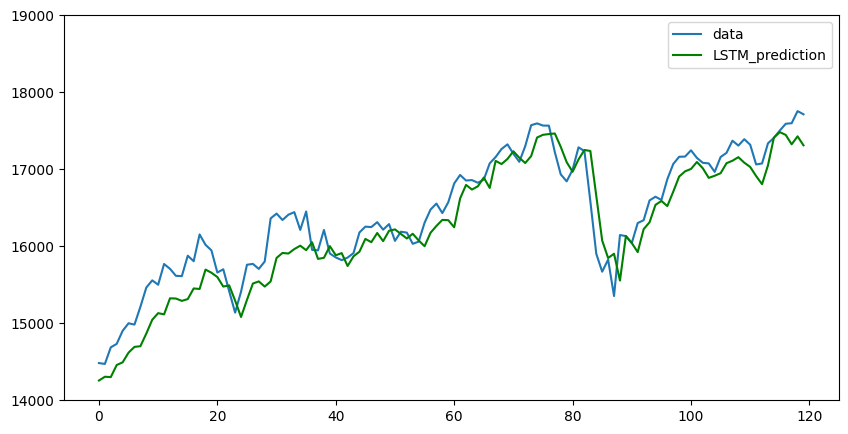

LSTM_R2= 0.8400289024944956
LSTM_MSE= 95525.9497552236
LSTM_MAE= 250.109765625
LSTM_RMSE= 309.0727256734628
LSTM_MRE= 1.539077334618696


In [34]:
plt.figure(figsize=(10 ,5))
# plt.ylim([13500,20000])
# plt.xlim([1,200])
# plt.ylim([12000,19000])
plt.plot(a['Close'].to_list())
plt.plot(np.array(predict_list).ravel(),c='g')
plt.legend(['data', 'LSTM_prediction'], loc='upper right')
# plt.plot(predict_list,c='g')
plt.ylim([14000,19000])
# plt.ylim([14000,16000])
plt.show()

k = a['Close'].tolist()
r = np.array(predict_list).ravel()

LSTM_R2 = r2_score(k,r)
LSTM_MSE = mean_squared_error(k,r)
LSTM_MAE = mean_absolute_error(k,r)
LSTM_MRE = np.mean(np.abs((k - r) / k)) * 100
print("LSTM_R2=",LSTM_R2)
print("LSTM_MSE=",LSTM_MSE)
print("LSTM_MAE=",LSTM_MAE)
print("LSTM_RMSE=",sqrt(LSTM_MSE))
print("LSTM_MRE=",LSTM_MRE)

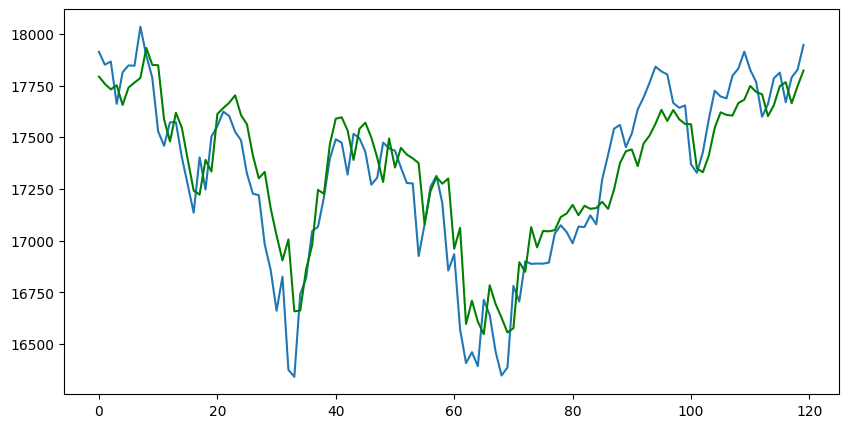

LSTM_R2= 0.8209731064181913
LSTM_MSE= 32179.49739835262
LSTM_MAE= 145.36416829427083
LSTM_RMSE= 179.38644708659743
LSTM_MRE= 0.8447305249530896


In [59]:
plt.figure(figsize=(10 ,5))
# plt.ylim([13500,20000])
# plt.xlim([1,200])
# plt.ylim([12000,19000])
plt.plot(b['Close'].to_list())
plt.plot(np.array(predict_list).ravel(),c='g')

# plt.plot(predict_list,c='g')

# plt.ylim([14000,16000])
plt.show()

k = b['Close'].tolist()
r = np.array(predict_list).ravel()

LSTM_R2 = r2_score(k,r)
LSTM_MSE = mean_squared_error(k,r)
LSTM_MAE = mean_absolute_error(k,r)
LSTM_MRE = np.mean(np.abs((k - r) / k)) * 100
print("LSTM_R2=",LSTM_R2)
print("LSTM_MSE=",LSTM_MSE)
print("LSTM_MAE=",LSTM_MAE)
print("LSTM_RMSE=",sqrt(LSTM_MSE))
print("LSTM_MRE=",LSTM_MRE)

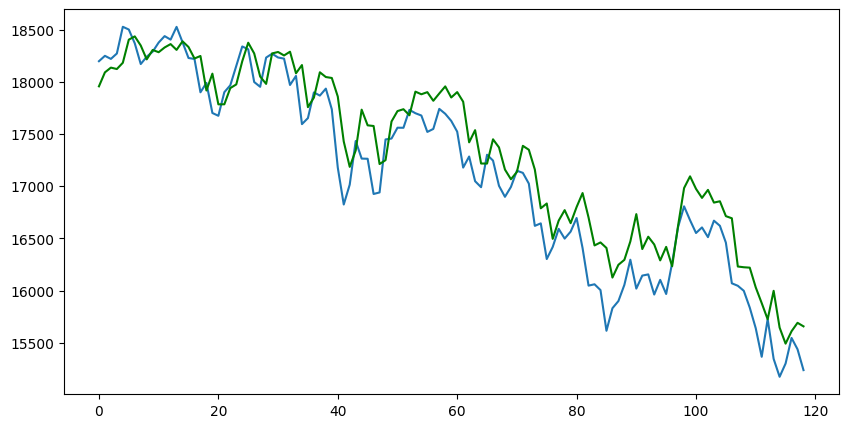

LSTM_R2= 0.8863421685135643
LSTM_MSE= 97481.00966431113
LSTM_MAE= 251.1183856355042
LSTM_RMSE= 312.2194895651313
LSTM_MRE= 1.4998664916214972


In [25]:
plt.figure(figsize=(10 ,5))
# plt.ylim([13500,20000])
# plt.xlim([1,200])
# plt.ylim([12000,19000])
plt.plot(c['Close'].to_list())
plt.plot(np.array(predict_list).ravel(),c='g')

# plt.plot(predict_list,c='g')

# plt.ylim([14000,16000])
plt.show()

k = c['Close'].tolist()
r = np.array(predict_list).ravel()

LSTM_R2 = r2_score(k,r)
LSTM_MSE = mean_squared_error(k,r)
LSTM_MAE = mean_absolute_error(k,r)
LSTM_MRE = np.mean(np.abs((k - r) / k)) * 100
print("LSTM_R2=",LSTM_R2)
print("LSTM_MSE=",LSTM_MSE)
print("LSTM_MAE=",LSTM_MAE)
print("LSTM_RMSE=",sqrt(LSTM_MSE))
print("LSTM_MRE=",LSTM_MRE)